## Description
To optimize production costs at the metallurgical plant, it is necessary to reduce the energy consumption at the steel processing stage.  

## Task
Build a model that predicts the final temperature of the steel based on the initial characteristics and processing stages.   

## Data Description
The data consists of files describing the different stages of steel processing. 

 
 
## Описание
Для оптимизации производственных расходов на металлургическом комбинате надо уменьшить потребление электроэнергии на этапе обработки стали.  

## Задача
Построить модель, которая по начальным характеристикам и этапам обработки предскажет конечную температуру стали.


## Описание данных
Данные состоят из файлов, описывающих разные стадии процесса обработки стали.

# Contents:
1. [Research data analysis](#1)
    - 1.1 [data_bulk-data on the supply of bulk materials (volume)](#data_bulk)
    - 1.2 [data_bulk_time - data on the supply of bulk materials (time)](#data_bulk_time)
    - 1.3 [data_arc-electrode data](#data_arc)
    - 1.4 [data_gas - gas purge data](#data_gas)
    - 1.5 [data_wire - wire material data (volume)](#data_wire)
    - 1.6 [data_wire_time-wire material data (time)](#data_wire_time)
    - 1.7 [data_temp-temperature measurement results](#data_temp)
2. [Data Preparation](#prepare)
3. [Model Training](#models)
    - 3.1 [Linear Regression](#models)
    - 3.2 [LGBMRegressor](#32)
    - 3.3 [RandomForestRegressor](#33)
    - 3.4 [keras.models.Sequential()](#34)
    - 3.5 [CatBoostRegressor](#35)
    - 3.6 [Feature importance](#36)
4. [Checking models on test data](#4)
5. [Conclusions](#5)

# Содержание:
1. [Исследовательский анализ данных](#1)  
     - 1.1 [data_bulk — данные о подаче сыпучих материалов (объём)](#data_bulk)
     - 1.2 [data_bulk_time — данные о подаче сыпучих материалов (время)](#data_bulk_time)
     - 1.3 [data_arc — данные об электродах](#data_arc)
     - 1.4 [data_gas — данные о продувке сплава газом](#data_gas)
     - 1.5 [data_wire — данные о проволочных материалах (объём)](#data_wire)
     - 1.6 [data_wire_time - данные о проволочных материалах (время)](#data_wire_time)
     - 1.7 [data_temp — результаты измерения температуры](#data_temp)
2. [Подготовка данных](#prepare)  
3. [Обучение моделей](#models)  
     - 3.1 [LinearRegression](#models)
     - 3.2 [LGBMRegressor](#32)
     - 3.3 [RandomForestRegressor](#33)
     - 3.4 [keras.models.Sequential()](#34)
     - 3.5 [CatBoostRegressor](#35)
     - 3.6 [Feature importance](#36)
4. [Проверка моделей на тестовых данных](#4)
5. [Выводы](#5)

In [1]:
!pip install catboost

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")


import lightgbm as lgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras

<a id='1'></a>

## Research data analysis / Исследовательский анализ данных

In [3]:
data_bulk_time = pd.read_csv("/app/_data/data_bulk_time.csv")
data_arc = pd.read_csv("/app/_data/data_arc.csv")
data_wire_time = pd.read_csv("/app/_data/data_wire_time.csv")
data_wire = pd.read_csv("/app/_data/data_wire.csv")
data_bulk = pd.read_csv("/app/_data/data_bulk.csv")
data_gas = pd.read_csv("/app/_data/data_gas.csv")
data_temp = pd.read_csv("/app/_data/data_temp.csv")

In [4]:
def describe_ds(data):
    """
    Information about dataset:
    head, info, missing values, main statistics,
    duplicates, unique names in 'key'
    """
    print("General information about the dataset \ Общая информация о датасете\n")
    print(data.head(), "\n")
    print(data.info())
    print("\nNumber of missing values \ Количество пропусков\n", data.isna().sum())
    print("\nStatistics \ Статистика")
    print(data.describe())
    print("\nNumber of unique batch numbers / Количество уникальных номеров партии", data.key.unique().shape[0])
    print("\nNumber of duplicates / Количество дубликатов", data.duplicated().sum())

<a id='data_bulk'></a>

### data_bulk — data on the supply of bulk materials (volume) / данные о подаче сыпучих материалов (объём)

In [5]:
describe_ds(data_bulk)

General information about the dataset \ Общая информация о датасете

   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (

__Summary:__
- The table has 3129 rows and 3129 unique batch numbers, 16 columns
    - __key__ - unique batch number,
    - __Bulk__ numbers from 1 to 15 - the volume of different alloys from the bulk material hopper, different materials are fed to different batches, so there are a lot of missing values.

- There is only one value in the __Bulk 8__ column.

- Bulk 14, 12, 15, 3 and 4 are most often added, other alloys are less common.

- There are no duplicates, the average volume values of different alloys vary greatly.

- For the convenience of further processing, it is better to rename the columns.

__Выводы:__  
 - В таблице 3129 строк и 3129 уникальных номеров партии, 16 столбцов
     - __key__ - уникальный номер партии,
     - __Bulk__ номера от 1 до 15 - объем разных сплавов из бункера для сыпучих материалов, в разные партии подаются разные материалы, поэтому много пропущенных значений.   

 - В столбце __Bulk 8__ только одно значение.  

 - Чаще всего добавляется Bulk 14, 12, 15, 3 и 4, остальные сплавы реже.

 - Дубликатов нет, средние значения объема разных сплавов сильно различаются.  

 - Для удобства дальнейшей обработки лучше переименовать столбцы.

In [6]:
columns = []
for i in data_bulk.columns.str.lower():
    columns.append("_".join(i.split()))
data_bulk.columns = columns

Let's look at the distribution of volume values for different materials:

Посмотрим на распределение значений объемов для разных материалов:

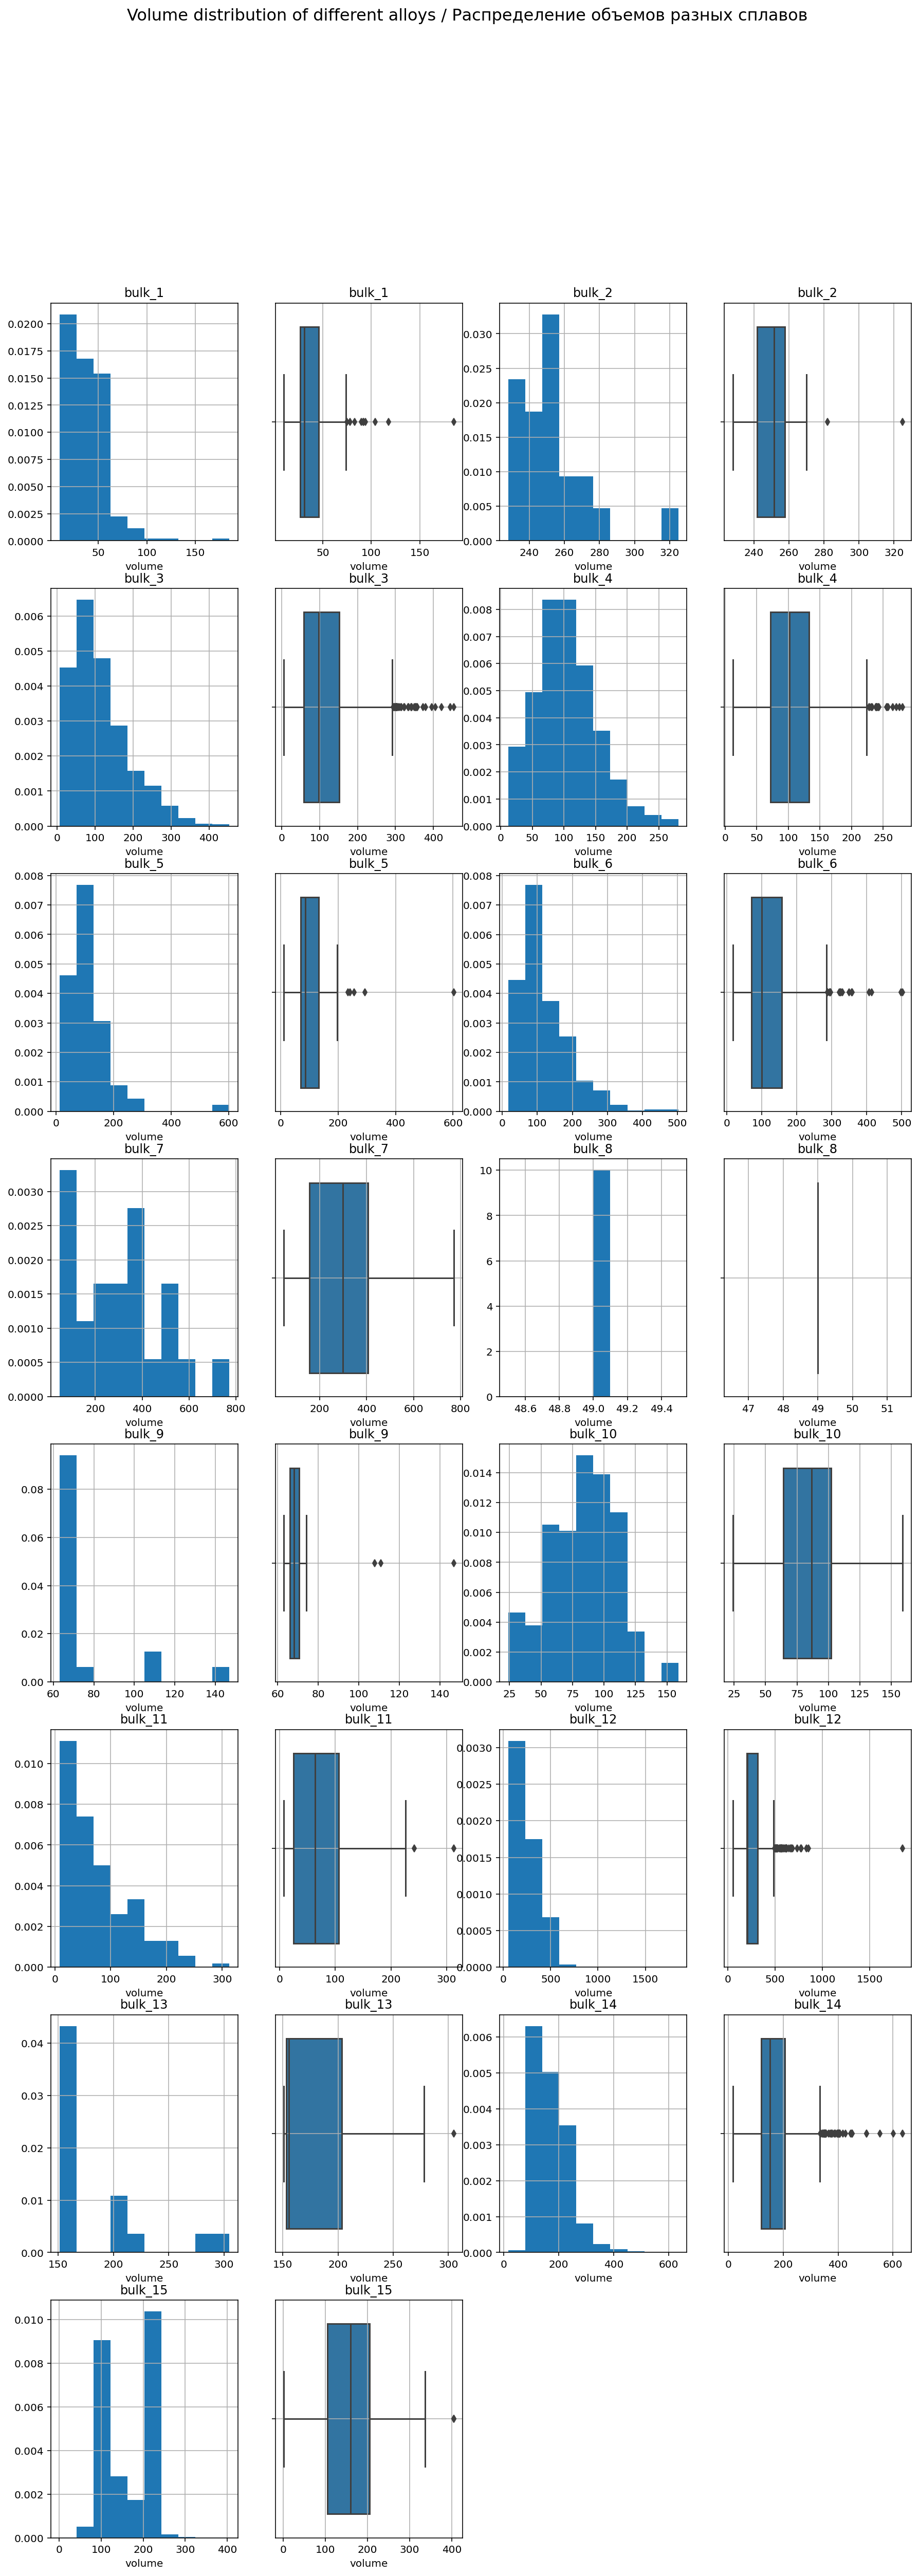

In [7]:
fig = plt.subplots(5, 3, figsize=(15, 40))
plt.suptitle("Volume distribution of different alloys / Распределение объемов разных сплавов", fontsize=16)
for column, i in zip(data_bulk.columns[1:], range(1, 33, 2)):
    plt.subplot(8, 4, i)
    plt.title(column, fontsize=12)
    plt.hist(data_bulk[column], density=True)
    plt.xlabel("volume")
    plt.grid()
    plt.subplot(8, 4, i + 1)
    plt.title(column, fontsize=12)
    sns.boxplot(data_bulk[column], orient="v")
    plt.xlabel("volume")
    plt.grid()
plt.show();

The distributions are not like normal ones, and there are values in the data that are very different from the rest.

Let's calculate which additives are added most often:

Распределения не похожи на нормальные, в даных есть значения, сильно отличающиеся от остальных.  

Посчитаем, какие добавки добавляют чаще всего:

In [8]:
bulk_frequency = (data_bulk.iloc[:, 1:].notna().sum() / data_bulk.shape[0]).sort_values(
    ascending=False
) * 100
bulk_frequency.head(10)

bulk_14    89.677213
bulk_12    78.299776
bulk_15    71.844040
bulk_3     41.482902
bulk_4     32.406520
bulk_6     18.408437
bulk_1      8.053691
bulk_11     5.656759
bulk_10     5.624800
bulk_5      2.460850
dtype: float64

The most popular ones are 'bulk_14', 'bulk_12',' bulk_15',' bulk_3',' bulk_4','bulk_6'. This table is useful for studying the feature importance for models.  
For further work, we fill in the gaps with zeros and bring everything to the 'int' type, and set the unique batch number as the indexes.

Самые популярные - 'bulk_14', 'bulk_12', 'bulk_15', 'bulk_3', 'bulk_4', 'bulk_6'. Эта таблица пригодится для изучения важности признаков для моделей.  
Для дальнейшей работы заполняем пропуски нулями и приводим все к вещественному типу, в качестве индексов ставим уникальный номер партии.

In [9]:
data_bulk = data_bulk.fillna(0)
data_bulk.index = data_bulk["key"]
data_bulk = data_bulk.drop("key", axis=1).astype(int)

Regarding outliers: a study of the model results showed that removing or replacing outliers with medians in this dataset has a bad effect on the model's prediction results, apparently, these values are similar to the real ones and they have a significant impact on the process and the final temperature. Therefore, we leave it as it is.

По поводу выбросов: изучение результатов моделей показало, что удаление или замена выбросов медианами в данном датасете плохо сказывается на результатах предсказания модели, по-видимому, эти значения похожи на реальные и они оказывают существенное влияние на процесс и конечную температуру. Поэтому оставляем как есть.

<a id='data_bulk_time'></a>

### data_bulk_time - data on the supply of bulk materials (time) / данные о подаче сыпучих материалов (время)

In [10]:
describe_ds(data_bulk_time)

General information about the dataset \ Общая информация о датасете

   key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-

The table has 3129 rows and 3129 unique batch numbers, 16 columns
- __key__ - unique batch number,
- __Bulk__ from 1 to 15 - the feed time of different alloys, different materials are served in different batches, so there are a lot of missing values, the data type is object.


In the __Bulk 8 _ _ column, as in the previous table, there is only one value.

There are no duplicates.

В таблице 3129 строк и 3129 уникальных номеров партии, 16 столбцов
 - __key__ - уникальный номер партии,
 - __Bulk__ от 1 до 15 - время подачи разных сплавов, в разные партии подаются разные материалы, поэтому много пропущенных значений, тип данных - object.   
 

В столбце __Bulk 8__, как и в предыдущей таблице, только одно значение.  

Дубликатов нет.


In [11]:
for column in data_bulk_time.columns[1:]:
    data_bulk_time[column] = pd.to_datetime(
        data_bulk_time[column], format="%Y-%m-%d %H:%M:%S", errors="coerce"
    )

Let's see for what period of time we have data:  
Посмотрим, за какой промежуток времени у нас данные:

In [12]:
data_bulk_time["Bulk 1"].min()
data_bulk_time["Bulk 15"].max()

Timestamp('2019-05-03 17:50:19')

Timestamp('2019-09-01 04:05:34')

We have data from the beginning of May to the beginning of September 2019, in further research we will not need this table.

Речь идет про данные с начала мая по начало сентября 2019 года, нам в дальнейшем исследовании эта таблица не пригодится.

<a id='data_arc'></a>

### data_arc — data about the electrodes / данные об электродах

In [13]:
describe_ds(data_arc)

General information about the dataset \ Общая информация о датасете

   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-nul

__Summary:__
The table has 14,876 rows and 3,214 unique batch numbers, which is more than the previous tables, 5 columns.

- __key__ - unique batch number,
- __Начало нагрева дугой__ arc heating start time, data type "object",
- __Конец нагрева дугой__ arc heating end time, data type "object",
- __Активная мощность__ active power,
- __Реактивная мощность__ reactive power.

There are no duplicates, no omissions either.  
In the "Reactive power" column, there is a large / large negative value, need to check.    
The column names are in Russian, it is better to rename them for the convenience of further work.    


__Выводы:__  
В таблице 14876 строк и 3214 уникальных номеров партии, это больше, чем в предыдущих таблицах, 5 столбцов.  

 - __key__ - уникальный номер партии,
 - __Начало нагрева дугой__  время начала нагрева дугой, тип данных "object",
 - __Конец нагрева дугой__ время окончания нагрева дугой, тип данных "object",
 - __Активная мощность__,
 - __Реактивная мощность__.

Дубликатов нет, пропусков тоже нет.    
В столбце "Реактивная мощность" есть большое/большие отрицательное значение, надо проверять.    
Названия столбцов на русском, лучше переименовать для удобства дальнейшей работы.  

In [14]:
data_arc.columns = [
    "key",
    "heating_start",
    "heating_end",
    "real_power",
    "reactive_power",
]

There are more rows than batches, so for some batches the heating was performed several times. Let's look at the number of starts of heating with electrodes:  

Строк больше, чем партий, следовательно для некоторых партий нагрев проводился несколько раз. Посмотрим количество запусков нагрева электродами:

In [15]:
data_arc["key"].value_counts().unique()

array([16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

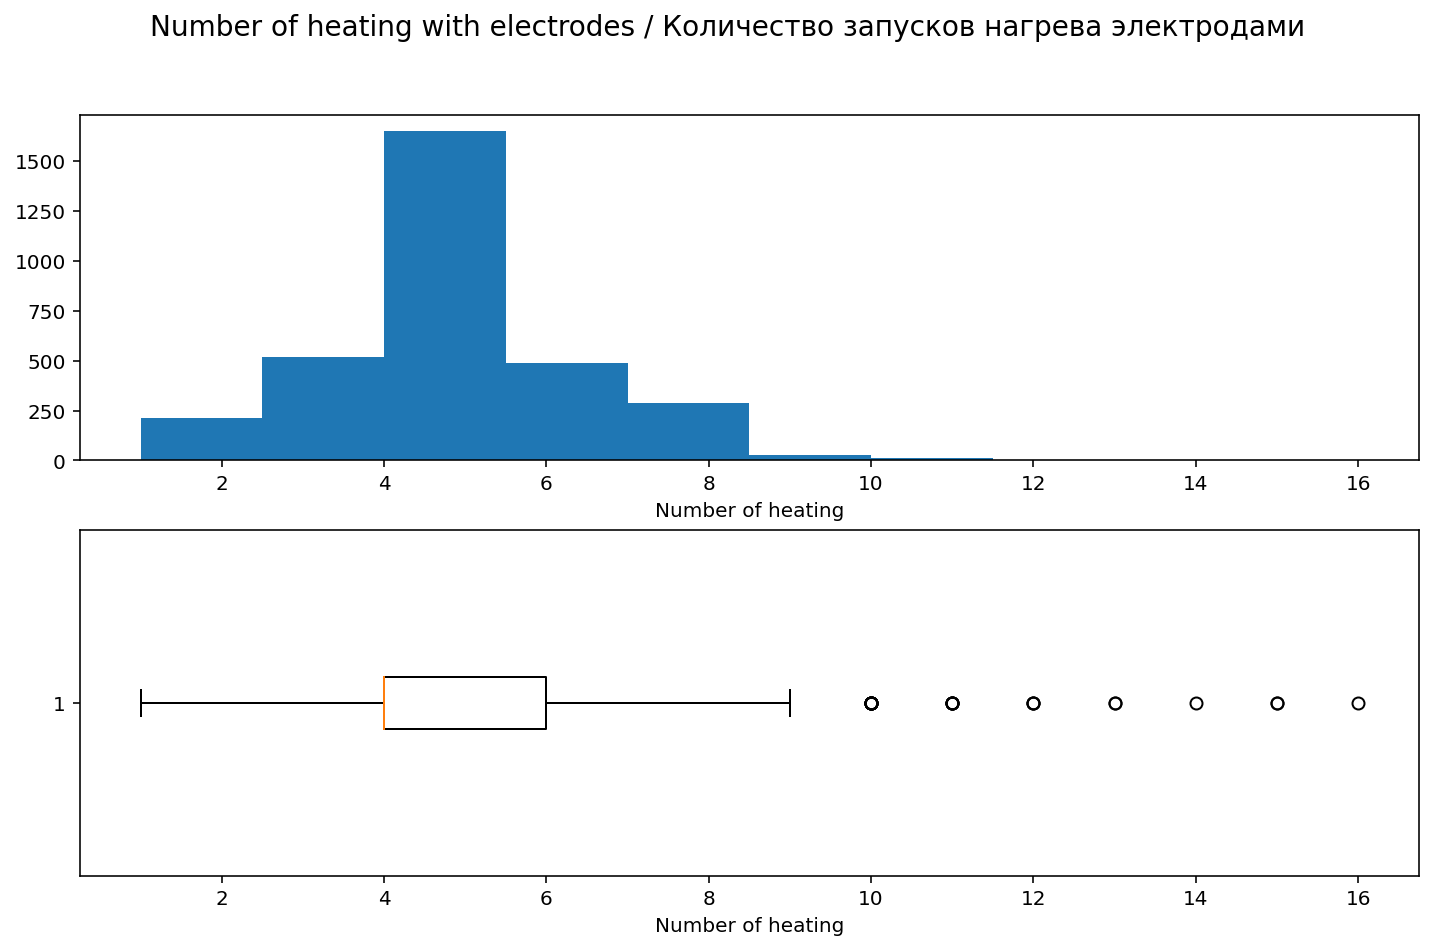

In [16]:
fig = plt.figure(figsize=(12, 7))
plt.suptitle("Number of heating with electrodes / Количество запусков нагрева электродами", fontsize=14)
plt.subplot(2, 1, 1)
plt.hist(data_arc["key"].value_counts())
plt.xlabel("Number of heating")
plt.subplot(2, 1, 2)
plt.boxplot(data_arc["key"].value_counts(), vert=False)
plt.xlabel("Number of heating")
plt.show();

Some batches were heated once, some 16, mostly 4-6 times.  
The heating duration is important information. So let's add the "heat_duration" column with the heating time in seconds.

Некоторые партиии нагревали один раз, некоторые 16, в основном 4 -6 раз.  
Длительность нагрева - важная информация. Поэтому добавим столбец "heat_duration" с временем нагрева в секундах.

In [17]:
for column in ["heating_start", "heating_end"]:
    data_arc[column] = pd.to_datetime(
        data_arc[column], format="%Y-%m-%d %H:%M:%S", errors="coerce"
    )

In [18]:
data_arc["heat_duration"] = (
    (data_arc.heating_end - data_arc.heating_start).dt.total_seconds().astype("int")
)

In [19]:
data_arc["heat_duration"].describe()

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: heat_duration, dtype: float64

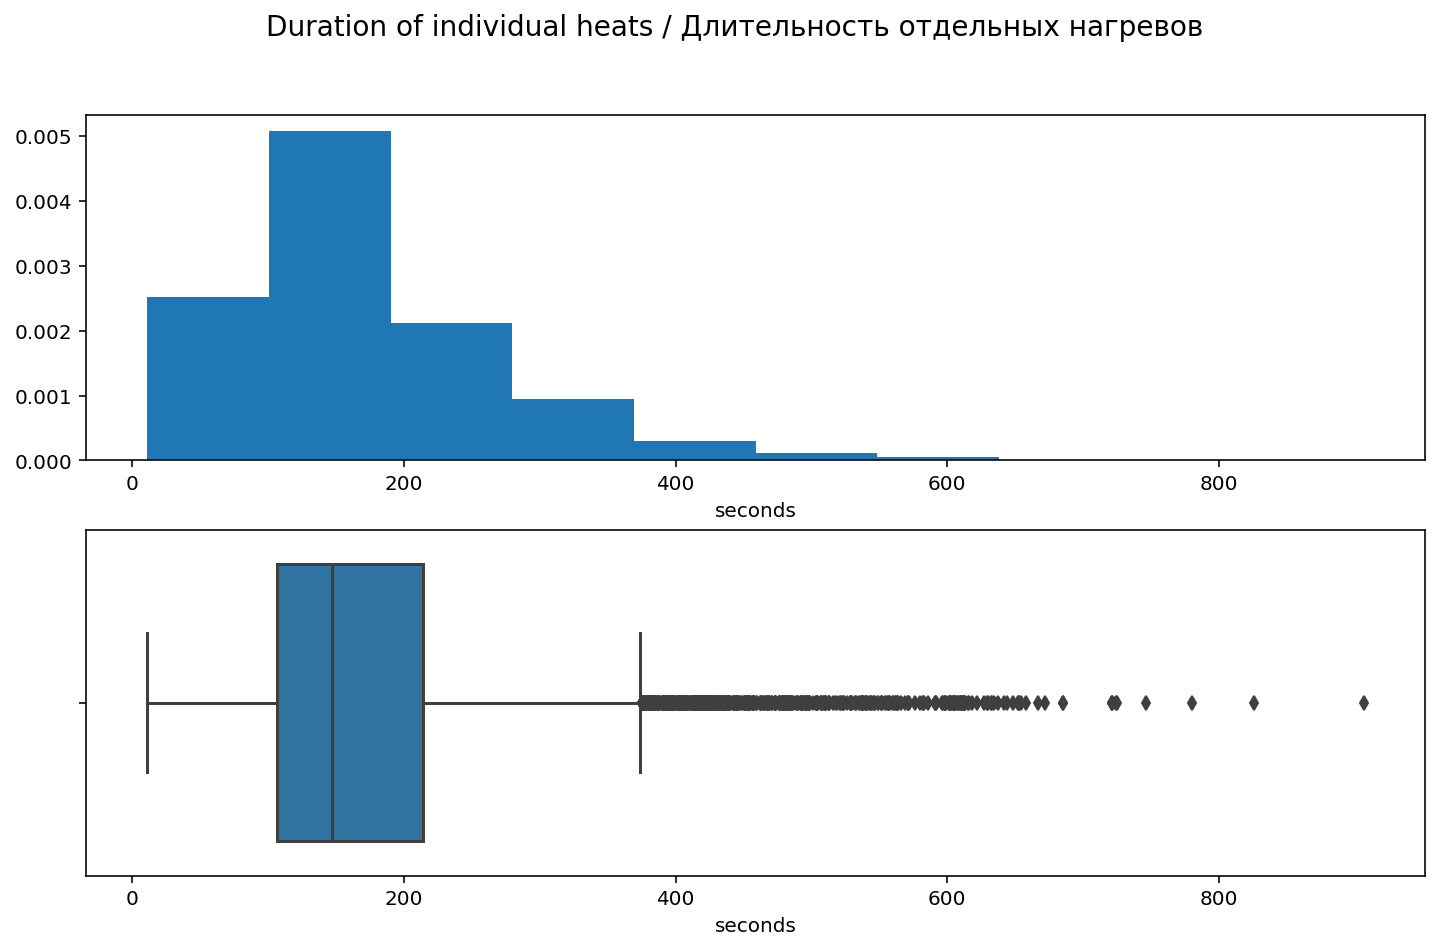

In [20]:
fig = plt.figure(figsize=(12, 7))
plt.suptitle("Duration of individual heats / Длительность отдельных нагревов", fontsize=14)
plt.subplot(2, 1, 1)
plt.hist(data_arc["heat_duration"], density=True)
plt.xlabel("seconds")
plt.subplot(2, 1, 2)
sns.boxplot(data_arc["heat_duration"])
plt.xlabel("seconds")
plt.show();

The average heating time is 171.6 seconds, the minimum is 11, the maximum is 907, and the standard deviation is 98 seconds.  
The main part lies within 600 seconds,sometimes heating is longer.  
We group them by batch and calculate the total heating time.  

Среднее время нагрева 171.6 секунды, минимальное - 11, максимальное - 907, стандартное отклонение - 98 секунд.   
Основная часть лежит в пределах 600 секунд,иногда приходится нагревать дольше.    
Группируем по партии и считаем суммарное время нагрева.

In [21]:
arc_temp_pivot = pd.pivot_table(
    data=data_arc,
    index="key",
    aggfunc={"heat_duration": ["sum", "count"]},
)
arc_temp_pivot.columns = ["arc_count", "arc_duration"]
arc_temp_pivot.head(3)

arc_count  arc_duration
key                         
1            5          1098
2            4           811
3            5           655

In [22]:
arc_temp_pivot["arc_duration"].describe() / 60

count    53.566667
mean     13.242984
std       5.540810
min       0.950000
25%       9.516667
50%      12.833333
75%      16.383333
max      69.816667
Name: arc_duration, dtype: float64

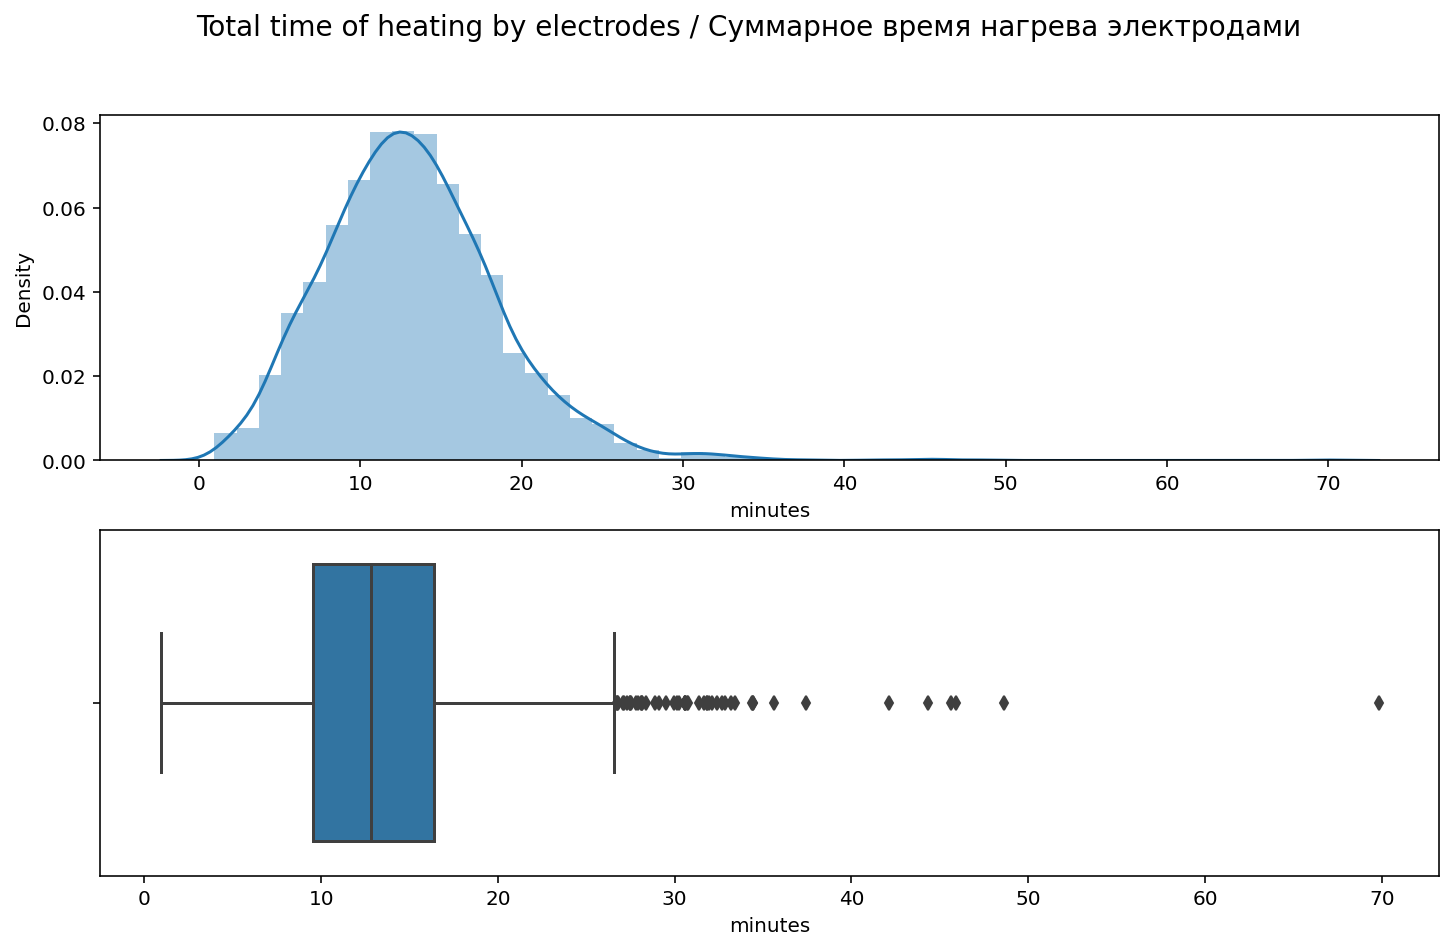

In [23]:
fig = plt.figure(figsize=(12, 7))
plt.suptitle("Total time of heating by electrodes / Cуммарное время нагрева электродами", fontsize=14)
plt.subplot(2, 1, 1)
sns.distplot(arc_temp_pivot["arc_duration"] / 60)
plt.xlabel("minutes")
plt.subplot(2, 1, 2)
sns.boxplot(arc_temp_pivot["arc_duration"] / 60)
plt.xlabel("minutes")
plt.show();

__Summary:__
- the average value of the total heating time is 13.2 minutes,
- median-close to average, 12.8 minutes,
- minimum-0.95 minutes,
- maximum-69.8 minutes, looks like an outlier,
- standard deviation 5.5 minutes ,
- more than 40 minutes of heating was rarely performed,
- distribution looks like normal.

__Выводы:__
 - среднее значение суммарного времени нагрева 13,2 минуты,
 - медиана - близка к среднему, 12,8 минут,
 - минимальное - 0.95 минут,
 - максимальное - 69.8 минут, похоже на выброс,
 - стандартное отклонение 5.5 минут,
 - больше 40 минут нагрев проводился редко,
 - распределение похоже на нормальное.  


___

A little bit about power
_ _ _ Active power (Real Power, P)___
The unit of measurement is watt (Russian designation: W, kilowatt - kW; international: watt-W, kilowatt-kW).

The average value of the instantaneous power over the period Τ is called the active power,
In other words, the active power can be called: actual, real, useful, real power. In a DC circuit, the power that feeds a DC load is defined as the simple product of the load voltage and the flowing current, i.e. $ P = U * I $


___reactive Power (Reactive Power, Q)___
The unit of measurement is the reactive volt-ampere (Russian designation: var, kVAR; international: var, 1 var = 1 V x 1 A).
Reactive power is the power that is consumed and then returned by the load due to its reactive properties. The reactive power energy is first stored and then released in the form of a magnetic field or an electric field in the case of an inductor or a capacitor, respectively. The reactive power can be positive for an inductive load and negative for a capacitive load.


___Full Power (Apparent Power, S)___
The unit of total electrical power is volt-ampere (Russian designation: V·A, VA, kVA-kilo-volt-ampere; international: V·A, kVA).

The ratio of total power to active and reactive power is expressed as follows:
$$ S = \sqrt{P^2 + Q^2} $$
power ratio where P is active power, Q is reactive power (for inductive load Q"0, and for capacitive load Q" 0).

The total power is of practical importance, as a value describing the loads actually imposed by the consumer on the elements of the supply power network (wires, cables, switchboards, transformers, power lines), since these loads depend on the current consumed, and not on the energy actually used by the consumer.

___

___

Немного про мощность
___Активная мощность (Real Power, P)___
Единица измерения — ватт (русское обозначение: Вт, киловатт - кВт; международное: ватт -W, киловатт - kW).  

Среднее за период Τ  значение мгновенной мощности называется активной  мощностью,
Другими словами активную мощность можно назвать: фактическая, настоящая, полезная, реальная мощность. В цепи постоянного тока мощность, питающая нагрузку постоянного тока, определяется как простое произведение напряжения на нагрузке и протекающего тока, то есть $ P = U * I $


___Реактивная мощность (Reactive Power, Q)___
Единица измерения — вольт-ампер реактивный (русское обозначение: вар, кВАР; международное: var,  1 вар = 1 В х 1 А).  
Реактивной называется мощность, которая потребляется и затем возвращается нагрузкой из-за её реактивных свойств. Энергия реактивной мощности сначала накапливается, а затем высвобождается в виде магнитного поля или электрического поля в случае, соответственно, индуктивности или конденсатора. Реактивная мощность может быть положительной  для индуктивной нагрузки и отрицательной для емкостной нагрузки.


___Полная мощность (Apparent Power, S)___
Единица полной электрической мощности — вольт-ампер (русское обозначение: В·А, ВА, кВА-кило-вольт-ампер; международное: V·A, kVA).   

Cоотношение полной мощности с активной и реактивной мощностями выражается в следующем виде:  
$$ S =  \sqrt{P^2 + Q^2} $$ 
соотношение мощностей    где P — активная мощность, Q — реактивная мощность (при индуктивной нагрузке Q›0, а при ёмкостной Q‹0).

Полная мощность имеет практическое значение, как величина, описывающая нагрузки, фактически налагаемые потребителем на элементы подводящей электросети (провода, кабели, распределительные щиты, трансформаторы, линии электропередачи), так как эти нагрузки зависят от потребляемого тока, а не от фактически использованной потребителем энергии.  

___

Let's take a closer look at the distribution of values and statistics. But first, since there are negative values in the reactive power column, let's look at them:

Посмотрим подробней распределение значений и статистики. Но сначала, поскольку в столбце с реактивной мощностью есть отрицательные значения, посмотрим на них:

In [24]:
sum(data_arc["reactive_power"] < 0)
data_arc[data_arc["reactive_power"] < 0]

1

key       heating_start         heating_end  real_power  \
9780  2116 2019-07-24 00:44:48 2019-07-24 00:46:37    0.495782   

      reactive_power  heat_duration  
9780     -715.504924            109

Just one value, looks like an error, especially since the absolute value is very large compared to the rest of the column values. We can delete it, or replace with the median value in the column.
We'll replace with the median value

Всего одно значение, похоже на ошибку, тем более абсолютное значение очень велико по сравнению с остальными значениями столбца. Можно удалить, можно заменить на медианное значения в столбце.  
Заменяем медианным значением

In [25]:
data_arc.loc[9780, "reactive_power"] = data_arc[data_arc["reactive_power"] >= 0][
    "reactive_power"
].median()

In [26]:
data_arc[["real_power", "reactive_power"]].describe(
    percentiles=(0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99)
)

real_power  reactive_power
count  14876.000000    14876.000000
mean       0.670441        0.500718
std        0.408159        0.310871
min        0.030002        0.020806
1%         0.112734        0.080798
5%         0.209754        0.150296
10%        0.263753        0.190503
25%        0.395297        0.291008
50%        0.555517        0.415984
75%        0.857034        0.637371
90%        1.214875        0.909250
95%        1.448089        1.097265
99%        2.079994        1.592817
max        3.731596        2.676388

For both active and reactive power, the standard deviation is greater than 50% of the average, which indicates that the data has a strong spread. The average value of the active power is 0.67, the median is 0.55, that is, the distribution is shifted to the right. The average value of the reactive power is 0.5, the median is 0.41, and the distribution is also shifted to the right.

И для активной и для реактивной мощности стандартное отклонение больше 50% от среднего, это говорит о том, что данные имеют сильный разброс. Среднее значение активной мощности - 0,67, медиана - 0,55, то есть распределение смещено вправо. Среднее значение реактивной мощности - 0,5, медиана - 0,41, распределение тоже смещено вправо. 

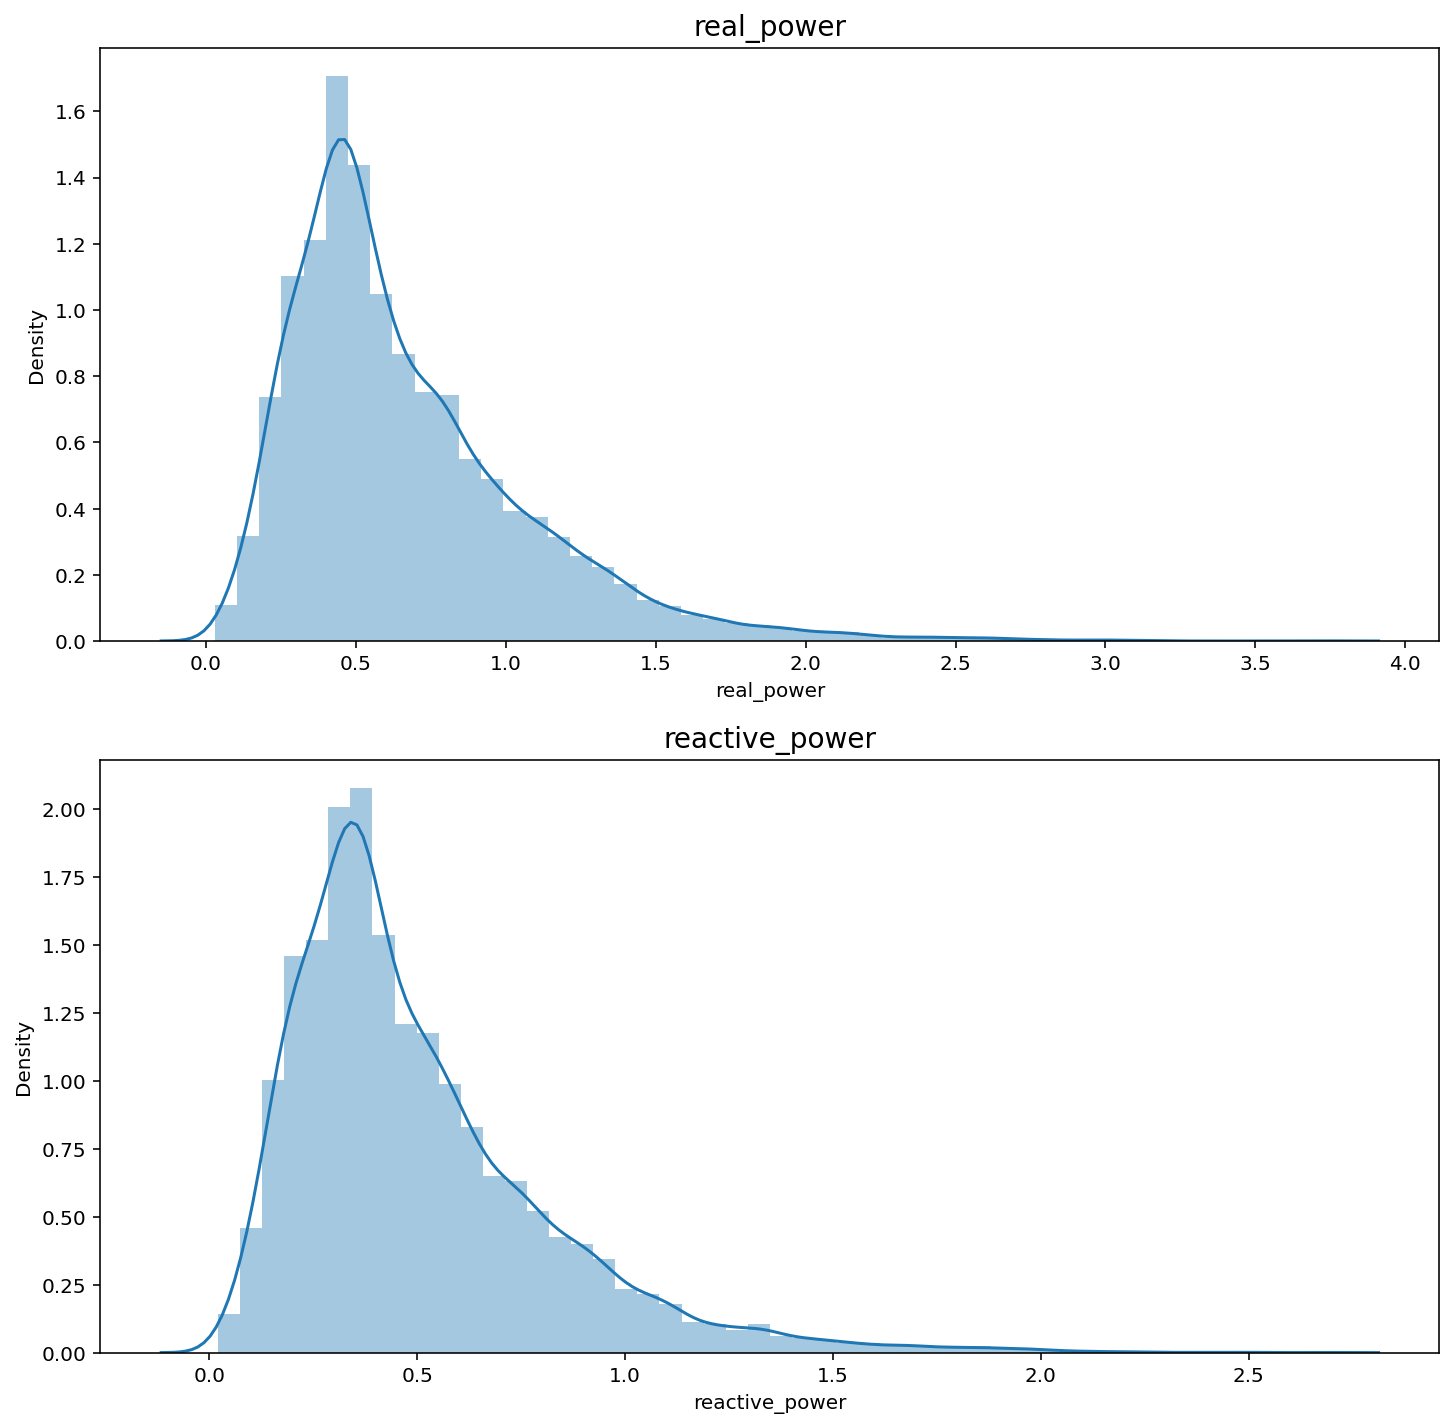

In [27]:
fig = plt.figure(figsize=(12, 12))
for column, i in zip(["real_power", "reactive_power"], range(1, 3)):
    plt.subplot(2, 1, i)
    plt.title(column, fontsize=14)
    sns.distplot(data_arc[column])
plt.show();

The active and reactive power distributions are very similar. Let's see if there is a relationship between active and reactive power

Распределения активной и реактивной мощностью очень похожи. Посмотрим, есть ли зависимость между активной и реактивной мощностью 

In [28]:
data_arc["reactive_power"].corr(data_arc["real_power"])

0.9631814204658339

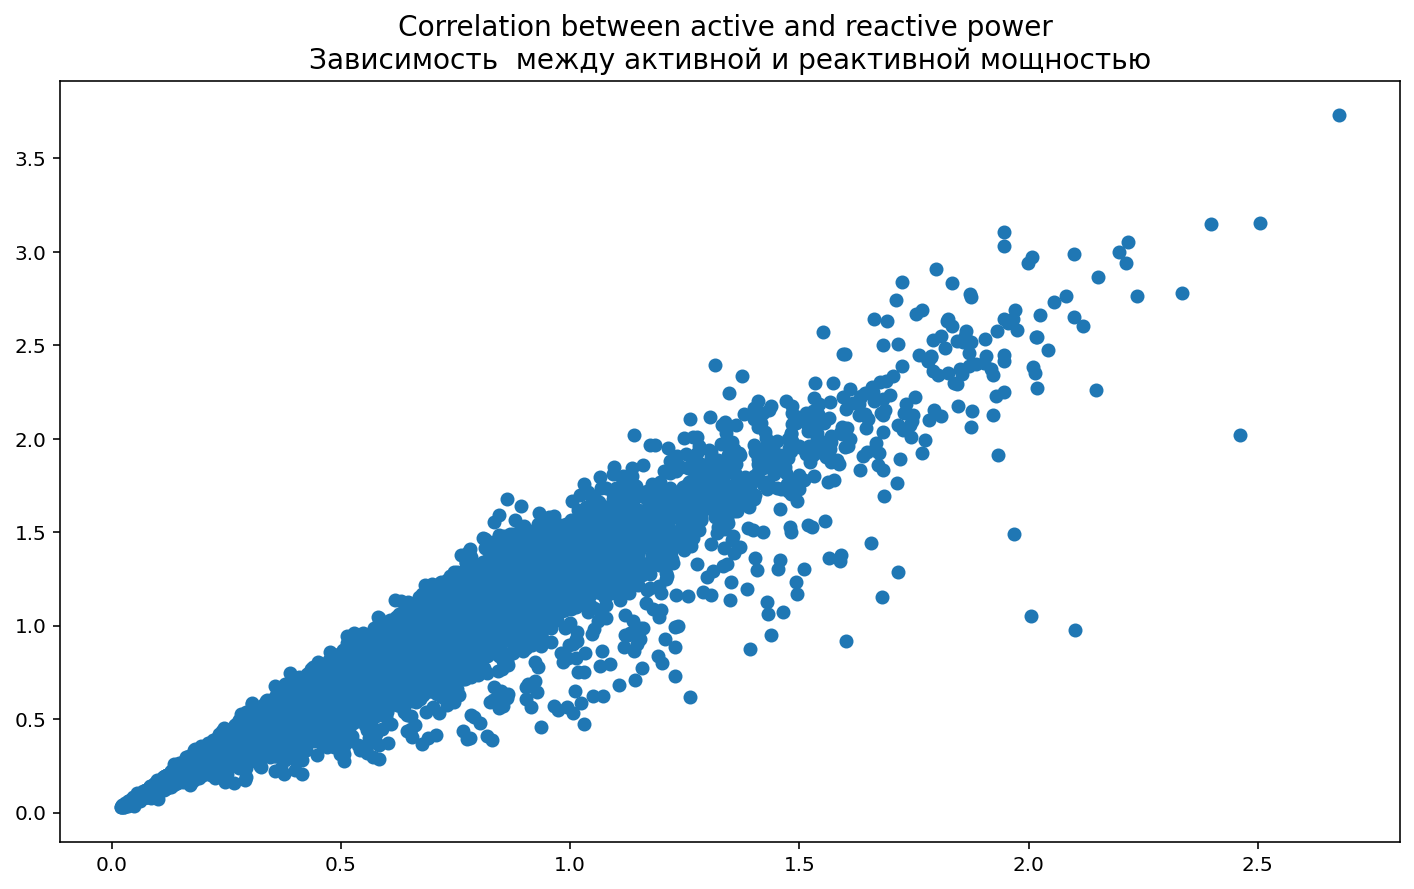

In [29]:
fig = plt.figure(figsize=(12, 7))
plt.title("Сorrelation between active and reactive power \nЗависимость  между активной и реактивной мощностью", fontsize=14)
plt.scatter(data_arc["reactive_power"], data_arc["real_power"])
plt.show();

There is a strong positive relationship between active and reactive power, the correlation coefficient is 0.96. In the future, this may affect the results of training the model, so we will keep in mind.
We can calculate the total power and the amount of energy spent by multiplying it by the time. Since we do not care about the units of measurement (and we do not know them for power), we will multiply the energy by the time in seconds.

Есть сильная положительная связь между активной и реактивной мощностью, коэффициент корреляции 0,96. В дальнейшем это может сказаться на результатах обучения модели, поэтому будем иметь ввиду.  
Можно посчитать полную мощность и количество потраченной энергии, умножив ее на время. Поскольку нам не важны единицы измерения (а для мощности мы их не знаем), то энергию будем умножать на время в секундах.

In [30]:
data_arc["full_power"] = np.sqrt(
    data_arc["real_power"] ** 2 + data_arc["reactive_power"] ** 2
)
data_arc["energy"] = data_arc["full_power"] * (data_arc["heat_duration"])

We also calculate the ratio of active and reactive power.

Посчитаем также соотношение активной и реактивной мощности.

In [31]:
data_arc["power_ratio"] = data_arc["real_power"] / data_arc["reactive_power"]

It is interesting to check two types of data grouping in the electrode table:
1. Grouping data by batch number, including the "real_power" and "reactive_power" columns (they are useful for working with outliers) and calculating averages and amounts.
2. Make a table according to the type of table with bulk materials, numbering the heats from 1 to 16 and grouping them by batch number and heats.

__Variant 1__

Интресно проверить два вида группировки данных в таблице об электродах:
1. Группировка данных по номеру партии, включая столбцы "real_power" и "reactive_power" (они пригодятся для работы с выбросами) и расчет средних значений и сумм.
2. Сделать таблицу по типу таблицы с сыпучими материалами, пронумеровав нагревы от 1 до 16 и сгруппировав по номеру партии и нагревам.  

__Вариант 1__

In [32]:
data_arc_pivot = pd.pivot_table(
    data=data_arc,
    index="key",
    aggfunc={
        "heat_duration": ["sum", "count"],
        "energy": "sum",
        "real_power": "mean",
        "reactive_power": "mean",
        "full_power": "mean",
        "power_ratio": "mean",
    },
)
data_arc_pivot.columns = [
    "energy",
    "full_power",
    "heat_duration_count",
    "heat_duration_sum",
    "power_ratio",
    "reactive_power",
    "real_power",
]
data_arc_pivot.head(3)

energy  full_power  heat_duration_count  heat_duration_sum  \
key                                                                    
1    1442.377754    1.165279                    5               1098   
2     881.233565    0.912304                    4                811   
3     525.066777    0.597907                    5                655   

     power_ratio  reactive_power  real_power  
key                                           
1       1.538898        0.636648    0.975629  
2       1.551834        0.499528    0.763150  
3       1.583120        0.319815    0.505176

__Outliers__ / __Выбросы__ data_arc_pivot

__The most effective__ method of removing outliers was based on visual study of graphs. The removal using three sigma or using quantiles was less effective in terms of the model results.

Replacing outliers with median values was also ineffective.

__Самым эффективным__ оказался метод удаления выбросов, основанный на визуальном изучении графиков. Удаление с помощью трех сигм или с помощью квантилей оказалось менее эффективным с точки зрения результатов модели.  

Также не эффективной оказалась замена выбросов медианными значениями.

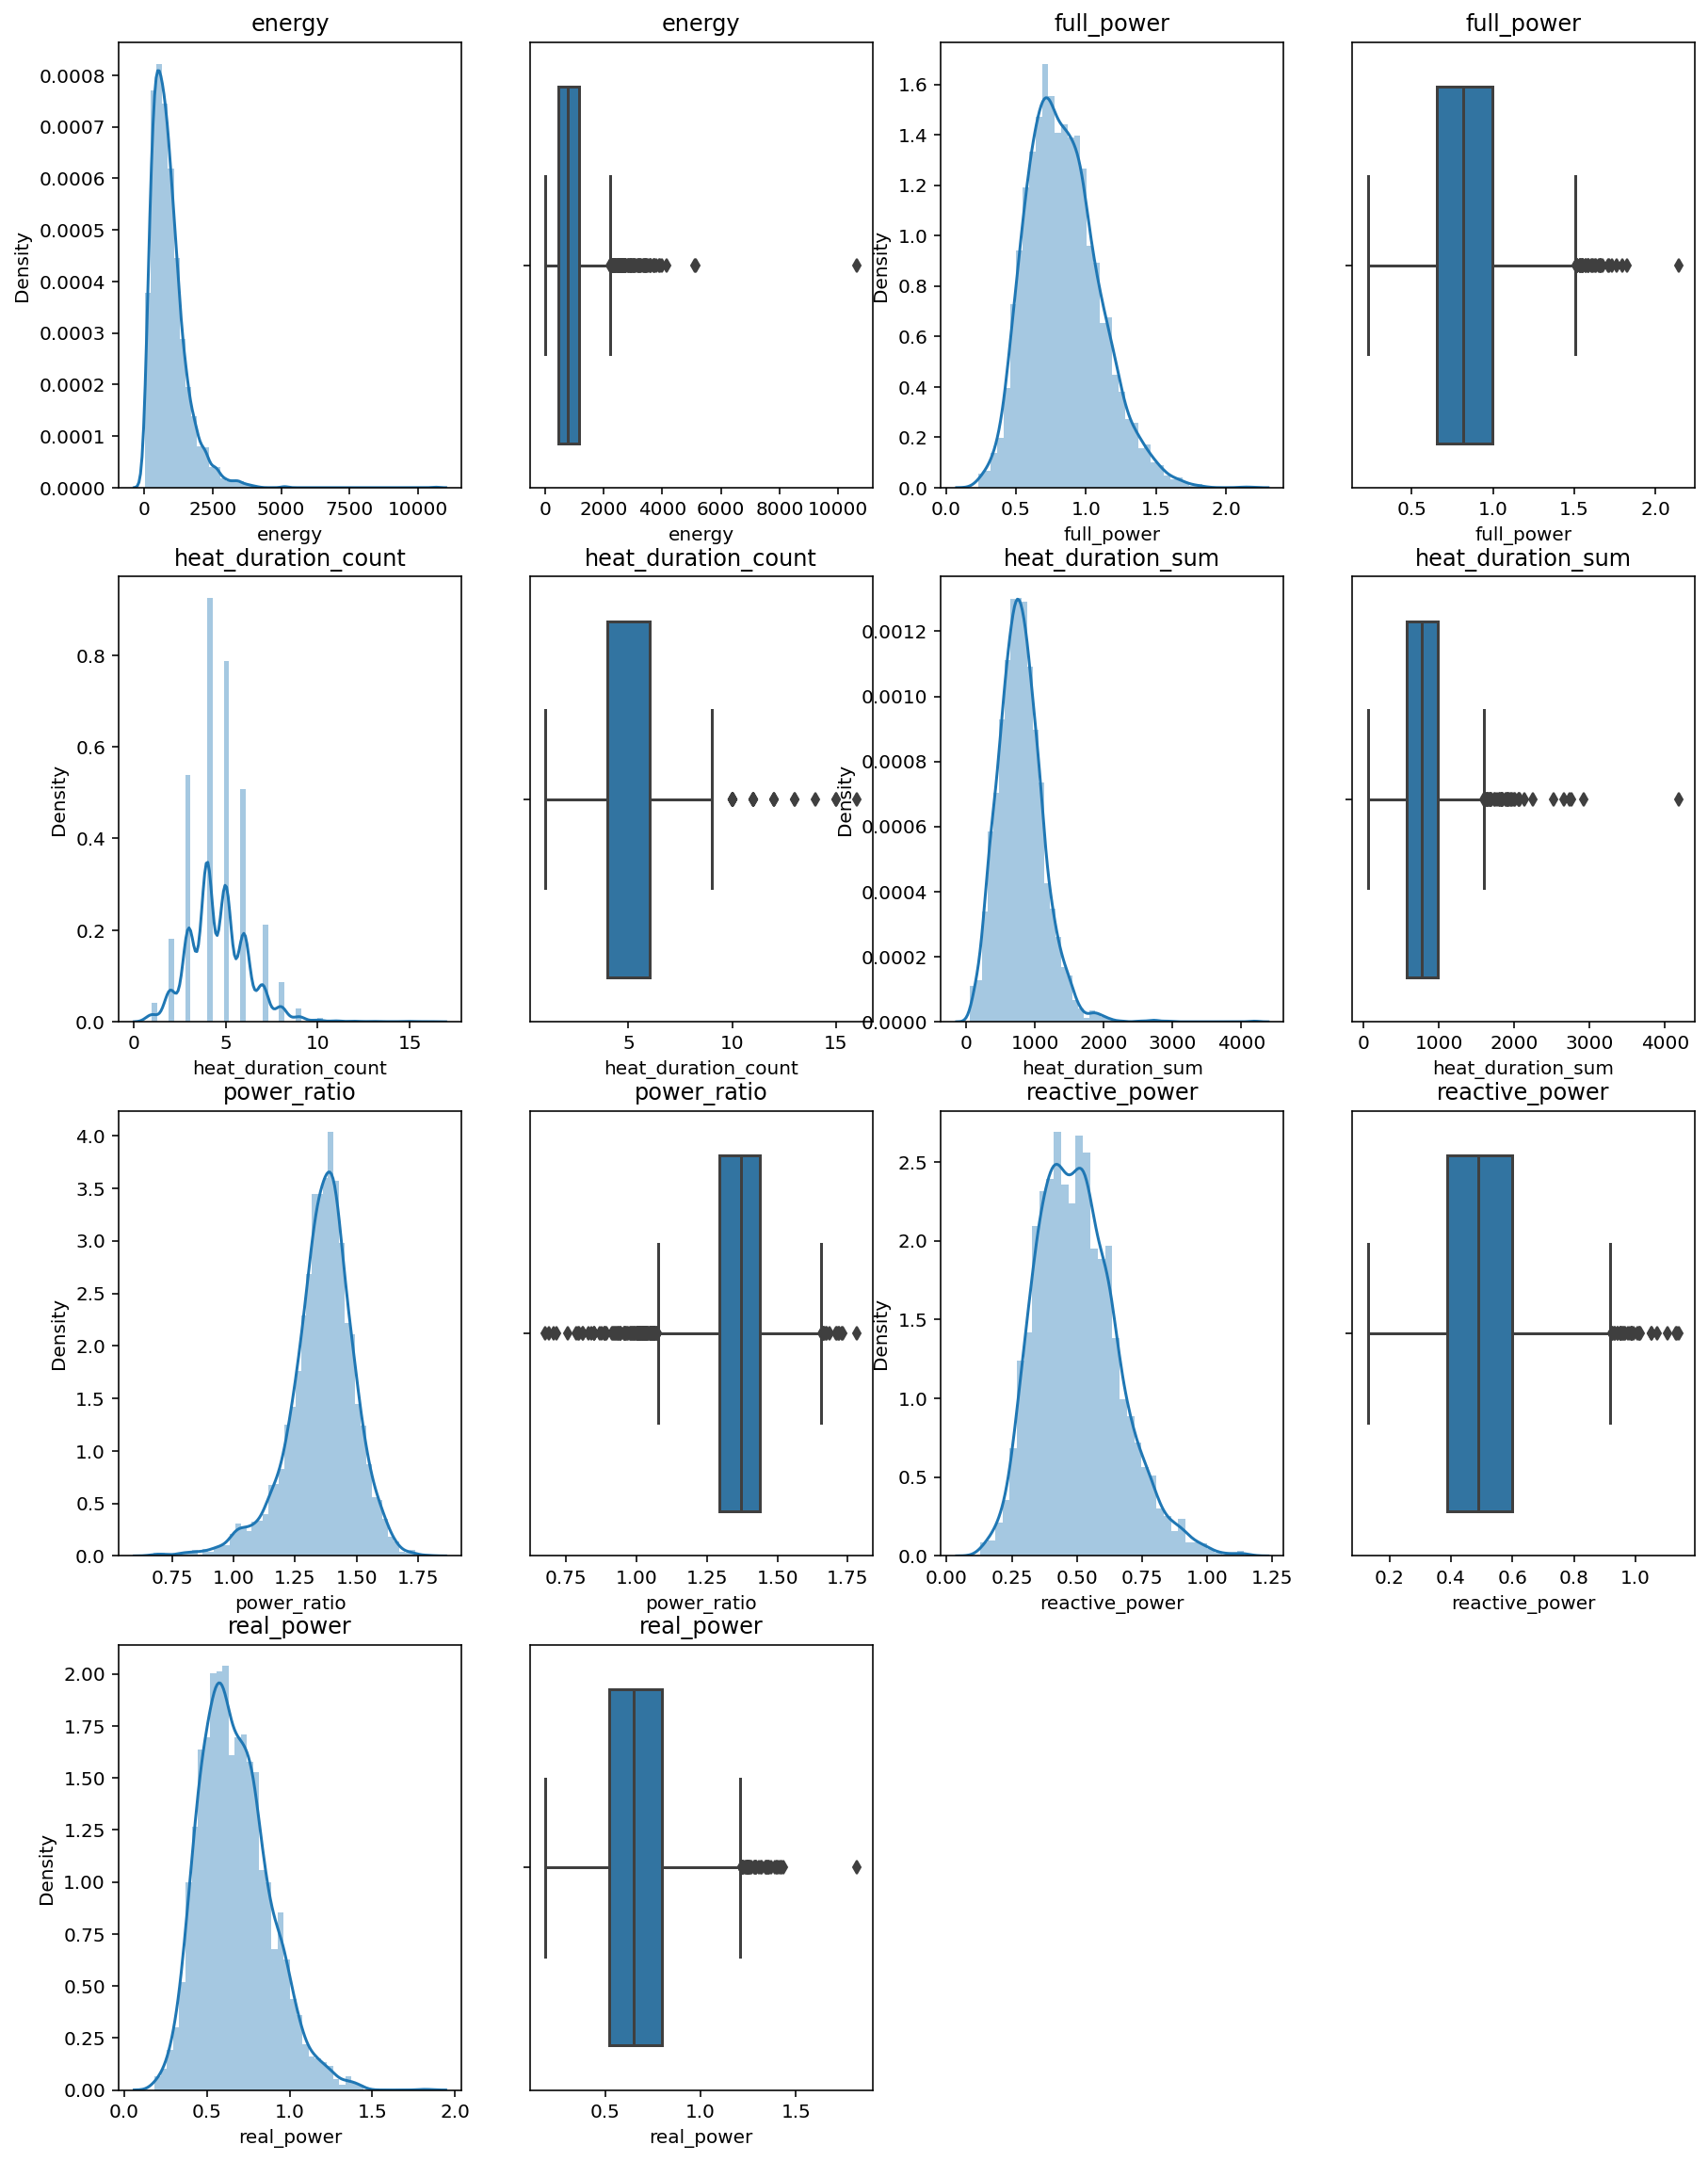

In [33]:
plt.figure(figsize=(15, 20))
for col, j in zip(data_arc_pivot.columns, range(1, 16, 2)):
    plt.subplot(4, 4, j)
    plt.title(col)
    sns.distplot(data_arc_pivot[col])
    plt.subplot(4, 4, j + 1)
    plt.title(col)
    sns.boxplot(data_arc_pivot[col])
plt.show();

After studying the graphs, we make a dictionary with the column name and boundary values.  
По изучению графиков составляем словарь с названием столбца и пограничными значениями.

In [34]:
dict_arc = {
    "energy": (0, 4500),
    "full_power": (0, 2.0),
    "heat_duration_count": (0, 10),
    "heat_duration_sum": (0, 2500),
    "power_ratio": (0.8, 1.75),
    "reactive_power": (0, 1.05),
    "real_power": (0, 1.5),
}

Looking for indexes of rows with extreme values  
Ищем индексы строк с экстремальными значениями

In [35]:
extreme_index_arc = []
for col in dict_arc:
    high = dict_arc[col][1]
    low = dict_arc[col][0]
    index = list(
        data_arc_pivot[(data_arc_pivot[col] < low) | (data_arc_pivot[col] > high)].index
    )
    extreme_index_arc.extend(index)
print("Row numbers with extreme values \nКоличество строк с экстремальными значениями: ", len(set(extreme_index_arc)))
print(
    "Percentage of rows with extreme values from the entire dataset \nДоля строк с экстремальными значениями от всего датасета: ",
    round(len(set(extreme_index_arc)) / data_arc_pivot.shape[0] * 100, 2),
    "%",
)

Row numbers with extreme values 
Количество строк с экстремальными значениями:  30
Percentage of rows with extreme values from the entire dataset 
Доля строк с экстремальными значениями от всего датасета:  0.93 %


0.93% of the rows, this is not very much (but not very little), but deleting these rows significantly improves the prediction of the model, so we delete it.  
0.93% строк, это не очень много (но и не очень мало), но удаление этих строк существенно улучшает предсказание модели, поэтому удаляем.

In [36]:
data_arc_pivot = data_arc_pivot.drop(set(extreme_index_arc), axis=0)

Calculate the correlation coefficients:  
Посчитаем коэффициенты корреляции:

In [37]:
data_arc_pivot.corr()

energy  full_power  heat_duration_count  \
energy               1.000000    0.780537             0.454985   
full_power           0.780537    1.000000            -0.010413   
heat_duration_count  0.454985   -0.010413             1.000000   
heat_duration_sum    0.885794    0.583598             0.763204   
power_ratio          0.115165    0.049267             0.097243   
reactive_power       0.749575    0.974510            -0.022777   
real_power           0.779115    0.990748            -0.004706   

                     heat_duration_sum  power_ratio  reactive_power  \
energy                        0.885794     0.115165        0.749575   
full_power                    0.583598     0.049267        0.974510   
heat_duration_count           0.763204     0.097243       -0.022777   
heat_duration_sum             1.000000     0.106155        0.560026   
power_ratio                   0.106155     1.000000       -0.161698   
reactive_power                0.560026    -0.161698        1.000000   
real_power                    0.582051     0.173535        0.935280   

                     real_power  
energy                 0.779115  
full_power             0.990748  
heat_duration_count   -0.004706  
heat_duration_sum      0.582051  
power_ratio            0.173535  
reactive_power         0.935280  
real_power             1.000000

There is a strong correlation between "full_power", " reactive_power "and" real_power", which is logical, since the total power is calculated based on active and reactive. Between" real_power "and"reactive_power" there is also strong correlation . For model training we remove the "reactive_power" and "real_power" columns"  
Есть сильная корреляция между "full_power","reactive_power" и "real_power", что логично, поскольку полная мощность рассчитывается на основе активной и реактивной, а также между "real_power" и "reactive_power". Для обучения модели удалим столбцы "reactive_power" и "real_power"

In [38]:
data_arc_pivot = data_arc_pivot.drop(["reactive_power", "real_power"], axis=1)

__Version 2__  
__Вариант 2__

For each batch, we number the heats:  
Для каждой партии нумеруем нагревы:

In [39]:
data_arc["heating_number"] = data_arc.groupby("key").cumcount() + 1

Also on the graphs, we look at the outliers in data_arc by columns:  
Тоже на графиках смотрим выбросы в data_arc по столбцам:

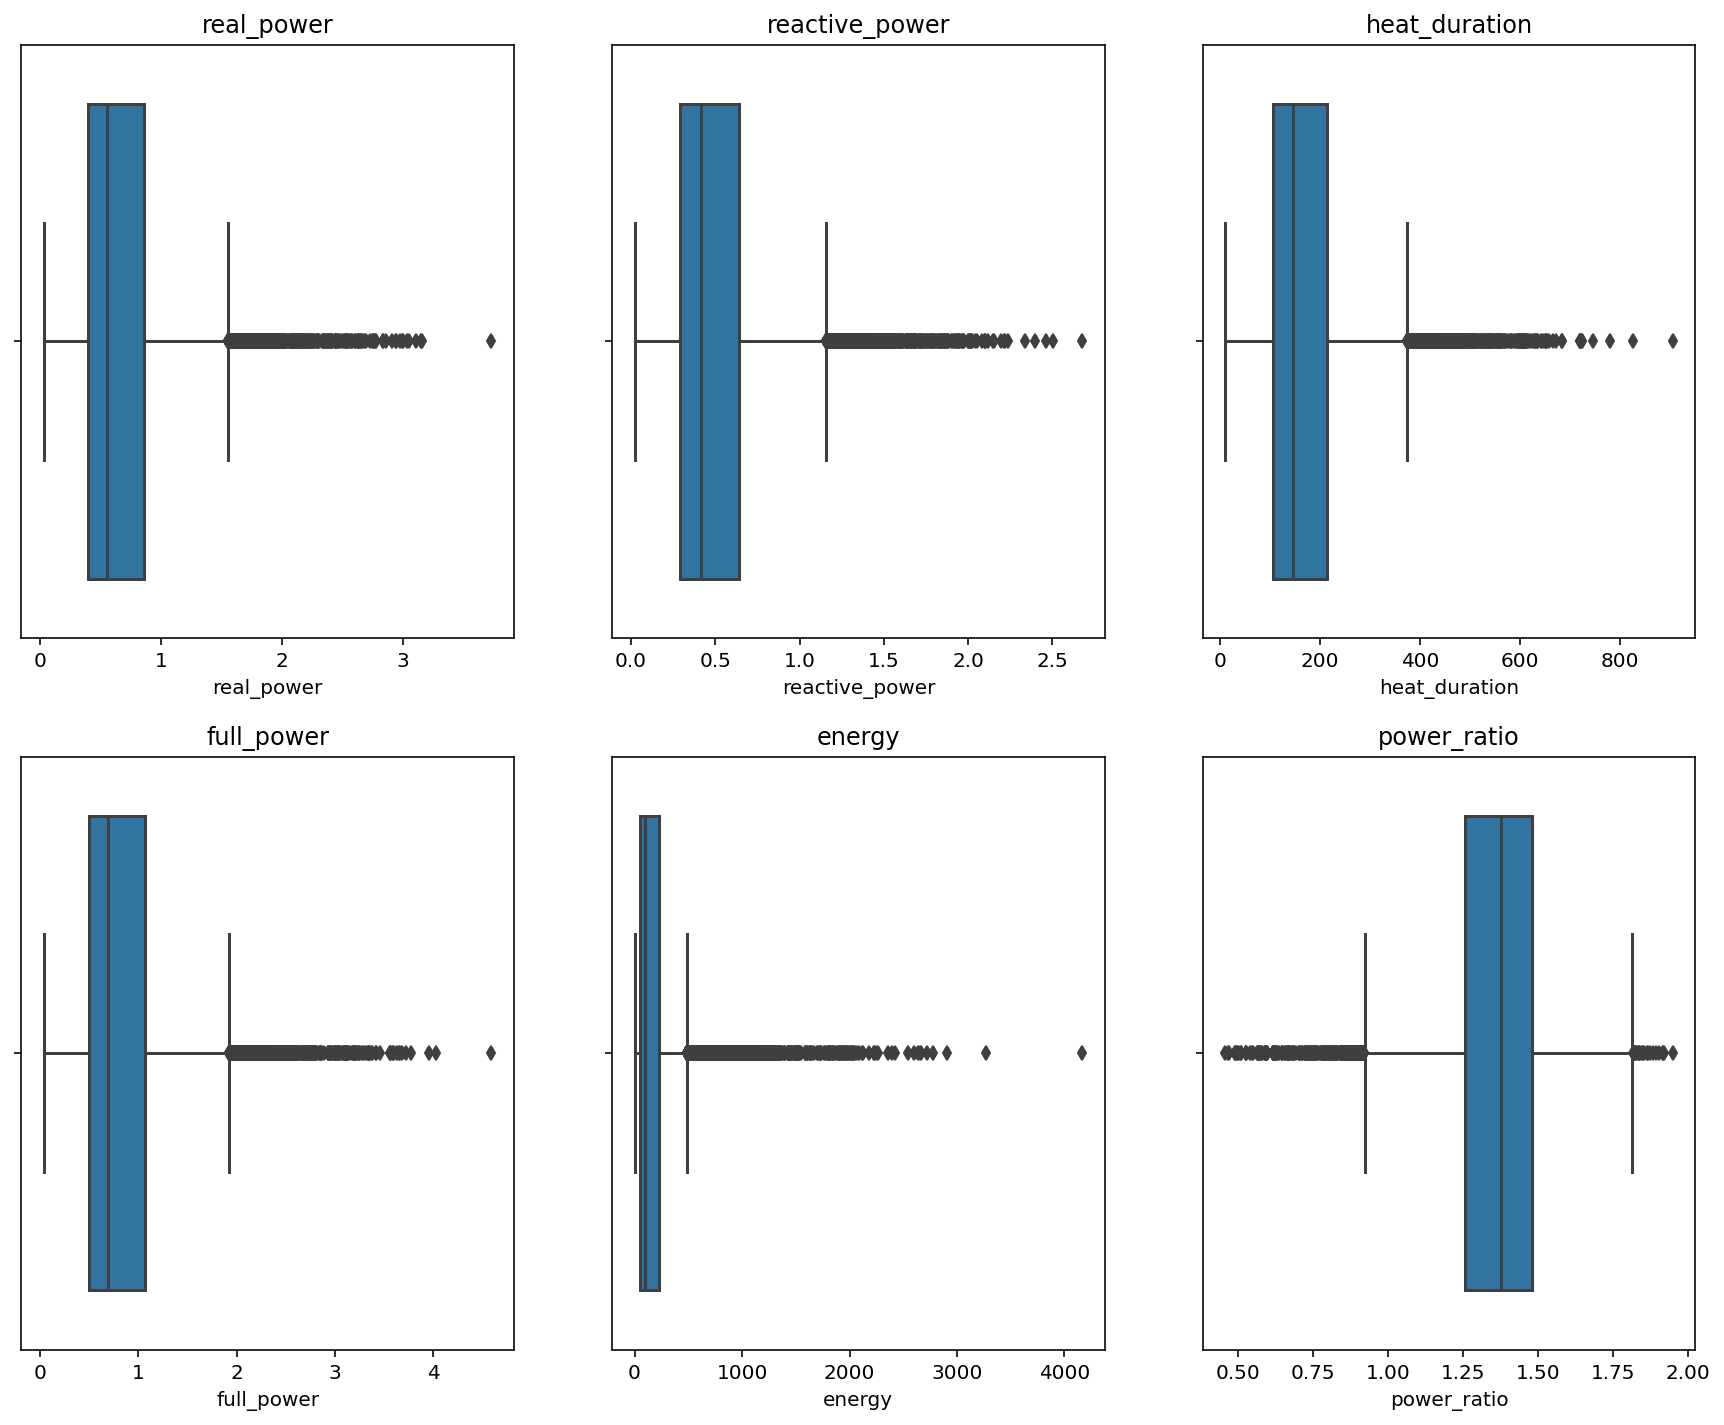

In [40]:
plt.figure(figsize=(15, 12))
for col, i in zip(data_arc.columns[3:-1], range(len(data_arc.columns[3:-1]))):
    plt.subplot(2, 3, i + 1)
    plt.title(col)
    sns.boxplot(data_arc[col])
plt.show();

We group by batch number, as columns - the number of heats, as values we leave "energy" and
" power_ratio"  
Группируем по номеру партии, в качестве столбцов - номера нагревов, в качестве значений оставляем "energy" и 
"power_ratio"

In [41]:
data_arc_pivot_full = pd.pivot_table(
    data_arc.query("heat_duration< 800 and full_power<4 and energy<4000"),
    index="key",
    columns="heating_number",
    values=[
        "energy",
        "power_ratio",
    ],
)
data_arc_pivot_full.head(3)

energy                                                  \
heating_number          1           2           3           4           5    
key                                                                          
1               272.149755  177.416785  154.118502  719.221394  119.471318   
2                71.452170  532.066853   72.782394  204.932148         NaN   
3               351.827647   71.433200   55.387306   27.252408   19.166216   

                                    ... power_ratio                          \
heating_number  6   7   8   9   10  ...          7   8   9   10  11  12  13   
key                                 ...                                       
1              NaN NaN NaN NaN NaN  ...         NaN NaN NaN NaN NaN NaN NaN   
2              NaN NaN NaN NaN NaN  ...         NaN NaN NaN NaN NaN NaN NaN   
3              NaN NaN NaN NaN NaN  ...         NaN NaN NaN NaN NaN NaN NaN   

                            
heating_number  14  15  16  
key                         
1              NaN NaN NaN  
2              NaN NaN NaN  
3              NaN NaN NaN  

[3 rows x 32 columns]

For convenience, rename the columns and fill in the missing values with zeros:  
Для удобства переименовываем столбцы и заполняем отсутствующие значения нулями:

In [42]:
list_columns = []
for i in data_arc_pivot_full.columns:
    list_columns.append(i[0] + str(i[1]))
data_arc_pivot_full.columns = list_columns
data_arc_pivot_full = data_arc_pivot_full.fillna(0)
data_arc_pivot_full.head(3)

energy1     energy2     energy3     energy4     energy5  energy6  \
key                                                                        
1    272.149755  177.416785  154.118502  719.221394  119.471318      0.0   
2     71.452170  532.066853   72.782394  204.932148    0.000000      0.0   
3    351.827647   71.433200   55.387306   27.252408   19.166216      0.0   

     energy7  energy8  energy9  energy10  ...  power_ratio7  power_ratio8  \
key                                       ...                               
1        0.0      0.0      0.0       0.0  ...           0.0           0.0   
2        0.0      0.0      0.0       0.0  ...           0.0           0.0   
3        0.0      0.0      0.0       0.0  ...           0.0           0.0   

     power_ratio9  power_ratio10  power_ratio11  power_ratio12  power_ratio13  \
key                                                                             
1             0.0            0.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0            0.0   
3             0.0            0.0            0.0            0.0            0.0   

     power_ratio14  power_ratio15  power_ratio16  
key                                               
1              0.0            0.0            0.0  
2              0.0            0.0            0.0  
3              0.0            0.0            0.0  

[3 rows x 32 columns]

<a id='data_gas'></a>

### data_gas — data on gas purging of the alloy / данные о продувке сплава газом

In [43]:
describe_ds(data_gas)

General information about the dataset \ Общая информация о датасете

   key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

Number of missing values \ Количество пропусков
 key      0
Газ 1    0
dtype: int64

Statistics \ Статистика
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Number of unique batch numbers / Количество уникальных номеров партии 3239

Number of duplicates / Количество ду

__Summary:__
The table has 3239 rows and 3239 unique batch numbers, more than the table with data on the supply of bulk materials, 2 columns.

- __key__ - unique batch number,
- __Газ 1__ - data on the purge of the alloy with gas, it is not clear what this value is, let's assume that the volume.

The average gas volume is 11, the minimum is 0.008, the maximum is 77, and the standard deviation is 6.

There are no duplicates, no omissions.

It is necessary to rename the column " Gas 1"

__Выводы:__  
В таблице 3239 строк и 3239 уникальных номеров партии, больше, чем в таблице с данными о подаче сыпучих материалов, 2 столбца.

 - __key__ - уникальный номер партии,
 - __Газ 1__ - данные о продувке сплава газом, не понятно, какая это величина, предположим, что объем.  
 
Среднее значение объема газа - 11, минимальное - 0,008, максимальное - 77, стандартное отклонение 6.  

Дубликатов нет, пропусков нет.

Стоит переименовать столбец "Газ 1"

In [44]:
data_gas.columns = ["key", "gas"]

Let's look at the charts:  
Посмотрим на графики:

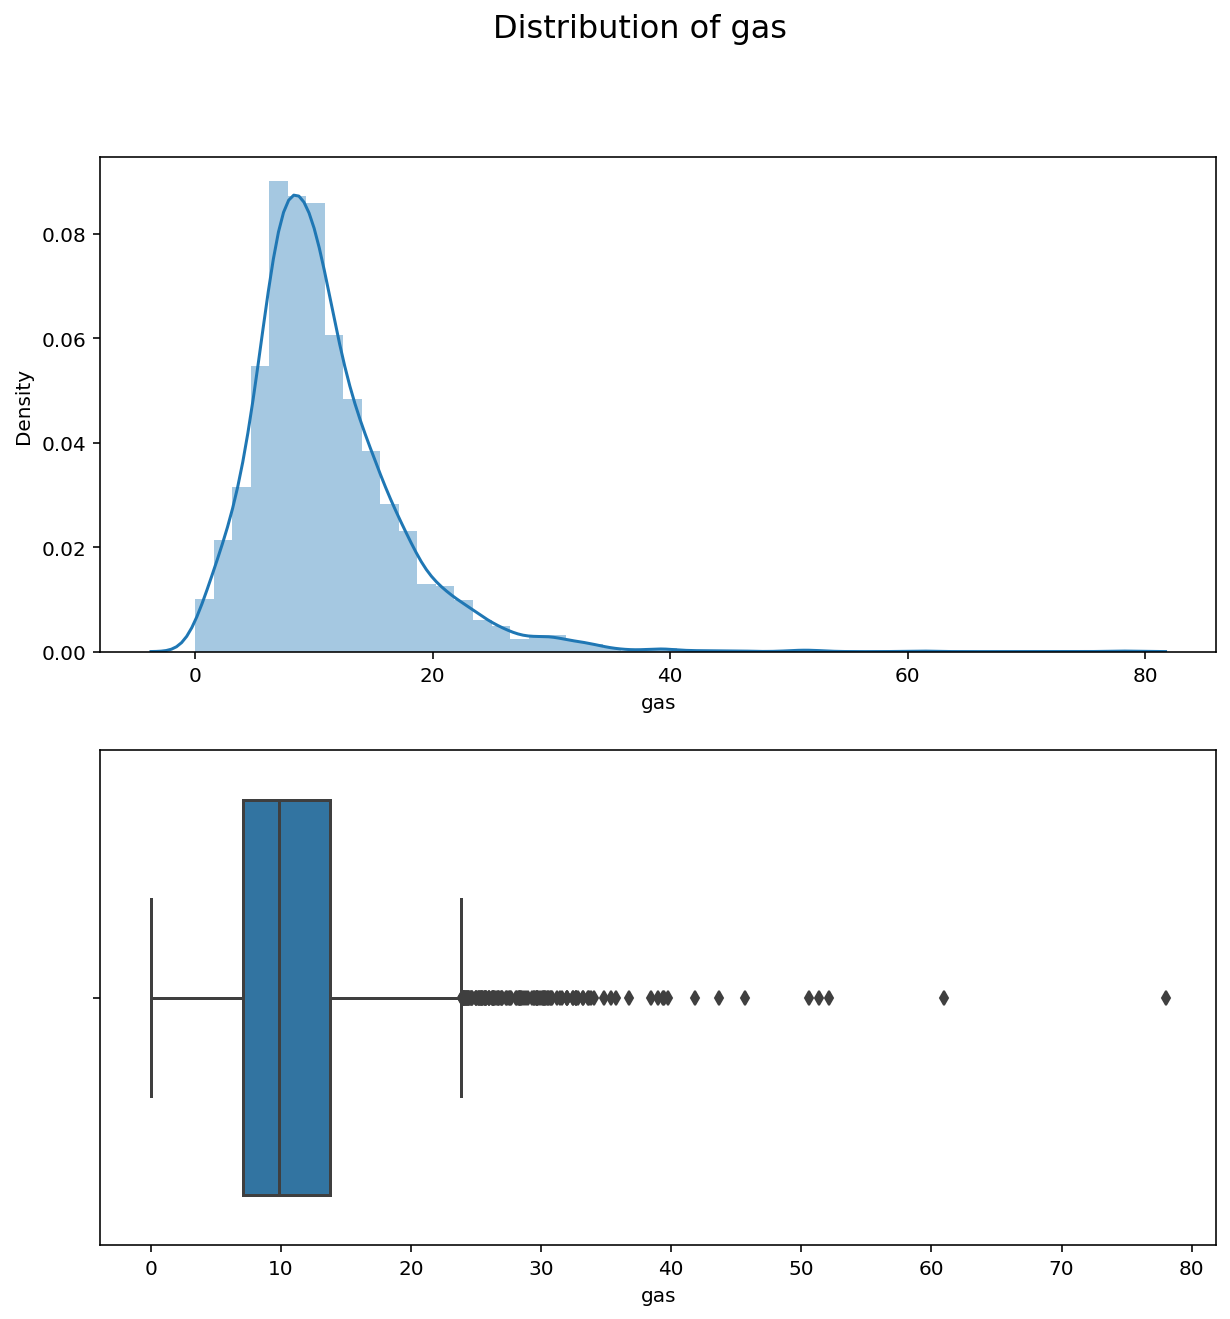

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.suptitle("Distribution of gas", fontsize=16)
sns.distplot(data_gas["gas"], ax=ax[0])
sns.boxplot(data_gas["gas"], ax=ax[1])
plt.show();

The distribution is similar to normal, the main part of the values lies in the range of 0-40, the average is 11 with a standard deviation of 6, there are some large values that can be outliers.
Let's see how many total values are greater than 40:  
Распределение похоже на нормальное, основная часть значений лежит в пределах 0-40, среднее 11 со стандартным отклонением 6, есть некоторое количество больших значений, которые могут быть выбросами.  
Посмотрим, сколько всего значений больше 40:

In [46]:
sum(data_gas["gas"] > 40)
(sum(data_gas["gas"] > 40) / data_gas.shape[0]) * 100

8

0.2469898116702686

There are only 8 values, which is 0.24% of all the batches, so it's better to delete them.  
Всего 8 значений, это 0,24% от всех партий, стоит их удалить.

In [47]:
data_gas.index = data_gas["key"]
data_gas = data_gas.drop("key", axis=1)

In [48]:
data_gas = data_gas.query("gas < 40")

<a id='data_wire'></a>

### data_wire — data on wire materials (volume) / данные о проволочных материалах (объём)

In [49]:
describe_ds(data_wire)

General information about the dataset \ Общая информация о датасете

   key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-nul

__Summary:__

The table has 3081 rows and 3081 unique batch numbers, 10 columns.

- __key__ - unique batch number,
- __Wire 1 - Wire 9__ - data about wire materials (volume), it is more convenient to rename.

There are no duplicates, there are a lot of omissions, because not all types of wire materials were added to all batches.
- There is only 1 value in the "Wire 5" column.
- The average volume is very different for different wire materials.
- Most often, type 1 wire is added (3055 times), in second place-type 2 wire (1079 times), all other types are added rarely.

__Выводы:__  

В таблице 3081 строк и 3081 уникальных номеров партии, 10 столбцов.

 - __key__ - уникальный номер партии,
 - __Wire 1 - Wire 9__ - данные о проволочных материалах (объём), удобнее переименовать.

Дубликатов нет, пропусков много, поскольку не во все партии добавляли все типы проволочных материалов.
 - В столбце "Wire 5" всего 1 значение.
 - Средний объем очень сильно отличается для разных проволочных материалов.
 - Чаще всего добавляют проволоку 1 типа (3055 раз), на втором месте - проволока второго типа (1079 раз), все остальные типы добавляют редко.


In [50]:
columns_wire = []
for i in data_wire.columns.str.lower():
    columns_wire.append("_".join(i.split()))
data_wire.columns = columns_wire

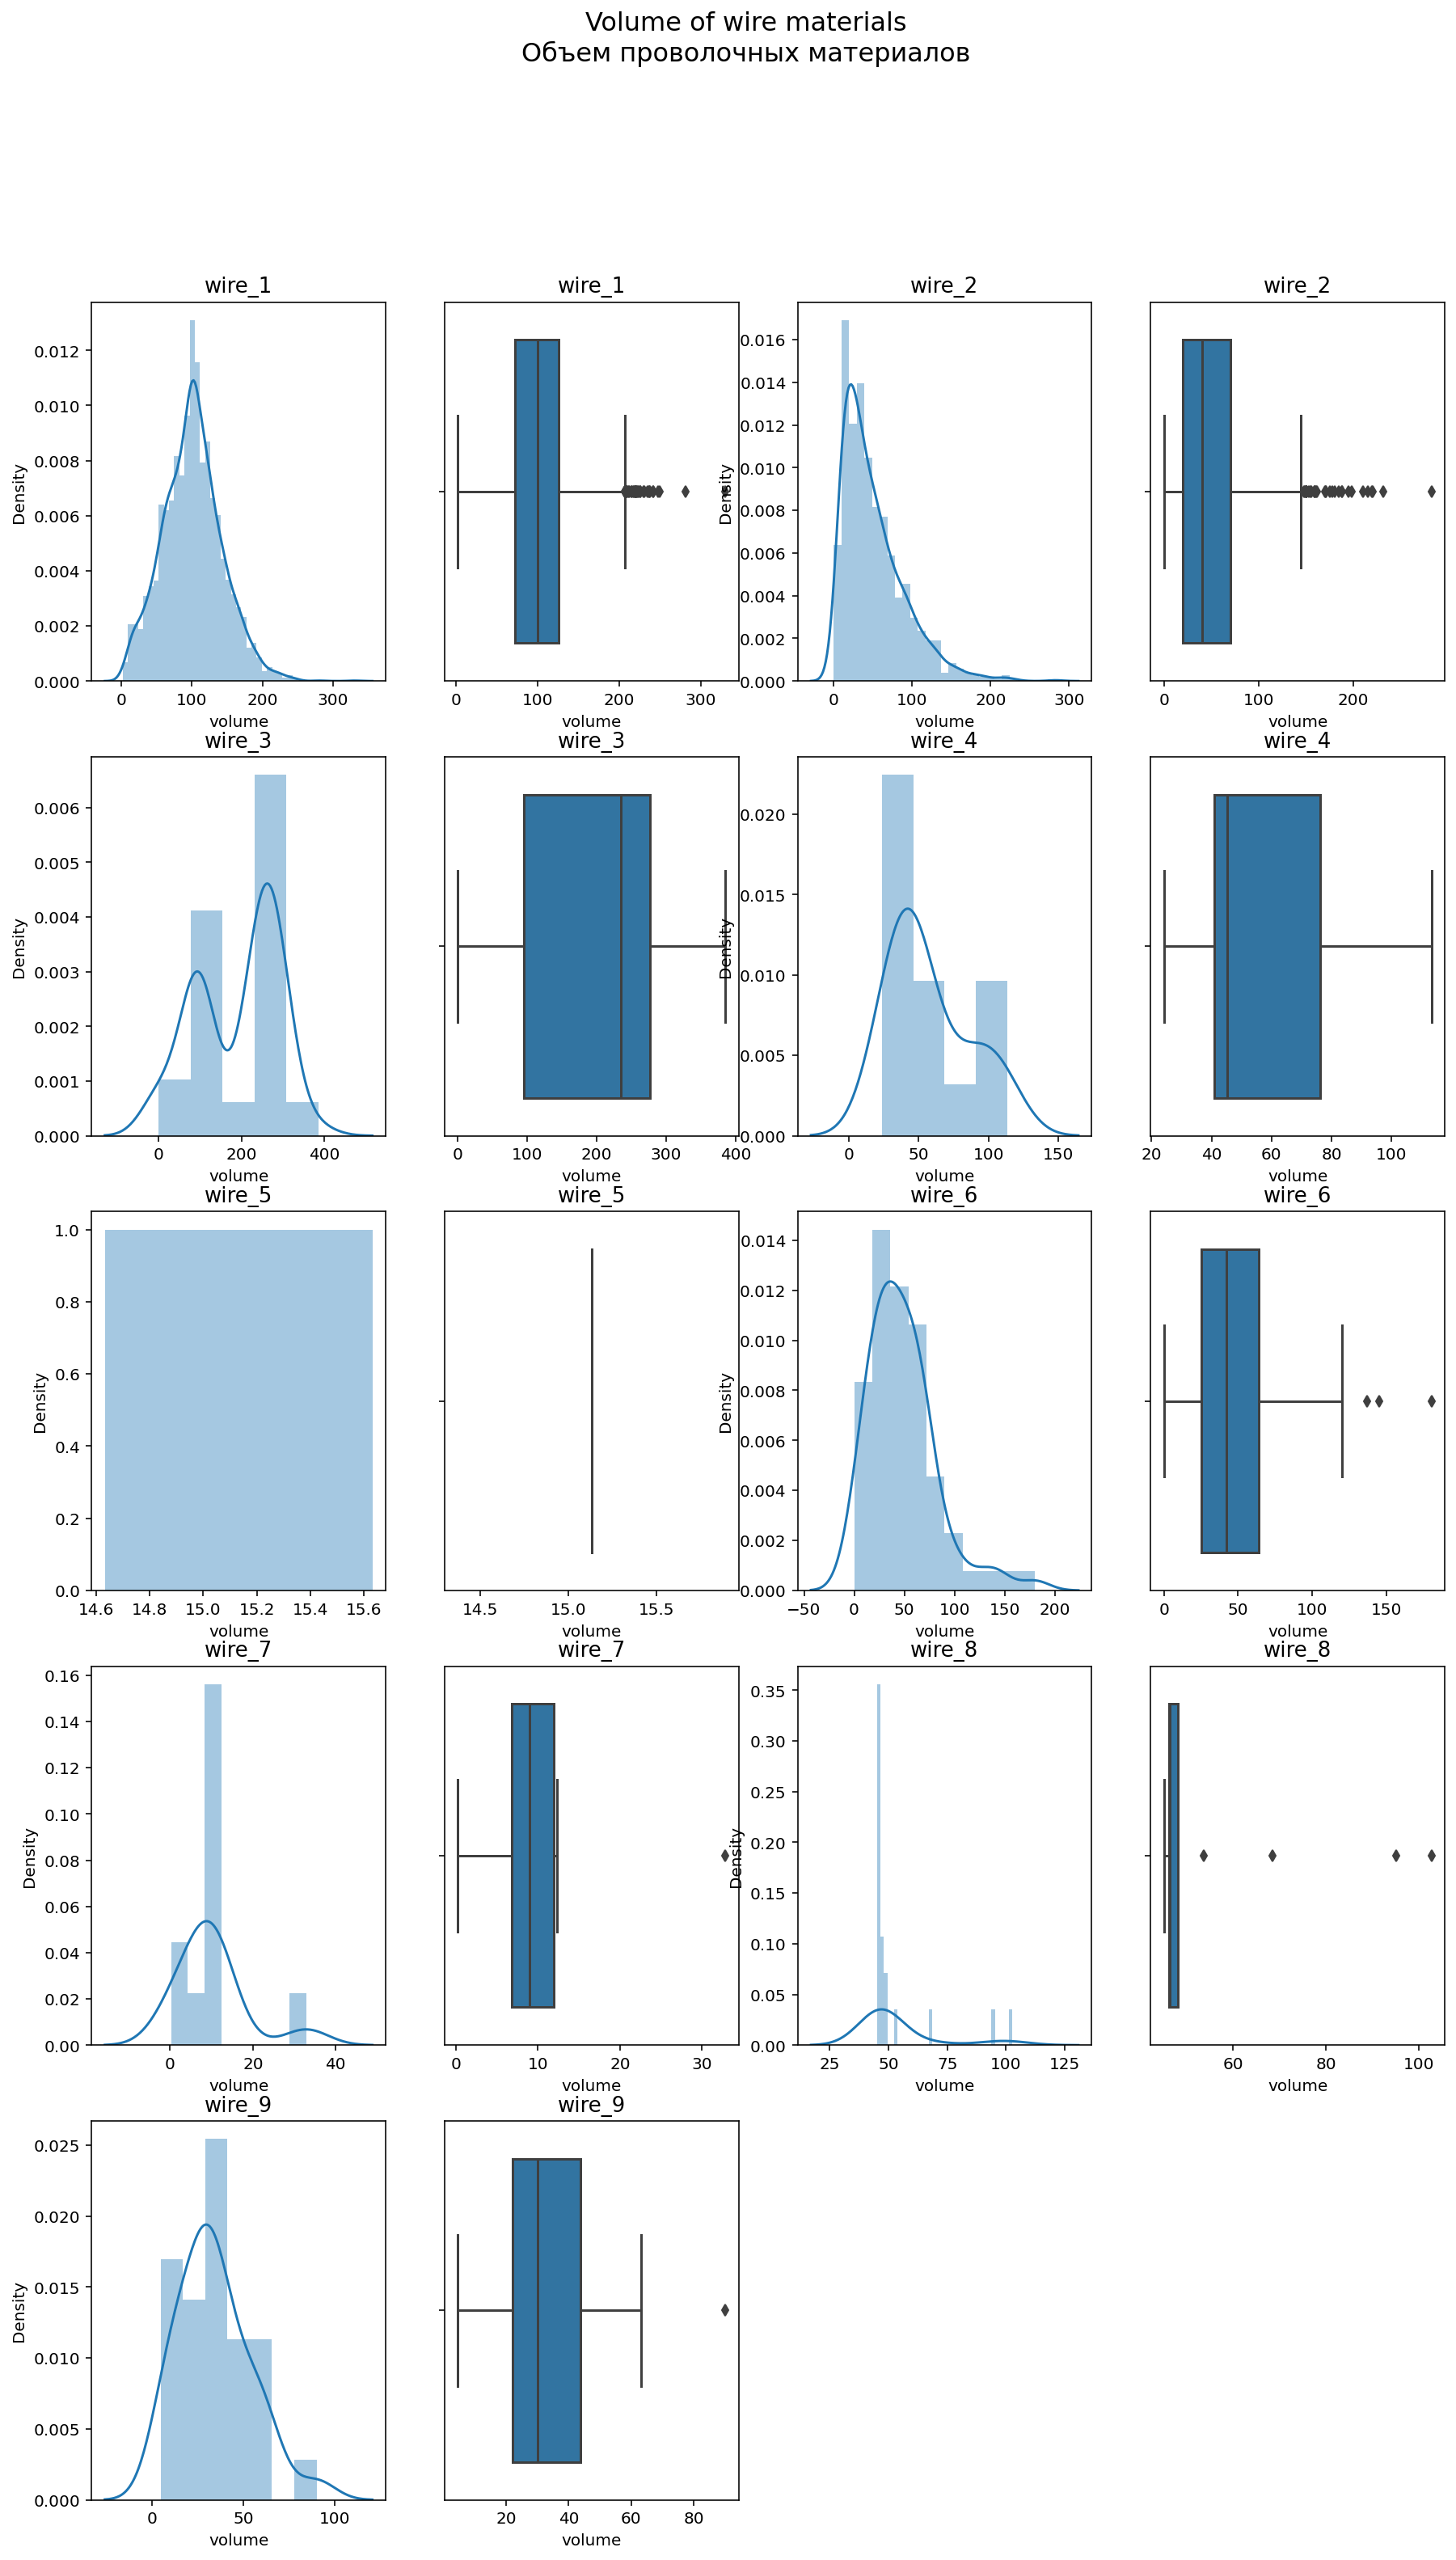

In [51]:
fig = plt.figure(figsize=(15, 25))
plt.suptitle("Volume of wire materials\nОбъем проволочных материалов", fontsize=16)
for column, i in zip(data_wire.columns[1:], range(1, 19, 2)):
    plt.subplot(5, 4, i)
    plt.title(column, fontsize=13)
    sns.distplot(data_wire[column].dropna())
    plt.xlabel("volume")
    plt.subplot(5, 4, i + 1)
    plt.title(column, fontsize=13)
    sns.boxplot(data_wire[column].dropna())
    plt.xlabel("volume")
plt.show();

Only in the first type of wire material, the distribution is similar to normal.
Some types have outliers.

Based on the results of studying the models, it was found out that, as in the case of bulk materials, the removal or replacement of emissions negatively affects the results, so we leave it as it is, fill in the gaps with zeros and set the batch number as the index.

Additionally, we calculate the frequency of adding different wires.

Только у первого типа проволочного материала распределение похоже на нормальное.  
В некоторых типах встречаются выбросы. 

По результатам изучения моделей удалось выяснить, что, как и в случае с сыпучими материалами, удаление или замена выбросов отрицательно сказываются на результатах, поэтому оставляем как есть, заполняем пропуски нулями и в качестве индекса устанавливаем номер партии.  

Дополнительно считаем частоту добавления разных проволок.

In [52]:
wire_frequency = round(
    data_wire.iloc[:, 1:].notna().sum() / data_wire.shape[0] * 100, 2
).sort_values(ascending=False)
wire_frequency.head()

wire_1    99.16
wire_2    35.02
wire_6     2.37
wire_3     2.04
wire_9     0.94
dtype: float64

In [53]:
data_wire = data_wire.fillna(0)
data_wire.index = data_wire["key"]
data_wire = data_wire.drop("key", axis=1)

<a id='data_wire_time'></a>

### data_wire_time - data on wire materials (time) / данные о проволочных материалах (время)

In [54]:
describe_ds(data_wire_time)

General information about the dataset \ Общая информация о датасете

   key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3

__Summary:__
The table has 3081 rows and 3081 unique batch numbers, 10 columns.

- __key__ - unique batch number,
- __Wire 1 - Wire 9__ - data about the time of adding wire materials, type "object".

There are no duplicates, there are a lot of omissions, because not all types of wire materials were added to all batches.

This table will not be needed for further calculations.

__Выводы:__  
В таблице 3081 строк и 3081 уникальных номеров партии, 10 столбцов.

 - __key__ - уникальный номер партии,
 - __Wire 1 - Wire 9__ - данные о времени добавления проволочных материалов, типа "object".

Дубликатов нет, пропусков много, поскольку не во все партии добавляли все типы проволочных материалов.

Эта таблица для дальнейших расчетов не понадобится.

<a id='data_temp'></a>

### data_temp — temperature measurement results / результаты измерения температуры

In [55]:
describe_ds(data_temp)

General information about the dataset \ Общая информация о датасете

   key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

Number of missing values \ Количество пропусков
 key                0
Время замера       0
Температура     2901
dtype: int64

Statistics \ Статистика
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min 

__Summary:__

The table has 15907 rows and 3216 unique batch numbers, 3 columns.

- __key__ - unique batch number,
- __Время замера__ - data about the temperature measurement time, type "object".
- __Температура__ - temperature data, type "float64", is better to make  "int".

The average temperature is 1592, the standard deviation is 21, the minimum is 1191, and the maximum is 1705.

There are no duplicates, 2901 missing values in the __Температура__ column.

It is better to rename the columns.

__Выводы:__  

В таблице 15907 строк и 3216 уникальных номеров партии, 3 столбца.

 - __key__ - уникальный номер партии,
 - __Время замера__ - данные о времени замера температуры, типа "object".
 - __Температура__ - данные о температуре, типа "float64", лучше перевести в "int".
 
Средняя температура 1592, стандартное отклонение 21, минимальная - 1191, максимальная - 1705.

Дубликатов нет, 2901 пропуск в столбце __Температура__.

Столбцы лучше переименовать.

In [56]:
data_temp.columns = ["key", "temp_time", "temp"]

Deleting the rows for which there is no temperature data.  
Удаляем строки, для которых нет данных по температуре.

In [57]:
data_temp = data_temp.dropna().reset_index(drop=True)

Date to datetime.  
Переведем дату в нужный формат

In [58]:
data_temp["temp_time"] = pd.to_datetime(
    data_temp["temp_time"], format="%Y-%m-%d %H:%M:%S"
)

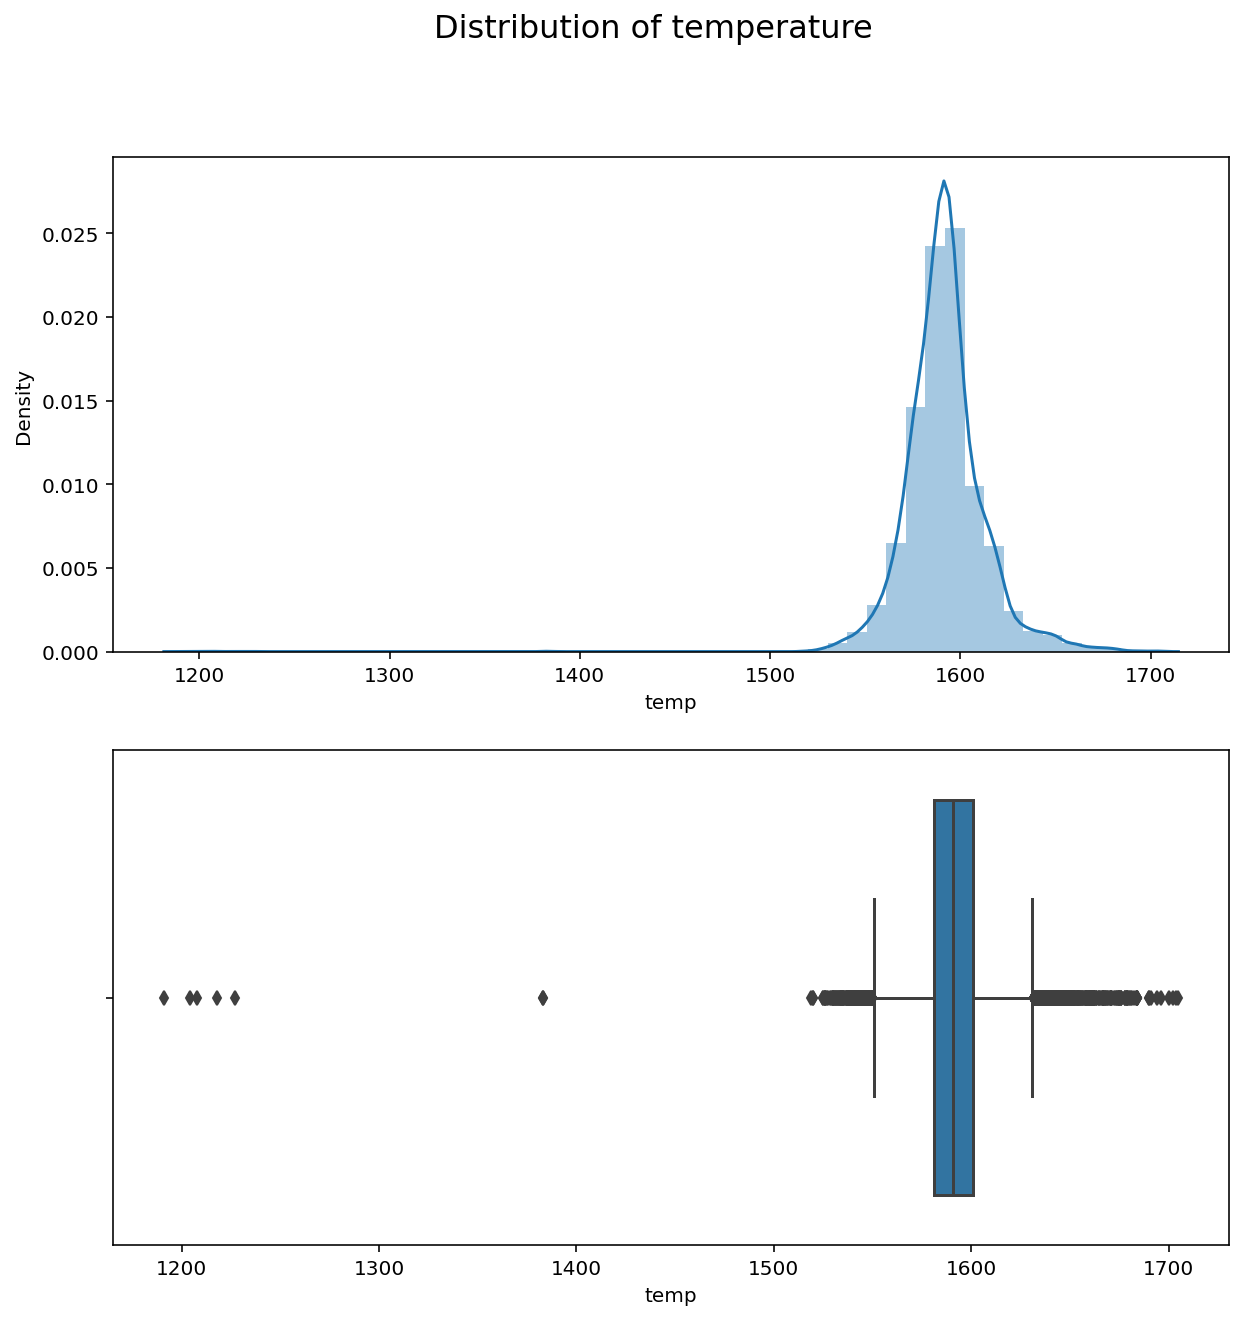

In [59]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
plt.suptitle("Distribution of temperature", fontsize=16)
sns.distplot(data_temp["temp"], ax=axs[0])
sns.boxplot(data_temp["temp"], ax=axs[1])
plt.show();

It seems that the temperature values are less than 1500 - measurement errors or filling in the table. The melting point of the steel is 1450-1520 degrees, so it looks more like an error.  
Let's look at these lines:  

Похоже, что значения температуры меньше 1500 - ошибки измерения или заполнения таблицы. Температура плавления стали 1450—1520 градусов, поэтому больше похоже на ошибку.  
Посмотрим на эти строки:

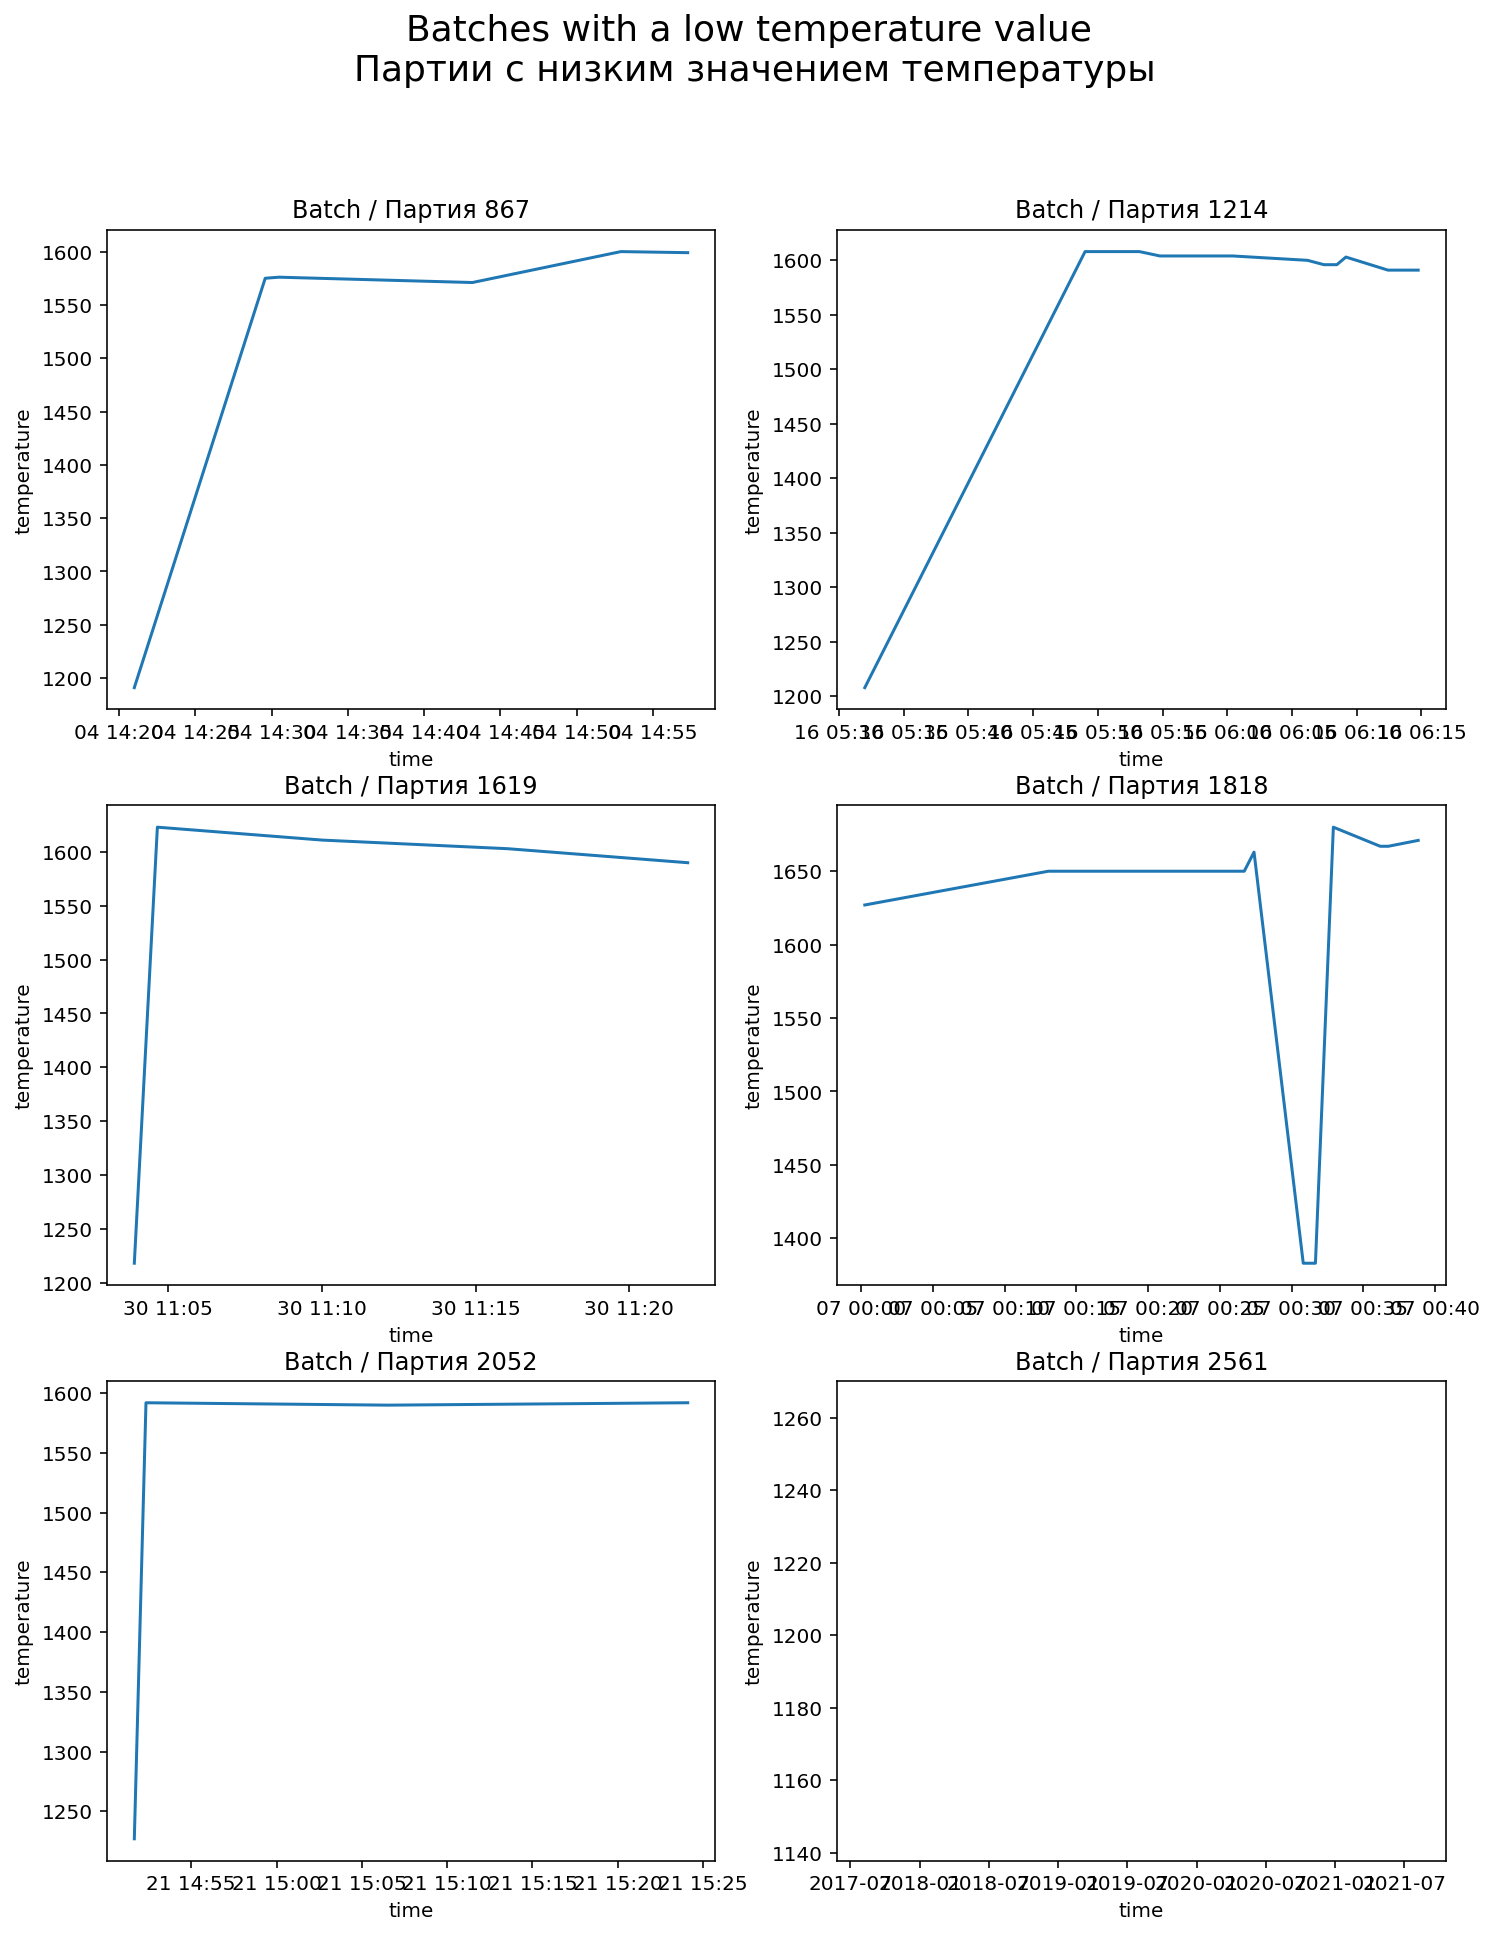

In [60]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
plt.suptitle("Batches with a low temperature value \nПартии с низким значением температуры", fontsize=18)
for key_, i in zip(data_temp[data_temp["temp"] < 1500]["key"].unique(), range(1, 7)):
    plt.subplot(3, 2, i)
    plt.title("Batch / Партия " + str(key_), fontsize=12)
    plt.plot(
        data_temp[data_temp["key"] == key_]["temp_time"],
        data_temp[data_temp["key"] == key_]["temp"],
    )
    plt.xlabel("time")
    plt.ylabel("temperature")
plt.show();

Very similar to errors.
Since in most cases the first temperature is incorrectly measured, we will delete these lines in the future.  
Let's see how many measurements there are for all batches:

Очень похоже на ошибки.  
Поскольку в большинстве случаев неправильно измеряна первая температура, то эти строки в дальнейшем удалим.  
Посмотрим, сколько измерений есть для всех партий:

In [61]:
print(
    "Number of temperature measurements for different batches:\nКоличество измерений температуры для разных партий: \n",
    *sorted(data_temp["key"].value_counts().unique())
)
print(
    "\nNumber of batches with one temperature measurement:\nКоличество партий с одним измерением температуры:",
    sum(data_temp["key"].value_counts() == 1),
)

Number of temperature measurements for different batches:
Количество измерений температуры для разных партий: 
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16

Number of batches with one temperature measurement:
Количество партий с одним измерением температуры: 741


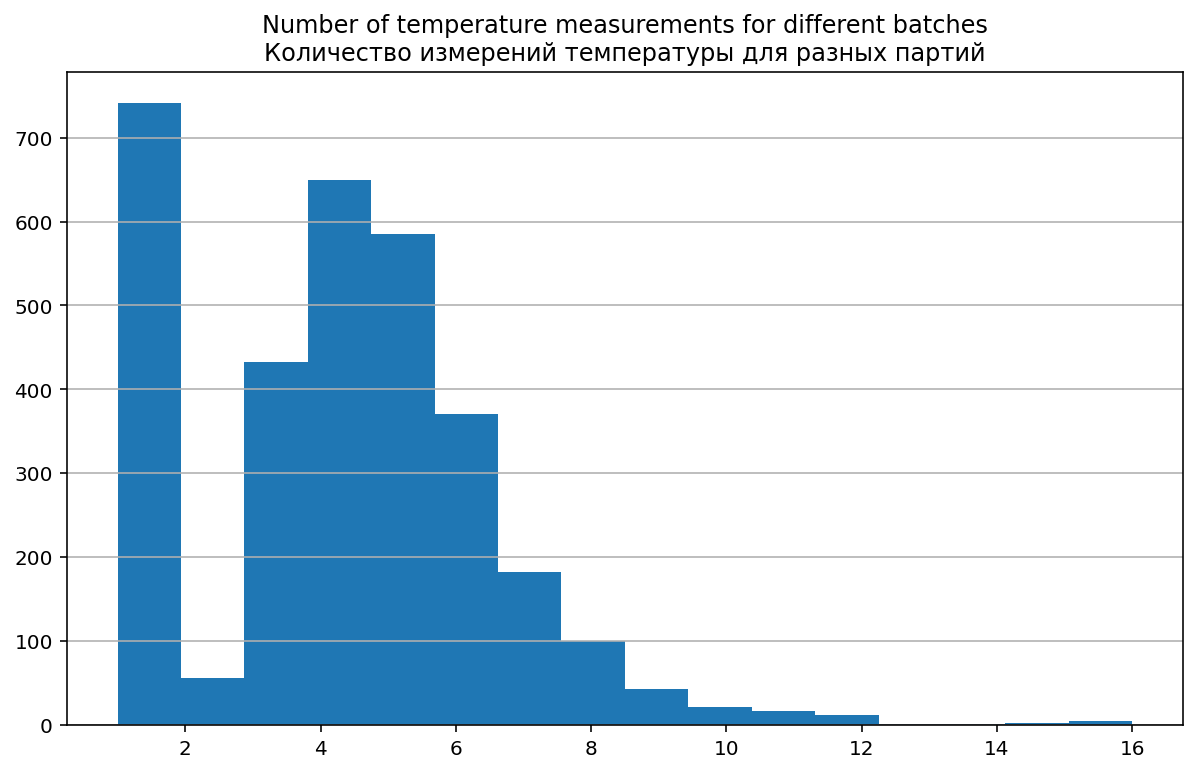

In [62]:
plt.figure(figsize=(10, 6))
plt.title("Number of temperature measurements for different batches\nКоличество измерений температуры для разных партий")
plt.hist(data_temp["key"].value_counts(), bins=16)
plt.grid(True, axis="y")
plt.show;

For different batches, there are from 1 to 16 temperature measurements, and batches with a single measurement are 741.
We don't need data with a single temperature measurement, because to train the model, we need the initial batch temperature and the final batch temperature as the object for prediction, so we delete batches for which there is only one measurement.  
Для разных партий есть от 1 до 16 измерений температуры, причем партий с единственным измерением - 741.  
Данные с одним измерением температуры нам не нужны, поскольку для обучения модели нам нужны начальная температура партии и конечная в качестве объекта для предсказания, поэтому удаляем партии, для которых есть только одно измерение.

In [63]:
list_keys_temp_one = list(
    data_temp["key"].value_counts()[data_temp["key"].value_counts() == 1].index
)
data_temp = data_temp.query("key not in @list_keys_temp_one")

For training, we need the first and last temperature. Since we do not know whether the values are sorted in chronological order or not, we first sort by measurement time, and then take the first and last values for each batch number.  
Для обучения нам нужны первая и последняя температура. Поскольку нам не известно, отсортированы значения в хронологическом порядке или нет, то сначала сортируем по времени измерения, а потом для каждого номера партии берем первое и последнее значение.

In [64]:
temperature = (
    data_temp.sort_values(by="temp_time")
    .groupby("key")
    .agg({"temp": ["first", "last"]})
)
temperature.head(3)

temp        
      first    last
key                
1    1571.0  1613.0
2    1581.0  1602.0
3    1596.0  1599.0

In [65]:
temperature.columns = ["first_temp", "last_temp"]

Since we have extremely low first temperatures for several batches, which are similar to errors, we delete these batches from the data.  
Поскольку для нескольких партий у нас есть экстремально низкие первые температуры, которые похожи на ошибки, то удаляем эти партии из данных.

In [66]:
temperature = temperature.query("first_temp > 1500")

Now that the data is ready, let's look at the distribution of the initial and final temperatures:  
Теперь, когда данные подготовлены, посмотрим на распределение начальных и конечных температур:

In [67]:
temperature.describe(percentiles=(0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99))

first_temp    last_temp
count  2471.000000  2471.000000
mean   1589.012950  1595.339943
std      25.004369    16.035215
min    1519.000000  1541.000000
1%     1533.000000  1570.000000
5%     1550.000000  1576.000000
10%    1559.000000  1580.000000
25%    1572.000000  1587.000000
50%    1588.000000  1593.000000
75%    1605.000000  1599.000000
90%    1622.000000  1613.000000
95%    1633.000000  1621.000000
99%    1651.300000  1661.300000
max    1679.000000  1700.000000

The average value of the first temperature is 1589 degrees, the standard deviation is 25, the minimum is 1519, the maximum is 1679.
The average value of the final temperature is 1595 degrees, the standard deviation is 16, the minimum is 1541, the maximum is 1700.  
Среднее значение начальной температуры - 1589 градусов, стандартное отклонение 25, минимальная 1519, максимальная - 1679.  
Среднее значение конечной температуры - 1595 градусов, стандартное отклонение 16, минимальная 1541, максимальная - 1700.

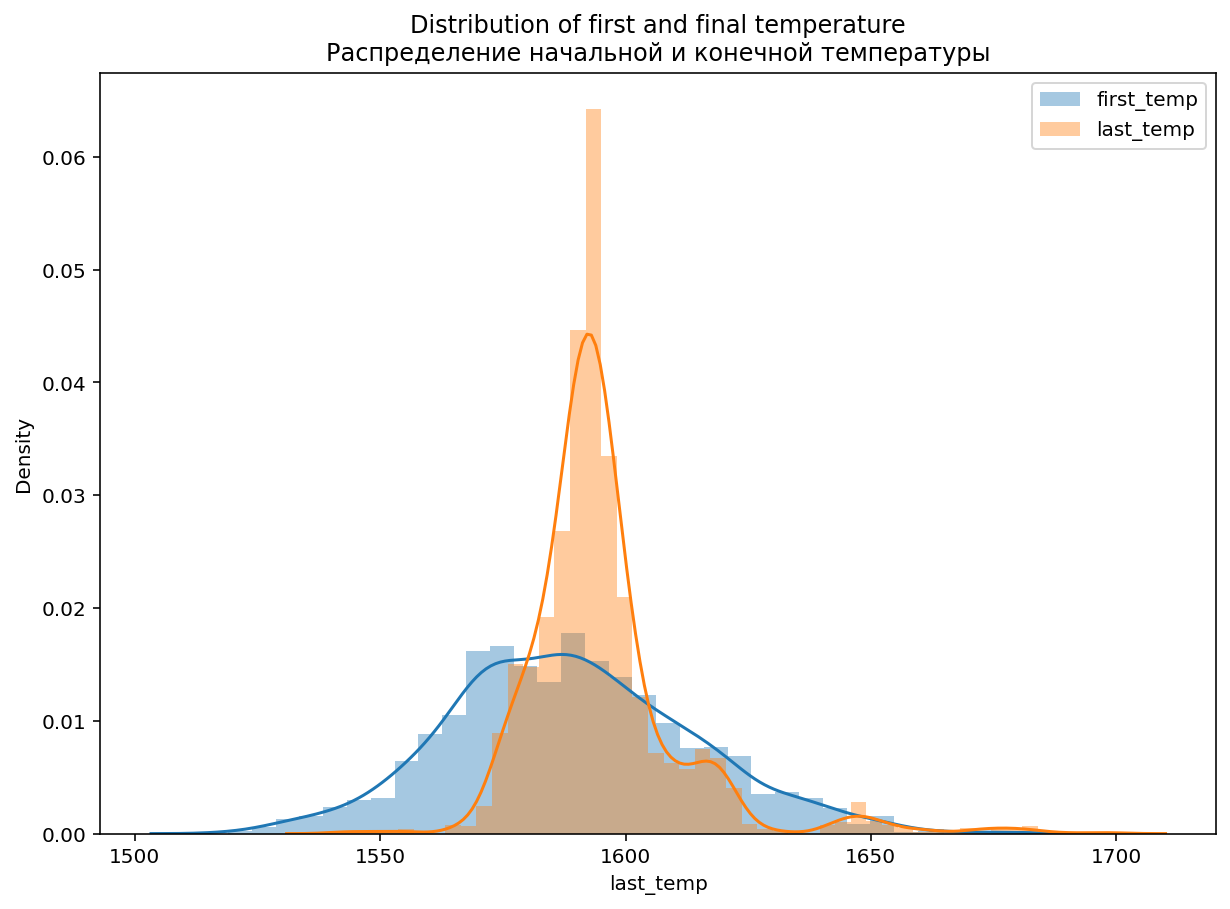

In [68]:
plt.figure(figsize=(10, 7))
plt.title("Distribution of first and final temperature\nРаспределение начальной и конечной температуры")
sns.distplot(temperature["first_temp"], label="first_temp", kde=True)
sns.distplot(temperature["last_temp"], label="last_temp")
plt.legend()
plt.show();

The initial temperatures lie in a wider range of values and more evenly, for the final ones the range is slightly narrower, while more often the required temperature lies in the range of 1575-1625 degrees.  
Начальные температуры лежат в более широком диапазоне значений и более равномерно, для конечных диапазон чуть уже, при этом чаще требуемая температура лежит в диапазоне 1575 - 1625 градусов.  

<a id='prepare'></a>

## Data preparation / Подготовка данных

Function for joining tables:
- combines tables by the join method (in all intermediate tables we have indexes-batch numbers) with how='left', since we do not need rows without temperature values,
- if full == True, then the resulting table includes data_arc_pivot_full, if full == False, then data_arc_pivot,
- deletes rows that have gaps after merging
- deletes columns that have less than 10 values
- outputs columns with a correlation coefficient greater than 0.95
- returns the final table  

Функция для объединения таблиц:
 - объединяет таблицы методом join (во всех промежуточных таблицах у нас индексы- номера партии) с параметром how='left', поскольку нам не нужны строки без значений температуры,
 - если full == True, то в итоговую таблицу включается data_arc_pivot_full, если full == False, то data_arc_pivot,
 - удаляет строки, в которых есть пропуски после объединения,
 - удаляет столбцы, в которых меньше 10 значений,
 - выводит столбцы с коэффициентом корреляции больше 0.95
 - возвращает итоговую таблицу

In [69]:
def join_data(full=False):
    if full == False:
        data = temperature.join(
            [data_bulk, data_arc_pivot, data_gas, data_wire], how="left"
        )
    elif full == True:
        data = temperature.join(
            [data_bulk, data_arc_pivot_full, data_gas, data_wire], how="left"
        )
    data = data.dropna(axis=0)
    # columns, where less than 10 values
    cols_data = []
    for col in data.columns:
        if data.shape[0] - sum(data[col] == 0) < 10:
            cols_data.append(col)
    data = data.drop(cols_data, axis=1)
    corr_coef = []
    for i in data.corr().columns:
        for j in data.corr().index:
            if i != j:
                if abs(data.corr().loc[j, i]) > 0.95:
                    corr_coef.append([j, i, data.corr().loc[j, i]])
    print(corr_coef)
    return data

For most models, cross-validation will be used, so the function for splitting data into training and test samples has two split varants - with and without a valid sample. For both options, the data is standardized.  
Для большинства моделей будет использоваться кросс-валидация, поэтому в функции для разбиения данных на обучающую и тестовую выборки есть два варанта разбиения - с валидационной выборкой и без. Для обоих вариантов данные стандартизируются.

In [70]:
def split_data(data, train_size=0.7, valid=False, random_state=572):
    target_data = data["last_temp"]
    feature_data = data.drop("last_temp", axis=1)
    if valid == True:
        train_x, test_valid_x, train_y, test_valid_y = train_test_split(
            feature_data, target_data, random_state=random_state, train_size=train_size
        )
        valid_x, test_x, valid_y, test_y = train_test_split(
            test_valid_x, test_valid_y, random_state=random_state, train_size=0.5
        )
        scaler = StandardScaler()
        scaler.fit(train_x)
        train_x = pd.DataFrame(scaler.transform(train_x), columns=feature_data.columns)
        valid_x = pd.DataFrame(scaler.transform(valid_x), columns=feature_data.columns)
        test_x = pd.DataFrame(scaler.transform(test_x), columns=feature_data.columns)
        return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)
    else:
        train_x, test_x, train_y, test_y = train_test_split(
            feature_data, target_data, random_state=random_state, train_size=train_size
        )
        scaler = StandardScaler()
        scaler.fit(train_x)
        train_x = pd.DataFrame(scaler.transform(train_x), columns=feature_data.columns)
        test_x = pd.DataFrame(scaler.transform(test_x), columns=feature_data.columns)
        return (train_x, train_y), (test_x, test_y)

A function for filling in a pivot table, and displaying МАЕ on validation/cross-validation and optimal model parameters.  
Функция для заполнения сводной таблицы, и вывода МАЕ на валидации/кросс-валидации и оптимальных параметров модели.

In [71]:
summary = pd.DataFrame()


def fill_summary(model, model_name, cv=True, data="full", fill_test=True, plot=False):
    if data == "full":
        if cv == True:
            test_data = test_full
        else:
            valid = valid_v_full
            test_data = test_v_full
    else:
        if cv == True:
            test_data = test
        else:
            valid = valid_v
            test_data = test_v

    if fill_test == True:
        if cv == True:
            summary.loc["MAE_test", model_name] = mean_absolute_error(
                test_data[1], model.best_estimator_.predict(test_data[0])
            ).round(3)
        else:
            summary.loc["MAE_test", model_name] = mean_absolute_error(
                test_data[1], model.predict(test_data[0])
            ).round(3)
    elif fill_test == False:
        if cv == True:
            summary.loc["MAE_valid", model_name] = abs(model.best_score_).round(3)
            print("Best params / Лучшие параметры:", model.best_params_)
            print("\nMAE on cross-validation / На кросс-валидации MAE =", abs(model.best_score_).round(3))
        else:
            summary.loc["MAE_valid", model_name] = mean_absolute_error(
                valid[1], model.predict(valid[0])
            ).round(3)
            print(
                "MAE on cross-validation / На валидационной выборке MAE =",
                mean_absolute_error(valid[1], model.predict(valid[0])).round(3),
            )
    return

A function for plotting feature importance for models.  
Функция построения графика важности признаков для моделей.

In [72]:
def plot_importance(importance, model_name):
    col = importance.columns[0]
    top_20 = importance.sort_values(by=col, ascending=False).head(20)
    plt.figure(figsize=(15, 8))
    plt.title("Top 20 feature importances of " + model_name)
    sns.barplot(top_20.index, top_20[col])
    plt.xticks(rotation=45)
    plt.show();

Let's combine the data obtained as a result of preprocessing into the final tables:
- data-table with average and total values for the electrodes,
- data_full-table with grouping by iteration of electrode heating  

Объединим данные, полученные в результате предобработки в итоговые таблицы: 
 - data - таблица с средними и суммарными значениями по электродам,
 - data_full - таблица с группировкой по итерациям нагрева электродами

In [73]:
data = join_data(full=False)
data.shape

[['wire_8', 'bulk_9', 0.9738156584086687], ['bulk_9', 'wire_8', 0.9738156584086687]]


(2301, 29)

The resulting data table has 2301 rows and 29 columns. Columns wire_8 and bulk_9 have a strong positive relationship, the correlation coefficient is 0.97, one of the columns must be deleted.  
В итоговой таблице data 2301 строка и 29 столбцов. Столбцы wire_8 и bulk_9 имеют сильную положительную связь, коэффициент корреляции 0.97, один из столбцов удалим.

In [74]:
data = data.drop("bulk_9", axis=1)

In [75]:
data_full = join_data(full=True)
data_full.shape

[['wire_8', 'bulk_9', 0.973816561226858], ['bulk_9', 'wire_8', 0.973816561226858]]


(2318, 44)

The resulting data_full table has 2318 rows and 44 columns. Columns wire_8 and bulk_9 have a strong positive relationship, the correlation coefficient is 0.97, one of the columns must be deleted.  
В итоговой таблице data_full 2318 строк и 44 столбцов. Столбцы wire_8 и bulk_9 имеют сильную положительную связь, коэффициент корреляции 0.97, один из столбцов удалим.

In [76]:
data_full = data_full.drop("bulk_9", axis=1)

train/test

In [77]:
train, test = split_data(data, train_size=0.8, random_state=90)
train_v, valid_v, test_v = split_data(data, valid=True, train_size=0.7, random_state=90)

In [78]:
train[0].shape
train[1].shape
test[0].shape
test[1].shape

(1840, 27)

(1840,)

(461, 27)

(461,)

In [79]:
train_v[0].shape
train_v[1].shape
test_v[0].shape
test_v[1].shape

(1610, 27)

(1610,)

(346, 27)

(346,)

data_full:

In [80]:
train_full, test_full = split_data(data_full, train_size=0.8)
train_v_full, valid_v_full, test_v_full = split_data(
    data_full, valid=True, train_size=0.7
)

In [81]:
train_full[0].shape
train_full[1].shape
test_full[0].shape
test_full[1].shape

(1854, 42)

(1854,)

(464, 42)

(464,)

In [82]:
train_v_full[0].shape
train_v_full[1].shape
test_v_full[0].shape
test_v_full[1].shape

(1622, 42)

(1622,)

(348, 42)

(348,)

<a id='models'></a>

## Model trainning / Обучение моделей

### LinearRegression

First, let's look at the results and important features on "data" table:  
Сначала посмотрим результаты и важные признаки на data:

In [83]:
lr = LinearRegression()
lr.fit(train_v[0], train_v[1])
fill_summary(lr, "LinearRegression", cv=False, data="not_full", fill_test=False)

LinearRegression()

MAE on cross-validation / На валидационной выборке MAE = 5.325


The mean absolute error is 5.32 degrees.  
Let's look at the feature importance. For convenience, the absolute values of the coefficients are used.  

Средняя абсолютная ошибка 5,32 градуса.  
Посмотрим на важность признаков. Для удобства использованы абсолютные значения коэффициентов.

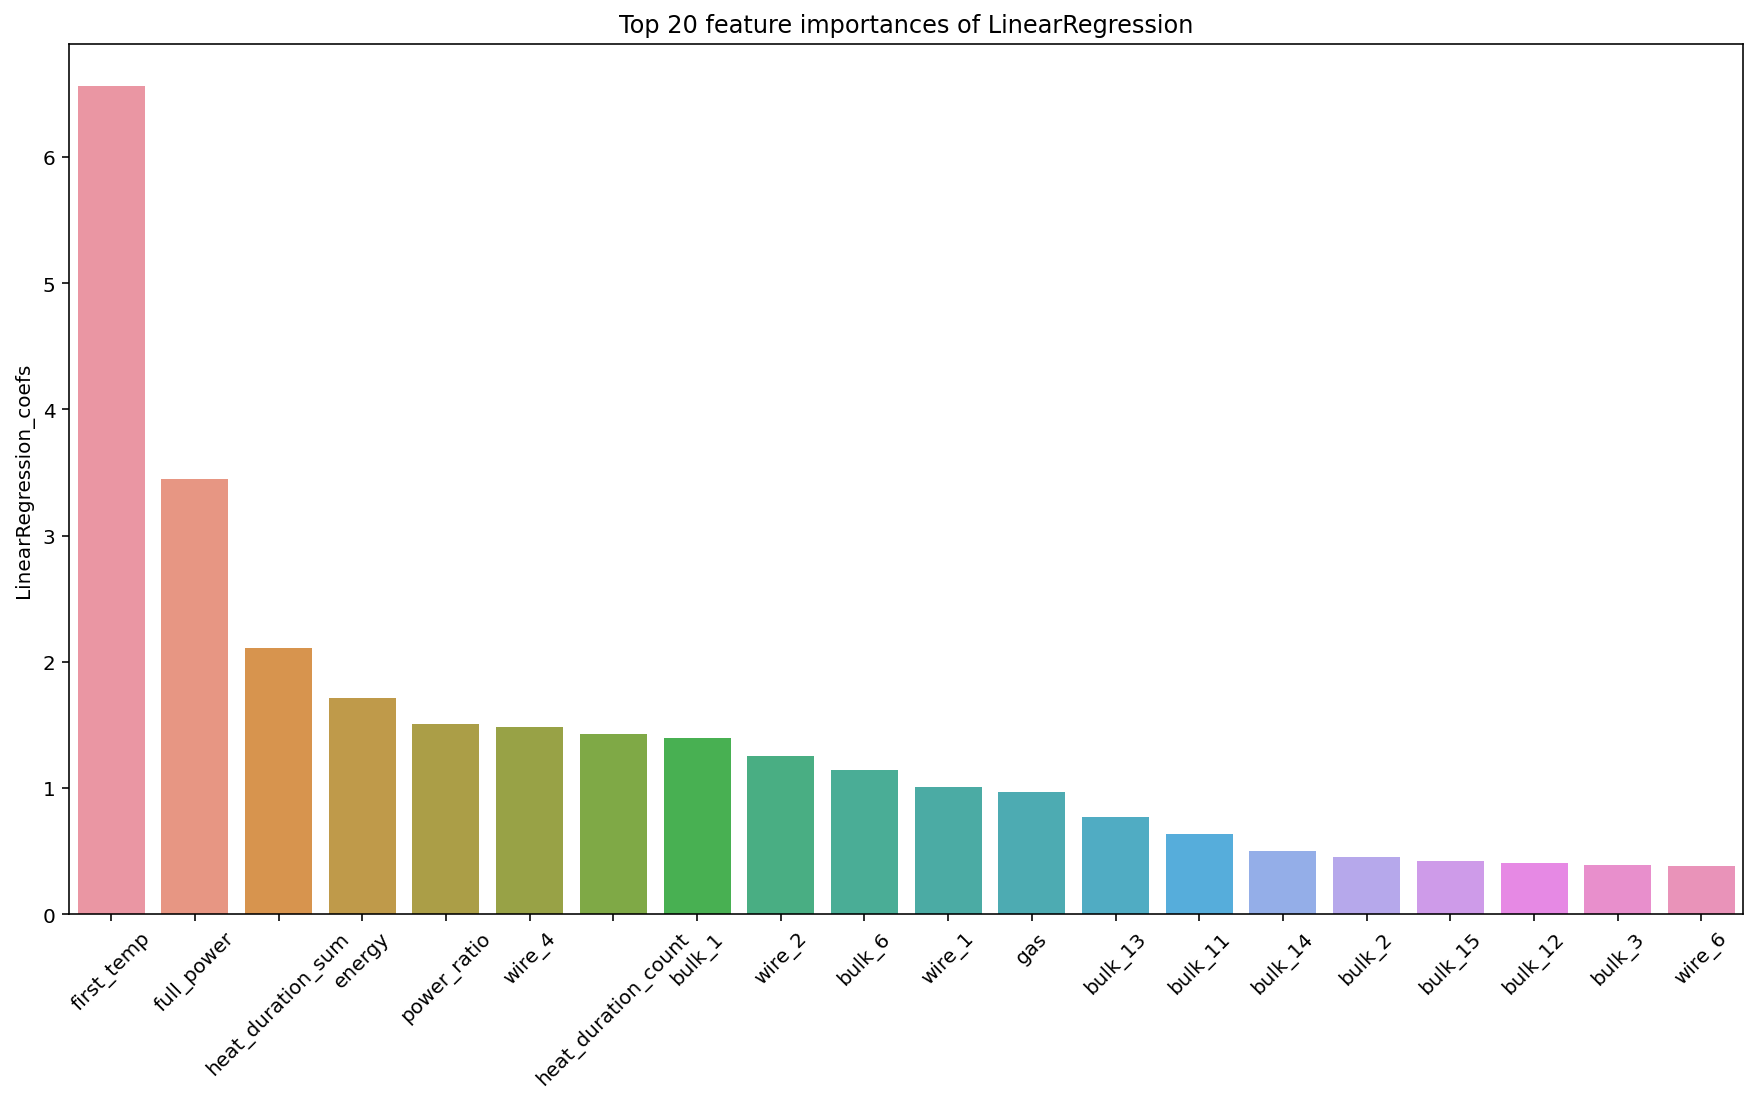

In [84]:
coefs_lr = pd.DataFrame(
    abs(lr.coef_), index=train_v[0].columns, columns=["LinearRegression_coefs"]
).sort_values(by="LinearRegression_coefs", ascending=False)
plot_importance(coefs_lr, "LinearRegression")

__Summary:__
For the linear regression model with grouped data, the following features are important:
- the most important - the initial temperature of the steel,
- next is 'full_power',
- the group 'heat_duration_sum', 'energy', 'power_ratio', 'wire_4',heat_duration_count', 'bulk_1' and 'wire_2',
- next there is a group bulk supplements, wire and gas. For wire more important frequently added wires and for bulk additives - more important rare additives.
That is, important features that somehow characterize energy consumption, gas, the addition of wire and bulk materials, both frequent and relatively rare.


The most frequent supplements:  

__Вывод:__ 
Для модели линейной регрессии с сгруппированными данными оказались важны следующие признаки:
 - самый важный - начальная температура стали,
 - далее идет  'full_power',
 - далее  группа  'heat_duration_sum', 'energy', 'power_ratio', 'wire_4',heat_duration_count', 'bulk_1' и 'wire_2',
  - далее идет группа сыпучих добавок, проволок и газ, причем проволоки важнее частодобавляемые, а сыпучие добавки - важнее более редкие.
То есть важны признаки, так или иначе характеризующие энергозатраты, газ, добавка проволоки и сыпучих материалов, причем как частых, так и относительно редких.


Самые частые добавки: 

In [85]:
wire_frequency.reset_index().join(
    bulk_frequency.reset_index(), lsuffix="_wire", rsuffix="_bulk"
)

index_wire  0_wire index_bulk     0_bulk
0     wire_1   99.16    bulk_14  89.677213
1     wire_2   35.02    bulk_12  78.299776
2     wire_6    2.37    bulk_15  71.844040
3     wire_3    2.04     bulk_3  41.482902
4     wire_9    0.94     bulk_4  32.406520
5     wire_8    0.62     bulk_6  18.408437
6     wire_4    0.45     bulk_1   8.053691
7     wire_7    0.36    bulk_11   5.656759
8     wire_5    0.03    bulk_10   5.624800

Now let's look at the results of linear regression with ungrouped data:  
Теперь посмотрим на результаты линейной регрессии с не группированными данными:

In [86]:
lr_full = LinearRegression()
lr_full.fit(train_v_full[0], train_v_full[1])

fill_summary(lr_full, "LinearRegression_full", cv=False, data="full", fill_test=False)

LinearRegression()

MAE on cross-validation / На валидационной выборке MAE = 5.55


МАЕ 5.55, slightly more than on the grouped data, but also good result.  
МАЕ 5,55, чуть больше, чем на сгруппированных данных, но тоже хорошо.

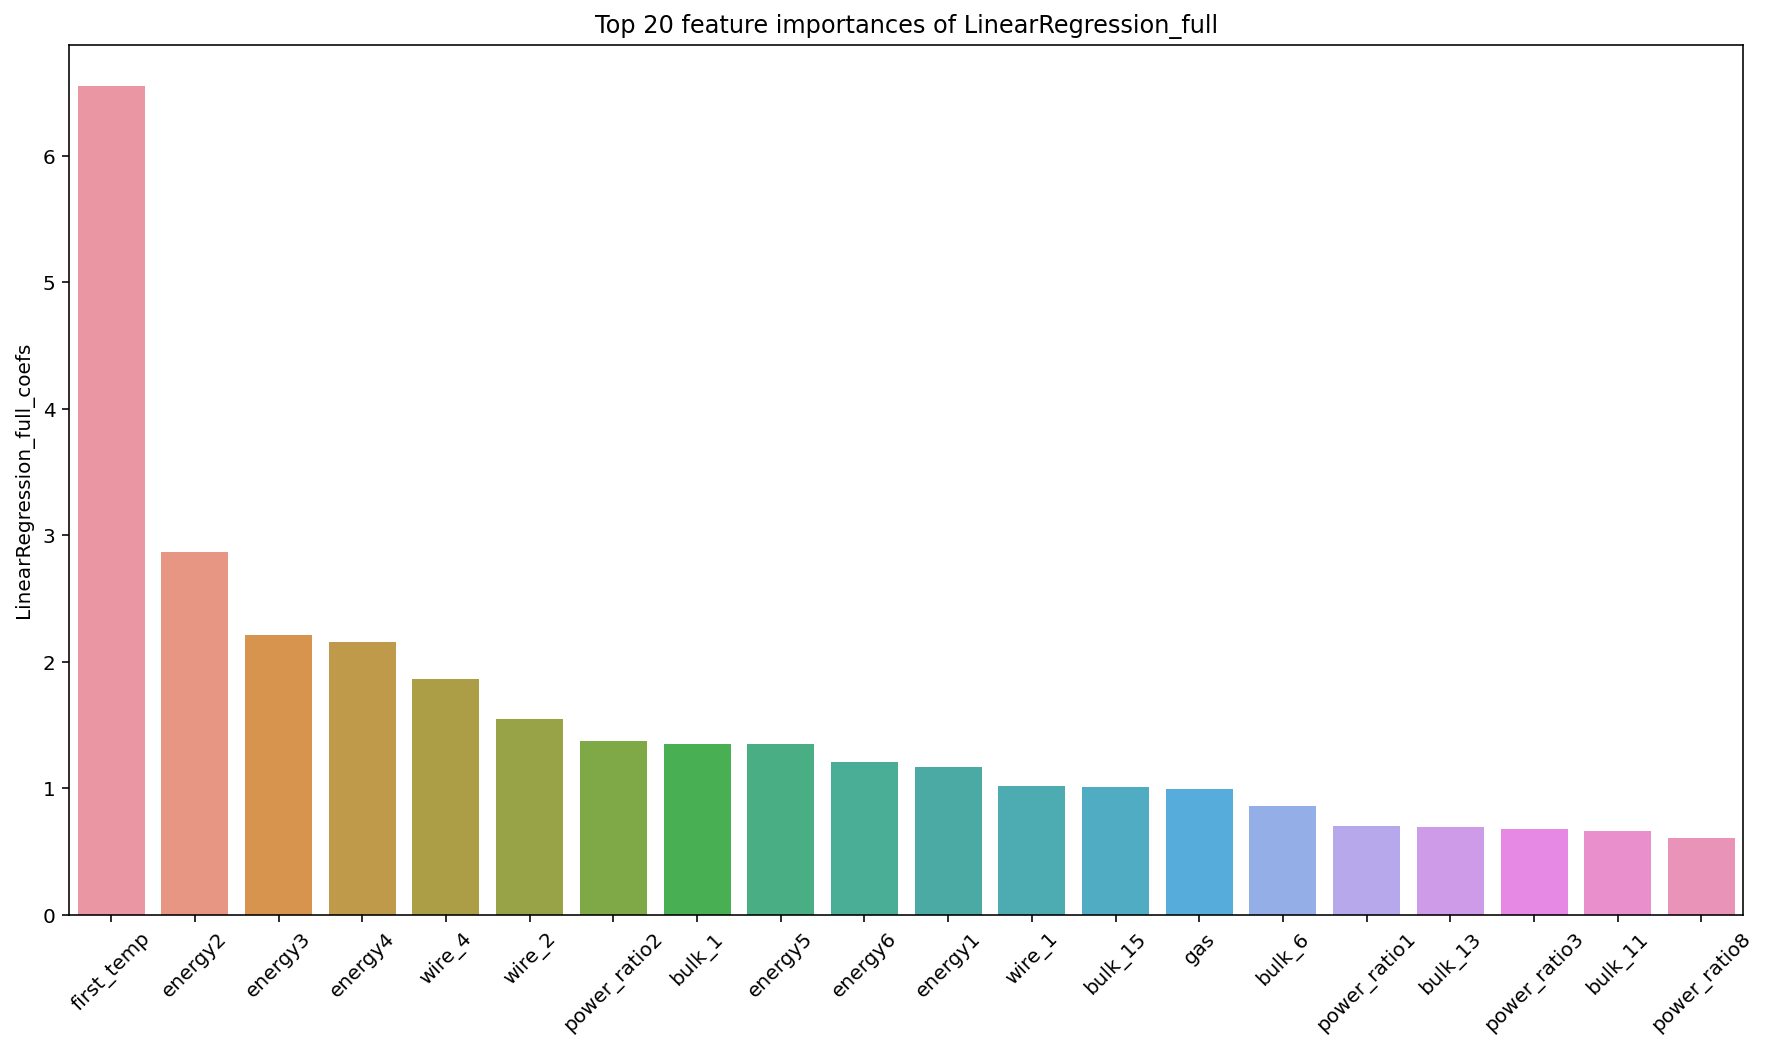

In [87]:
coefs_lr_full = pd.DataFrame(
    abs(lr_full.coef_),
    index=train_v_full[0].columns,
    columns=["LinearRegression_full_coefs"],
).sort_values(by="LinearRegression_full_coefs", ascending=False)
plot_importance(coefs_lr_full, "LinearRegression_full")

__Summary:__
For linear regression model with ungrouped data, the following features are important:
- the most important is the initial temperature of the steel,
- next comes the group 'energy_2', 'energy_3' and 'energy_4',
- - then the group 'wire_4', 'wire_2', 'power_ratio_2', 'bulk_1', 'energy_5'.

In addition to the first temperature, energy data on first iterations is important (it is available for most batches), and additives of wire and bulk materials, and with wire, frequent additives are more important, and bulk materials are both common and rare.  

__Вывод:__ 
Для модели линейной регрессии с не группированными данными оказались важны следующие признаки:
 - самый важный - начальная температура стали,
 - далее идет группа 'energy_2', 'energy_3'  и 'energy_4',
 - далее  группа 'wire_4', 'wire_2', 'power_ratio2', 'bulk_1', 'energy_5'.
 
То, есть похоже, что кроме первой температуры важны показатели энергии в основном на первых итерациях (которые есть для большинства партий), и добавки проволоки и сыпучих материалов, причем с проволокой важней частые добавки, а сыпучими материалами как распространенные, так и редкие. 
 

<a id='32'></a>

### LGBMRegressor

Here and further on, the  parameters searc is commented out, leaving only the selected values for quick training.  
Здесь и дальше основной подбор параметров закомментирован, оставлены только подобранные значения для быстрой работы

In [88]:
lgbm = lgb.LGBMRegressor(
    learning_rate=0.05,
    n_estimators=100,
    subsample_for_bin=200,
    random_state=90,
)
params_lgb = {
    "num_leaves": range(25, 26),
    "max_depth": range(8, 9),
    "min_data_in_leaf": range(23, 24),
    #     "num_leaves": range(16, 32),
    #     "max_depth": range(6, 20),
    #     "learning_rate": [0.05, 0.005],
    #     'n_estimators': range(100, 201, 10),
    #     "min_data_in_leaf": range(5, 31),
}

lgb_cv = GridSearchCV(
    estimator=lgbm,
    param_grid=params_lgb,
    cv=5,
    n_jobs=7,
    scoring="neg_mean_absolute_error",
)
lgb_cv.fit(train[0].values, train[1].values)

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


GridSearchCV(cv=5,
             estimator=LGBMRegressor(learning_rate=0.05, random_state=90,
                                     subsample_for_bin=200),
             n_jobs=7,
             param_grid={'max_depth': range(8, 9),
                         'min_data_in_leaf': range(23, 24),
                         'num_leaves': range(25, 26)},
             scoring='neg_mean_absolute_error')

In [89]:
fill_summary(lgb_cv, "LGBMRegressor", cv=True, data="not_full", fill_test=False)

Best params / Лучшие параметры: {'max_depth': 8, 'min_data_in_leaf': 23, 'num_leaves': 25}

MAE on cross-validation / На кросс-валидации MAE = 6.101


The LGBMRegressor model showed worse results than the linear regression.  
Модель LGBMRegressor показала результаты хуже, чем линейная регрессия.

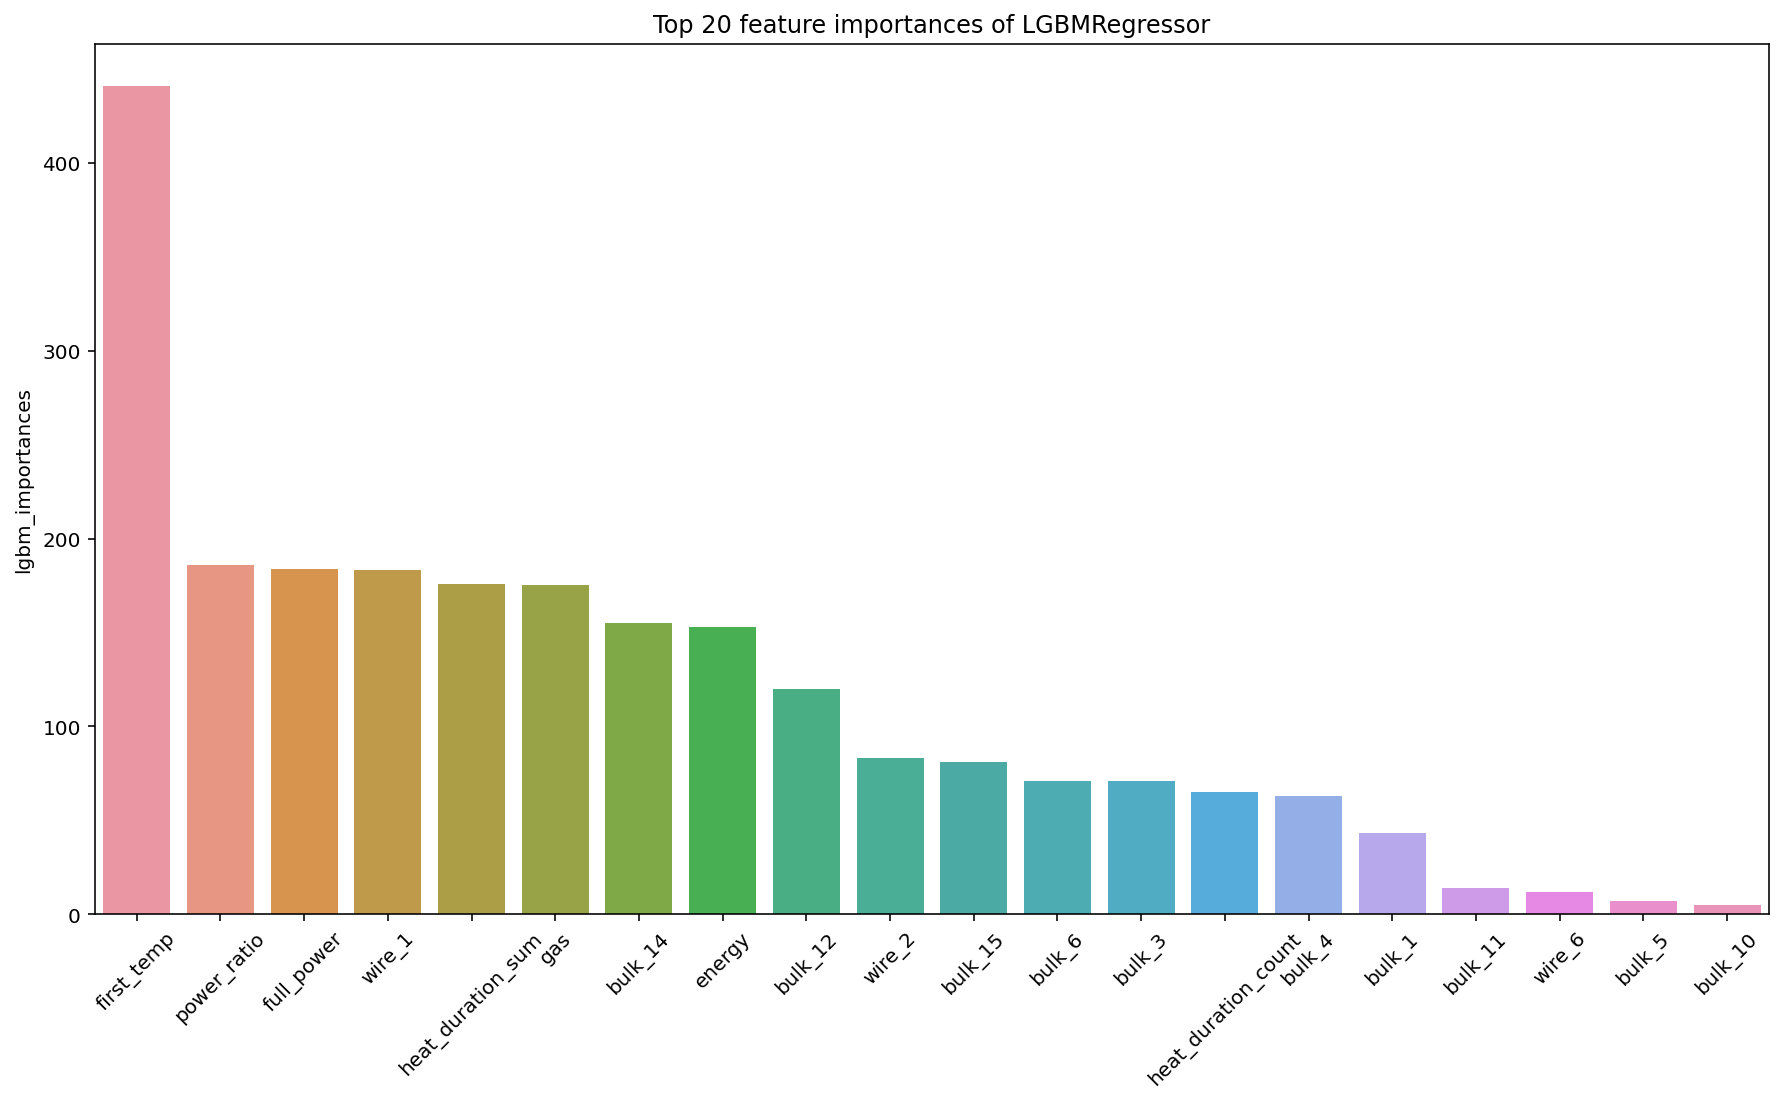

In [90]:
lgbm_importances = pd.DataFrame(
    lgb_cv.best_estimator_.booster_.feature_importance(),
    index=train[0].columns,
    columns=["lgbm_importances"],
)
plot_importance(lgbm_importances, "LGBMRegressor")

__Summary:__
For the LGBMRegressor model ,the following features are important:
- the most important, as for linear regression model - the initial temperature of the steel,
- next comes the group 'wire_1', 'gas', 'power_ratio', 'heat_duration_sum', 'full_power' and 'energy',
- then the group 'bulk_14', 'bulk_12', 'wire_2',' bulk_15',' bulk_6',' bulk_4 'and'heat_duration_count'.

In addition to the initial temperature, the features that somehow characterize the energy consumption are important, and, in contrast to the linear regression, the most frequent wires  -  'wire_1' and 'wire_2', gas, and all 6 most frequent bulk additives.  

__Вывод:__ 
Для модели LGBMRegressor оказались важны следующие признаки:
 - самый важный ,как и для модели линейной регрессии - начальная температура стали,
 - далее идет группа 'wire_1', 'gas', 'power_ratio', 'heat_duration_sum', 'full_power' и 'energy',
 - далее  группа 'bulk_14', 'bulk_12', 'wire_2', 'bulk_15', 'bulk_6', 'bulk_4' и 'heat_duration_count'.
 
 То есть важны, кроме начальной температуры, признаки, так или иначе характеризующие энергозатраты, и, в отличие от линейной регрессии, самые частые проволоки - 'wire_1' и 'wire_2', газ, и все 6 самых частых  сыпучих примесей.

In [91]:
lgbm_full = lgb.LGBMRegressor(
    learning_rate=0.05,
    n_estimators=150,
    subsample_for_bin=200,
    random_state=90,
)
params_lgb_full = {
    "num_leaves": range(29, 30),
    "max_depth": range(14, 15),
    "min_data_in_leaf": range(18, 19),
    #     "max_depth": range(6, 20),
    #     "learning_rate": [0.05, 0.005],
    #     'n_estimators': range(100, 201, 10),
    #     "num_leaves": range(16, 32),
    #     "min_data_in_leaf": range(5, 31),
}


lgb_cv_full = GridSearchCV(
    estimator=lgbm_full,
    param_grid=params_lgb_full,
    cv=4,
    n_jobs=7,
    scoring="neg_mean_absolute_error",
)
lgb_cv_full.fit(train_full[0].values, train_full[1].values)

GridSearchCV(cv=4,
             estimator=LGBMRegressor(learning_rate=0.05, n_estimators=150,
                                     random_state=90, subsample_for_bin=200),
             n_jobs=7,
             param_grid={'max_depth': range(14, 15),
                         'min_data_in_leaf': range(18, 19),
                         'num_leaves': range(29, 30)},
             scoring='neg_mean_absolute_error')

In [92]:
fill_summary(lgb_cv_full, "LGBMRegressor_full", cv=True, data="full", fill_test=False)

Best params / Лучшие параметры: {'max_depth': 14, 'min_data_in_leaf': 18, 'num_leaves': 29}

MAE on cross-validation / На кросс-валидации MAE = 6.12


Also worse than linear regression.  
Тоже хуже, чем линейная регрессия.

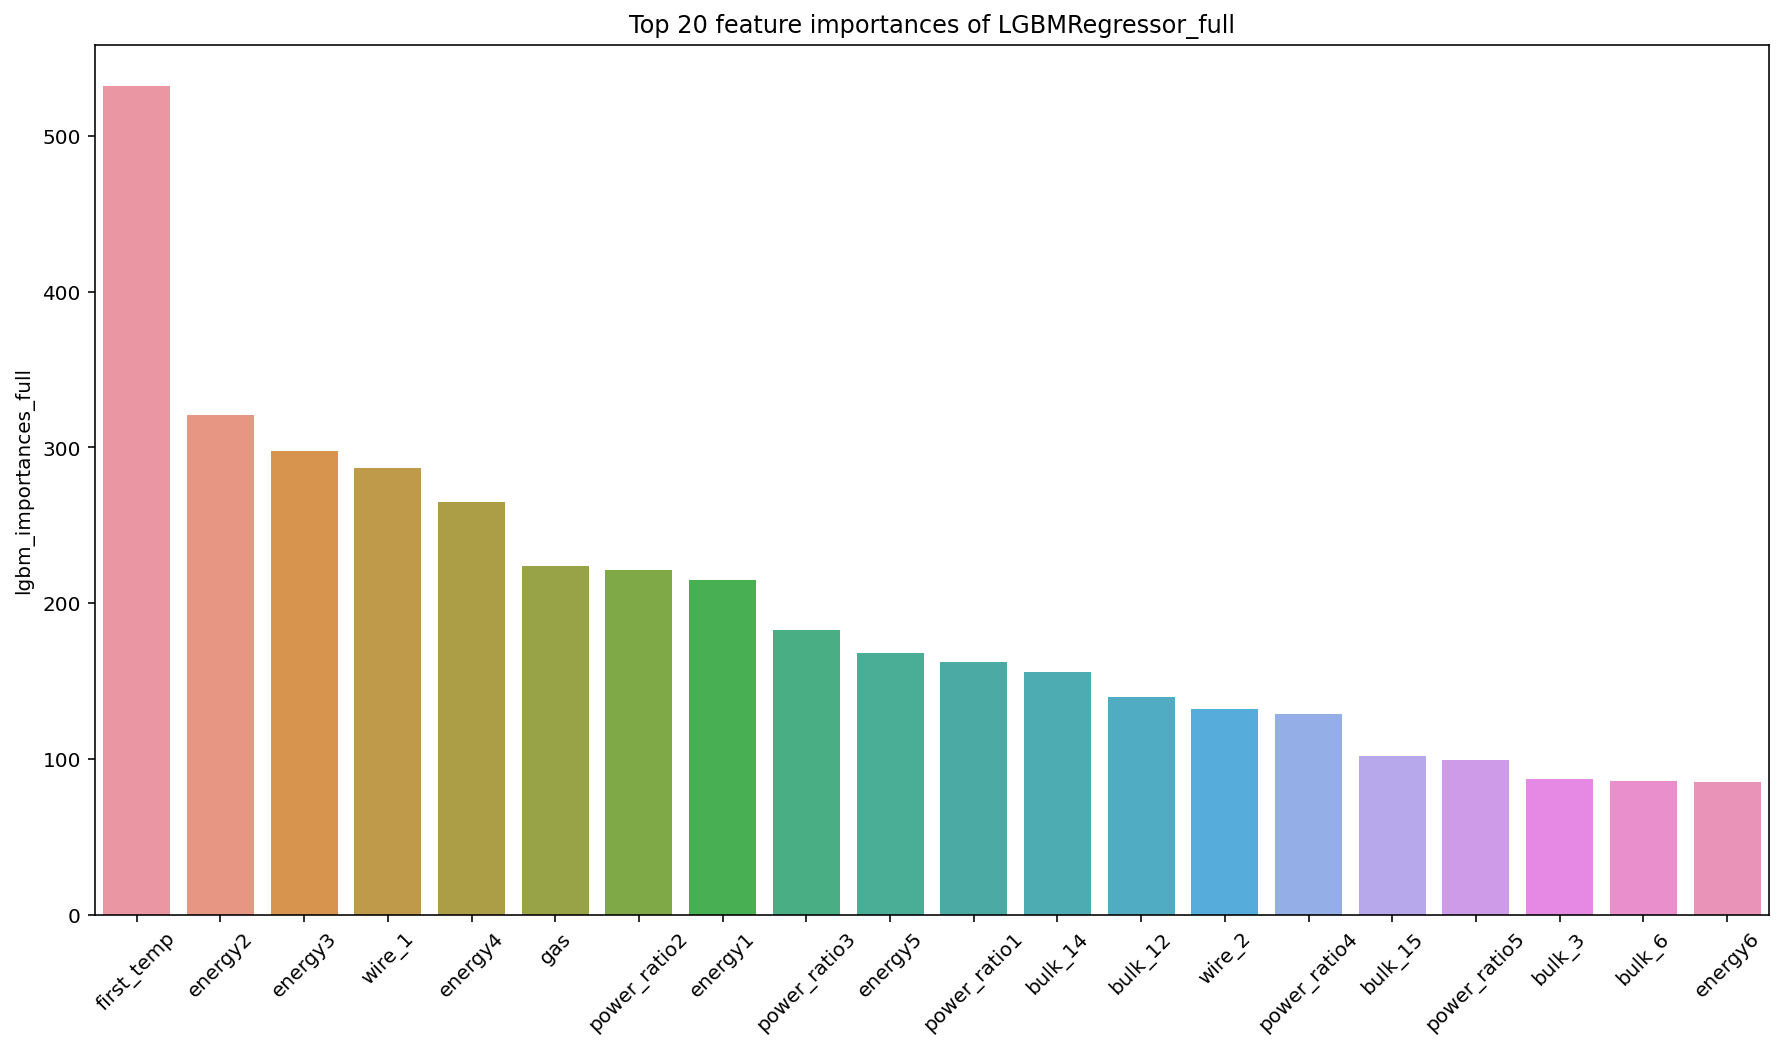

In [93]:
lgbm_importances_full = pd.DataFrame(
    lgb_cv_full.best_estimator_.booster_.feature_importance(),
    index=train_full[0].columns,
    columns=["lgbm_importances_full"],
)
plot_importance(lgbm_importances_full, "LGBMRegressor_full")

__Summary:__
For the LGBMRegressor model with full data, the following features are important:
- the most important - the initial temperature of the steel,
- next comes the group 'energy_2', 'energy_3', 'wire_1',
- next comes the group 'power_ratio 2', 'gas',' energy_4','energy_1'.

In addition to the first temperature, the energy indicators and the ratio of active and reactive power at the first iterations are important (they are available for most batches), gas and the most frequent wires - 'wire_1' and 'wire_2', gas, and all 6 most frequent bulk additives.  

__Вывод:__ 
Для модели LGBMRegressor с полными данными оказались важны следующие признаки:
 - самый важный - начальная температура стали,
 - далее идет группа 'energy_2', 'energy_3', 'wire_1',
 - далее  группа 'power_ratio2', 'gas', 'energy_4',  'energy_1'.
 
То есть, кроме первой температуры важны показатели энергии и соотношение активной и реактивной мощностей на первых итерациях (которые есть для большинства партий), газ и самые частые проволоки - 'wire_1' и 'wire_2', газ, и все 6 самых частых сыпучих примесей.


<a id='33'></a>

### RandomForestRegressor

In [94]:
params_forest = {
    "max_depth": range(22, 23),
    "min_samples_leaf": range(3, 4),
}
forest = RandomForestRegressor(n_estimators=100, random_state=90, criterion="mae")
forest_cv = GridSearchCV(
    estimator=forest,
    param_grid=params_forest,
    cv=5,
    n_jobs=7,
    scoring="neg_mean_absolute_error",
)
forest_cv.fit(train_v[0], train_v[1])

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(criterion='mae', random_state=90),
             n_jobs=7,
             param_grid={'max_depth': range(22, 23),
                         'min_samples_leaf': range(3, 4)},
             scoring='neg_mean_absolute_error')

In [95]:
fill_summary(forest_cv, "RandomForest", cv=True, data="not_full", fill_test=False)

Best params / Лучшие параметры: {'max_depth': 22, 'min_samples_leaf': 3}

MAE on cross-validation / На кросс-валидации MAE = 6.221


 The result is worse than that of LGBMRegressor. 
 Результат хуже, чем у LGBMRegressor.

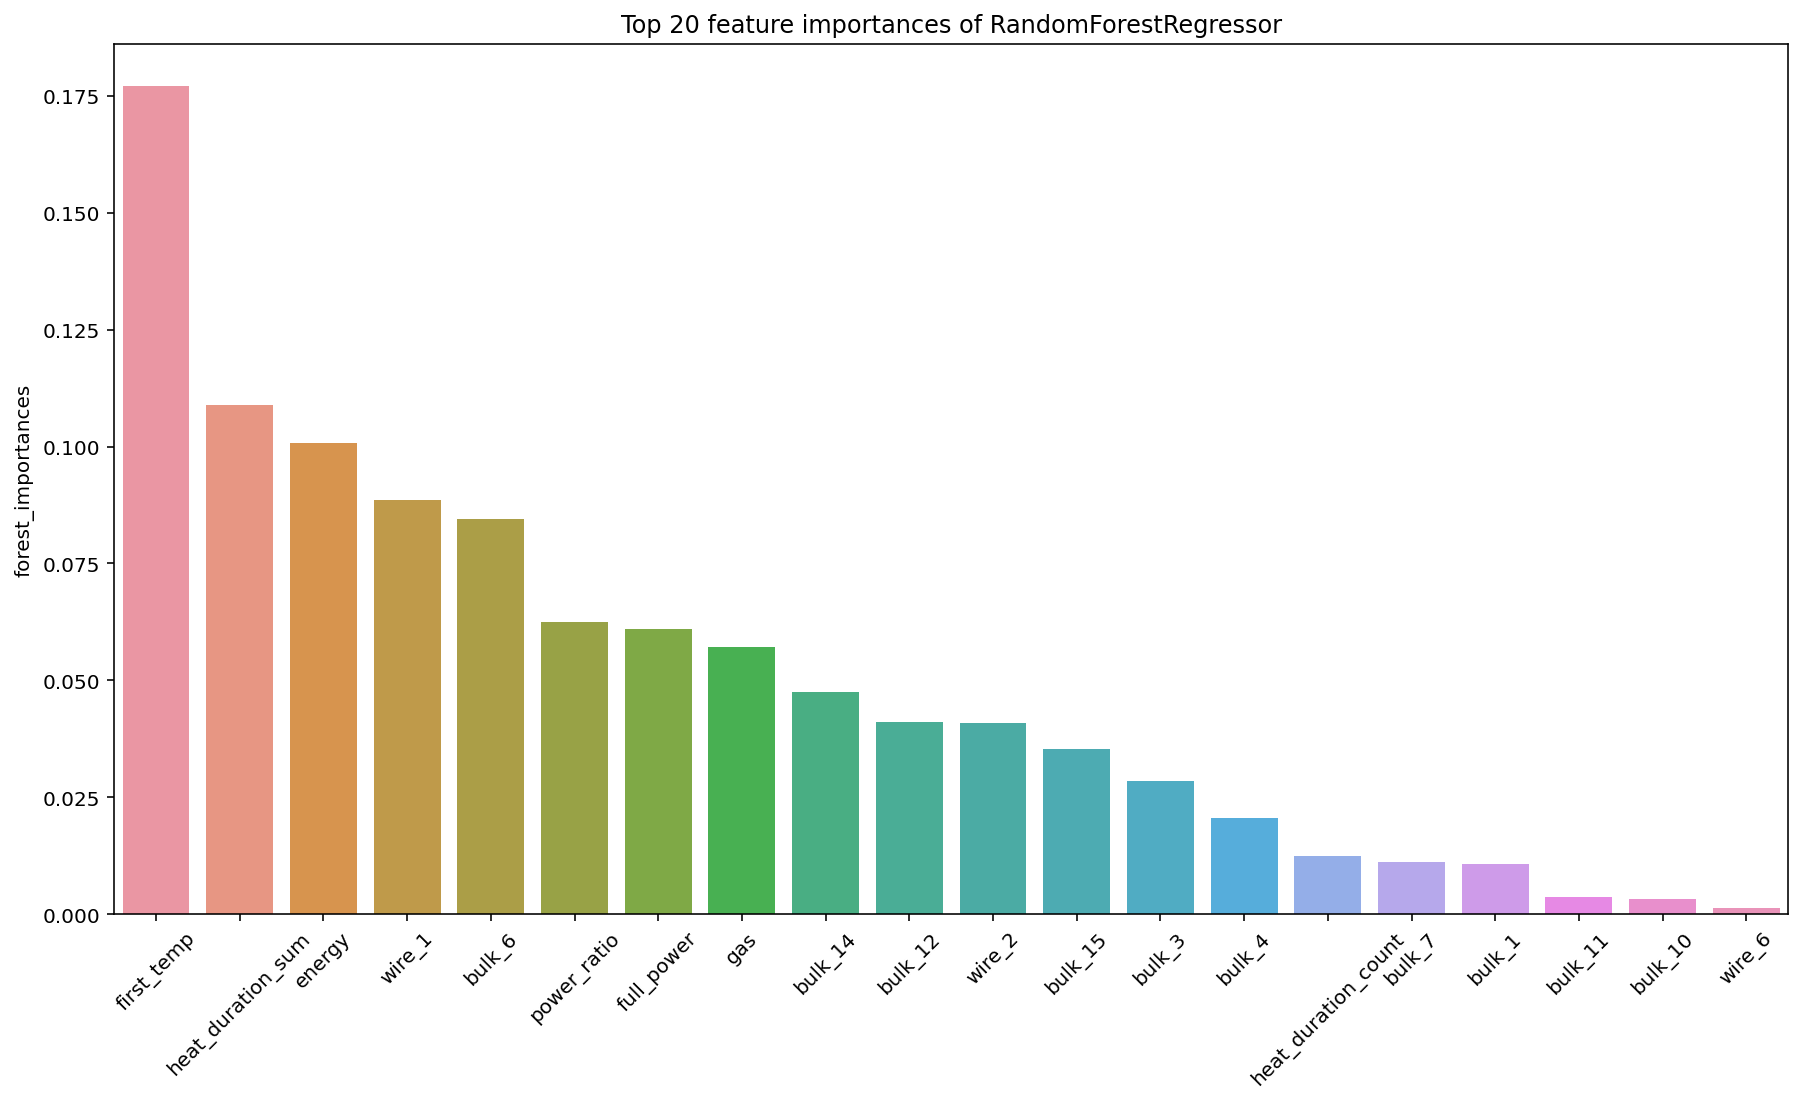

In [96]:
forest_importances = pd.DataFrame(
    forest_cv.best_estimator_.feature_importances_,
    index=train[0].columns,
    columns=["forest_importances"],
)
plot_importance(forest_importances, "RandomForestRegressor")

__Summary:__

 - As in previous models, the most important feature is the initial temperature of the alloy.
 - next comes the group 'heat_duration_sun', 'energy', 'wire_1',
 - then the group 'bulk_6', 'power_ratio', 'full_power', 'gas'.  
 
In addition to the first temperature, the indicators that characterize energy consumption are important, and, as for LGBMRegressor, the most frequent wires are 'wire_1' and 'wire_2', gas, and all 6 most frequent bulk additives.  

__Вывод:__
 - Как и в предыдущих моделях, самый важный признак - начальная температура сплава.  
 - далее идет группа 'heat_duration_sum', 'energy', 'wire_1',
 - далее группа 'bulk_6', 'power_ratio', 'full_power', 'gas'.
Кроме первой температуры важны показатели, характеризующие потребление энергии, и, как и для LGBMRegressor, самые частые проволоки - 'wire_1' и 'wire_2', газ, и все 6 самых частых сыпучих примесей.


Since the results of the random forest are worse than the previous models, and it takes much longer to train, I will not test the forest with data_full.  
Поскольку результаты случайного леса хуже предыдущих моделей, а обучается он заметно дольше, то тестировать лес с data_full не буду.

<a id='34'></a>

### keras.models.Sequential()

In [97]:
model = keras.models.Sequential()
model.add(
    keras.layers.Dense(input_dim=train_v[0].shape[1], units=256, activation="sigmoid")
)
model.add(keras.layers.Dense(units=128, activation="sigmoid"))

model.add(keras.layers.Dense(units=1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")

In [98]:
history = model.fit(
    x=train_v[0],
    y=train_v[1],
    validation_data=(valid_v[0], valid_v[1]),
    batch_size=16,
    epochs=240,
    verbose=2,
)

Epoch 1/240
101/101 - 0s - loss: 1583.8615 - val_loss: 1578.3867
Epoch 2/240
101/101 - 0s - loss: 1575.1519 - val_loss: 1570.3210
Epoch 3/240
101/101 - 0s - loss: 1567.1659 - val_loss: 1562.5027
Epoch 4/240
101/101 - 0s - loss: 1559.3475 - val_loss: 1554.5911
Epoch 5/240
101/101 - 0s - loss: 1551.4434 - val_loss: 1546.7107
Epoch 6/240
101/101 - 0s - loss: 1542.8542 - val_loss: 1537.6276
Epoch 7/240
101/101 - 0s - loss: 1534.1484 - val_loss: 1529.1569
Epoch 8/240
101/101 - 0s - loss: 1525.7529 - val_loss: 1520.7003
Epoch 9/240
101/101 - 0s - loss: 1517.0063 - val_loss: 1511.7916
Epoch 10/240
101/101 - 0s - loss: 1508.1893 - val_loss: 1502.9362
Epoch 11/240
101/101 - 0s - loss: 1499.1627 - val_loss: 1493.8107
Epoch 12/240
101/101 - 0s - loss: 1490.1376 - val_loss: 1484.9384
Epoch 13/240
101/101 - 0s - loss: 1481.3430 - val_loss: 1476.2056
Epoch 14/240
101/101 - 0s - loss: 1472.6500 - val_loss: 1467.5482
Epoch 15/240
101/101 - 0s - loss: 1464.0199 - val_loss: 1458.9283
Epoch 16/240
101/10

In [99]:
fill_summary(model, "Sequential", cv=False, data="not_full", fill_test=False)

MAE on cross-validation / На валидационной выборке MAE = 5.084


МАЕ = 5.1, it is better than linear regression  
МАЕ всего 5,1, это лучше чем у линейной регрессии

data_full:

In [100]:
model_full = keras.models.Sequential()
model_full.add(
    keras.layers.Dense(
        input_dim=train_v_full[0].shape[1], units=256, activation="sigmoid"
    )
)
model_full.add(keras.layers.Dense(units=128, activation="sigmoid"))
model_full.add(keras.layers.Dense(units=1))
model_full.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")

In [101]:
history_full = model_full.fit(
    x=train_v_full[0],
    y=train_v_full[1],
    validation_data=(valid_v_full[0], valid_v_full[1]),
    batch_size=16,
    epochs=210,
    verbose=2,
)

Epoch 1/210
102/102 - 0s - loss: 1582.0022 - val_loss: 1576.0494
Epoch 2/210
102/102 - 0s - loss: 1571.8339 - val_loss: 1566.3696
Epoch 3/210
102/102 - 0s - loss: 1562.4027 - val_loss: 1557.1040
Epoch 4/210
102/102 - 0s - loss: 1553.0569 - val_loss: 1547.6935
Epoch 5/210
102/102 - 0s - loss: 1543.7252 - val_loss: 1538.4771
Epoch 6/210
102/102 - 0s - loss: 1534.4409 - val_loss: 1528.9303
Epoch 7/210
102/102 - 0s - loss: 1524.6727 - val_loss: 1519.0828
Epoch 8/210
102/102 - 0s - loss: 1514.9167 - val_loss: 1509.4734
Epoch 9/210
102/102 - 0s - loss: 1505.3839 - val_loss: 1499.9990
Epoch 10/210
102/102 - 0s - loss: 1495.9471 - val_loss: 1490.5946
Epoch 11/210
102/102 - 0s - loss: 1486.5659 - val_loss: 1481.2352
Epoch 12/210
102/102 - 0s - loss: 1477.2236 - val_loss: 1471.9084
Epoch 13/210
102/102 - 0s - loss: 1467.9086 - val_loss: 1462.6050
Epoch 14/210
102/102 - 0s - loss: 1458.6146 - val_loss: 1453.3188
Epoch 15/210
102/102 - 0s - loss: 1449.0529 - val_loss: 1443.4479
Epoch 16/210
102/10

In [102]:
fill_summary(model_full, "Sequential_full", cv=False, data="full", fill_test=False)

MAE on cross-validation / На валидационной выборке MAE = 5.453


The result is slightly worse than on grouped data.  
Результат чуть хуже, чем на сгруппированных данных.

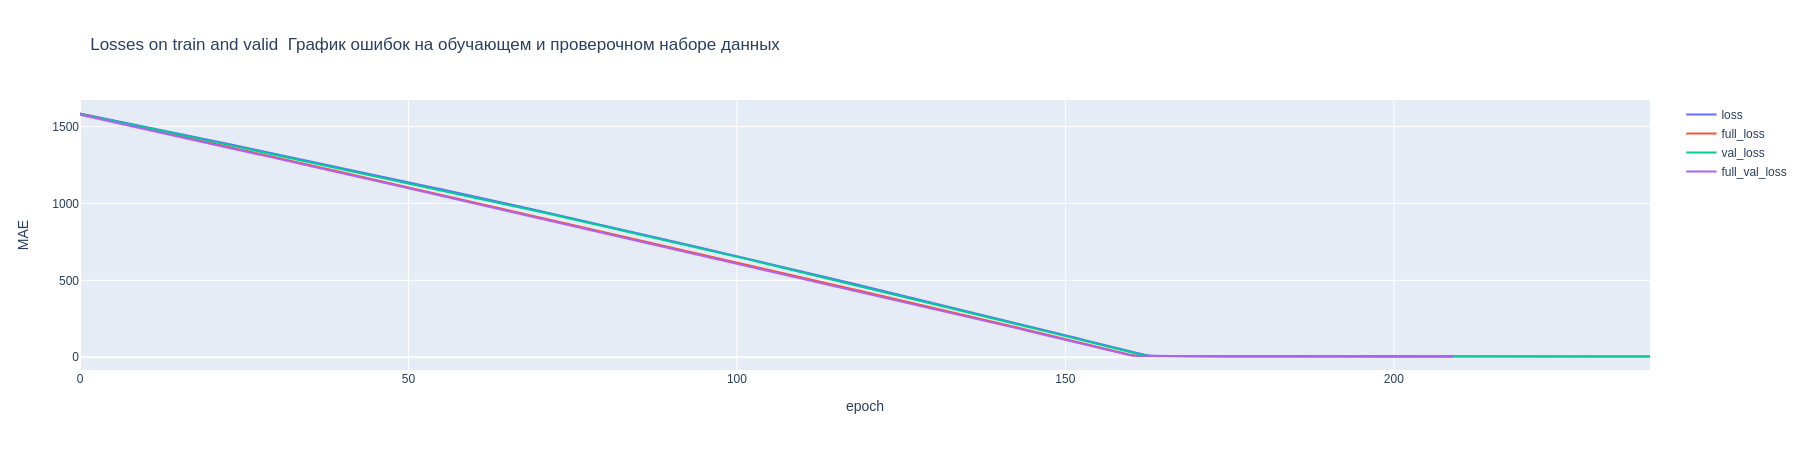

In [103]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.DataFrame(history.history)["loss"], name="loss"))
fig.add_trace(
    go.Scatter(y=pd.DataFrame(history_full.history)["loss"], name="full_loss")
)
fig.add_trace(go.Scatter(y=pd.DataFrame(history.history)["val_loss"], name="val_loss"))
fig.add_trace(
    go.Scatter(y=pd.DataFrame(history_full.history)["val_loss"], name="full_val_loss")
)
fig.update_layout(
    title="Losses on train and valid \nГрафик ошибок на обучающем и проверочном наборе данных",
    xaxis_title="epoch",
    yaxis_title="MAE",
)
fig.show();

<a id='35'></a>

### CatBoostRegressor

In [104]:
params_cat = {
    "depth": range(4, 5),
    "n_estimators": range(100, 101, 100),
    #     "depth": range(3,15),
    #     "learning_rate": [0.1, 0.05],
    #     "n_estimators": [100, 200, 300],
}
cat = CatBoostRegressor(
    loss_function="MAE", random_state=90, verbose=0, learning_rate=0.1
)
cat_cv = GridSearchCV(
    cat, n_jobs=7, param_grid=params_cat, scoring="neg_mean_absolute_error", cv=5
)
cat_cv.fit(train[0], train[1])

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f95ccb691c0>,
             n_jobs=7,
             param_grid={'depth': range(4, 5),
                         'n_estimators': range(100, 101, 100)},
             scoring='neg_mean_absolute_error')

In [105]:
fill_summary(cat_cv, "CatBoostRegressor", cv=True, data="not_full", fill_test=False)

Best params / Лучшие параметры: {'depth': 4, 'n_estimators': 100}

MAE on cross-validation / На кросс-валидации MAE = 6.044


Better than LGBMRegressor, but worse than linear regression, and the selection of parameters is the longest.  
Лучше, чем LGBMRegressor, но хуже линейной регрессии, при этом подбор параметров самый долгий.

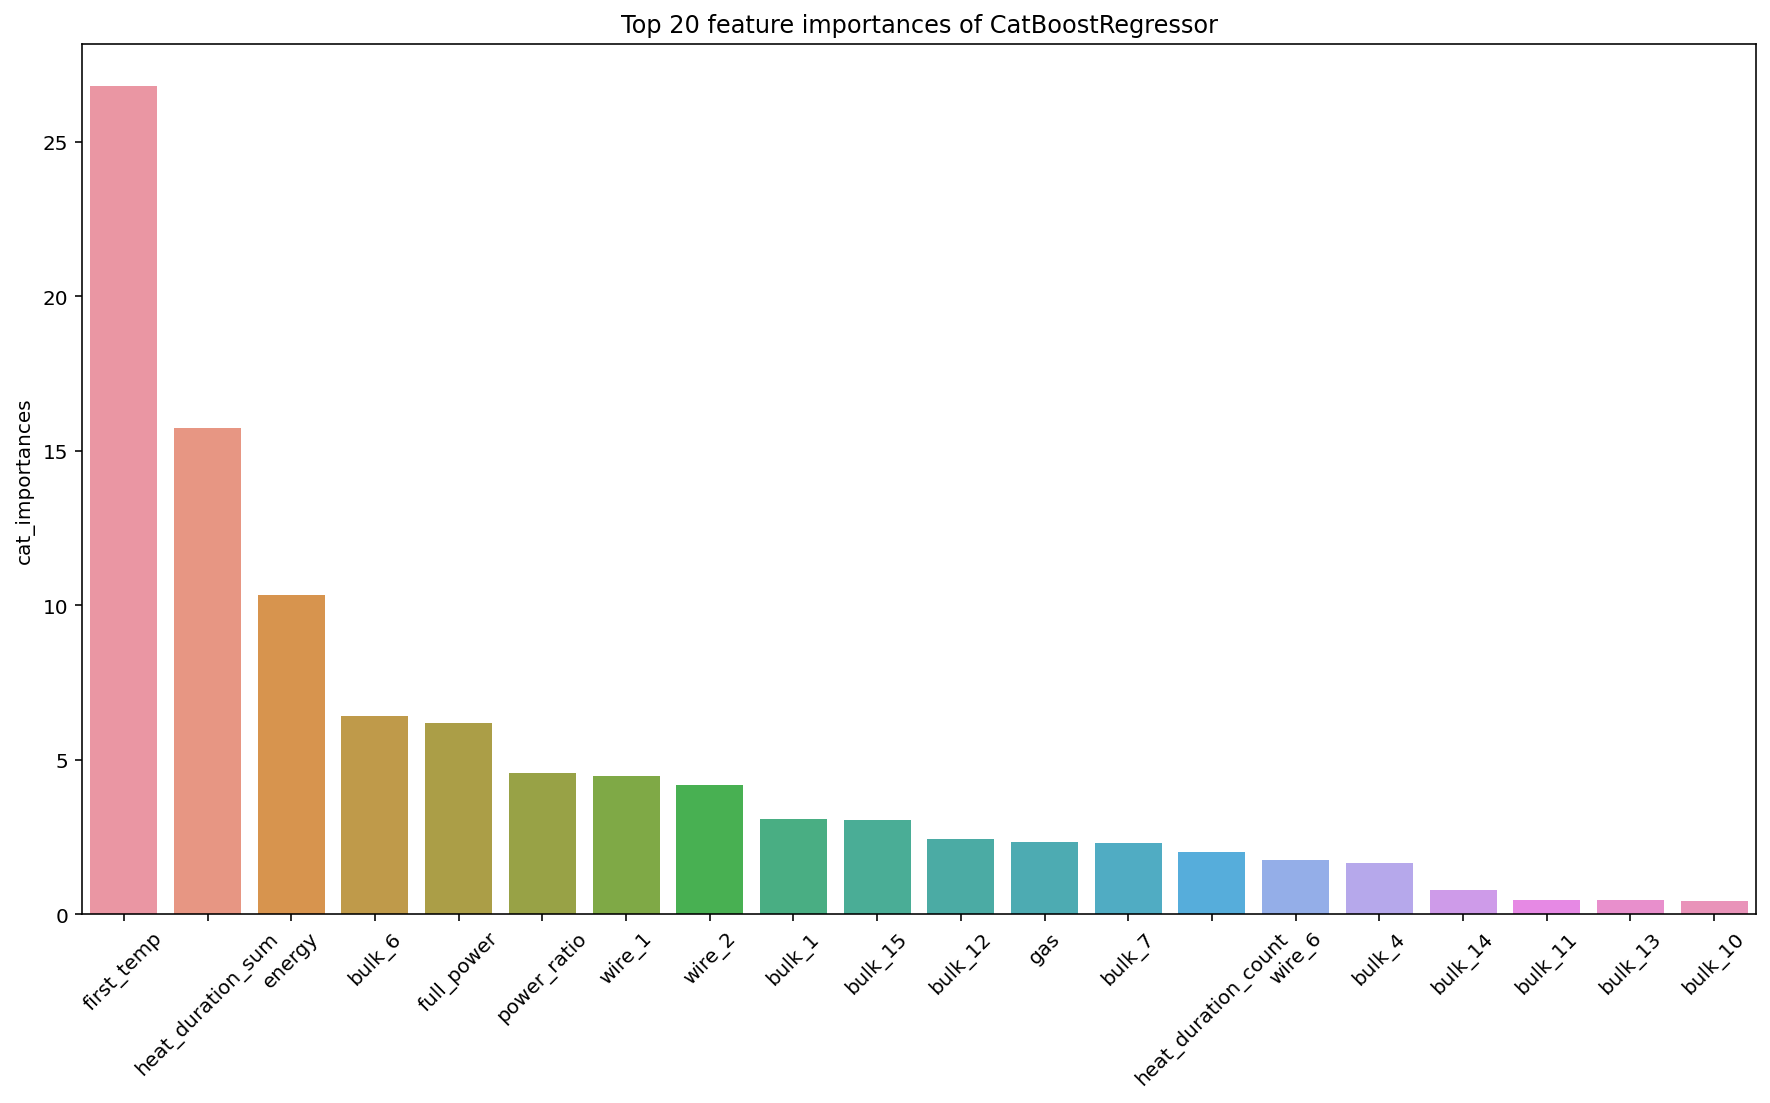

In [106]:
cat_importances = pd.DataFrame(
    cat_cv.best_estimator_.get_feature_importance(),
    index=train[0].columns,
    columns=["cat_importances"],
)
plot_importance(cat_importances, "CatBoostRegressor")

__Summary:__
- for CatBoostRegressor, as in previous models, the most important feature is the initial temperature of the alloy,
- next is 'energy', 'heat_duration_sum',,
- next is the group 'bulk_6', 'wire_1', 'full_power', 'wire_2', 'power_ratio'.
That is, in addition to the first temperature, the features that characterize energy consumption are important, and, as for LGBMRegressor, the most frequent wires - 'wire_1' and 'wire_2', gas, and all 6 most frequent bulk additives.  

__Вывод:__
 - для CatBoostRegressor, как и в предыдущих моделях, самый важный признак - начальная температура сплава,  
 - далее идет 'energy', 'heat_duration_sum', ,
 - далее группа 'bulk_6', 'wire_1', 'full_power', 'wire_2', 'power_ratio'.
То есть кроме первой температуры важны показатели, характеризующие потребление энергии, и, как и для LGBMRegressor, самые частые проволоки - 'wire_1' и 'wire_2', газ, и все 6 самых частых сыпучих примесей.

In [107]:
params_cat = {
    "depth": range(4, 5),
    "n_estimators": range(200, 201, 100),
    #     "depth": range(3,15),
    #     "learning_rate": [0.1, 0.05],
    #     "n_estimators": [100, 200, 300],
}
cat_full = CatBoostRegressor(
    loss_function="MAE", random_state=572, verbose=0, learning_rate=0.1
)
cat_cv_full = GridSearchCV(
    cat_full, n_jobs=7, param_grid=params_cat, scoring="neg_mean_absolute_error", cv=5
)
cat_cv_full.fit(train_full[0], train_full[1])

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f95d0d0f280>,
             n_jobs=7,
             param_grid={'depth': range(4, 5),
                         'n_estimators': range(200, 201, 100)},
             scoring='neg_mean_absolute_error')

In [108]:
fill_summary(
    cat_cv_full, "CatBoostRegressor_full", cv=True, data="full", fill_test=False
)

Best params / Лучшие параметры: {'depth': 4, 'n_estimators': 200}

MAE on cross-validation / На кросс-валидации MAE = 6.079


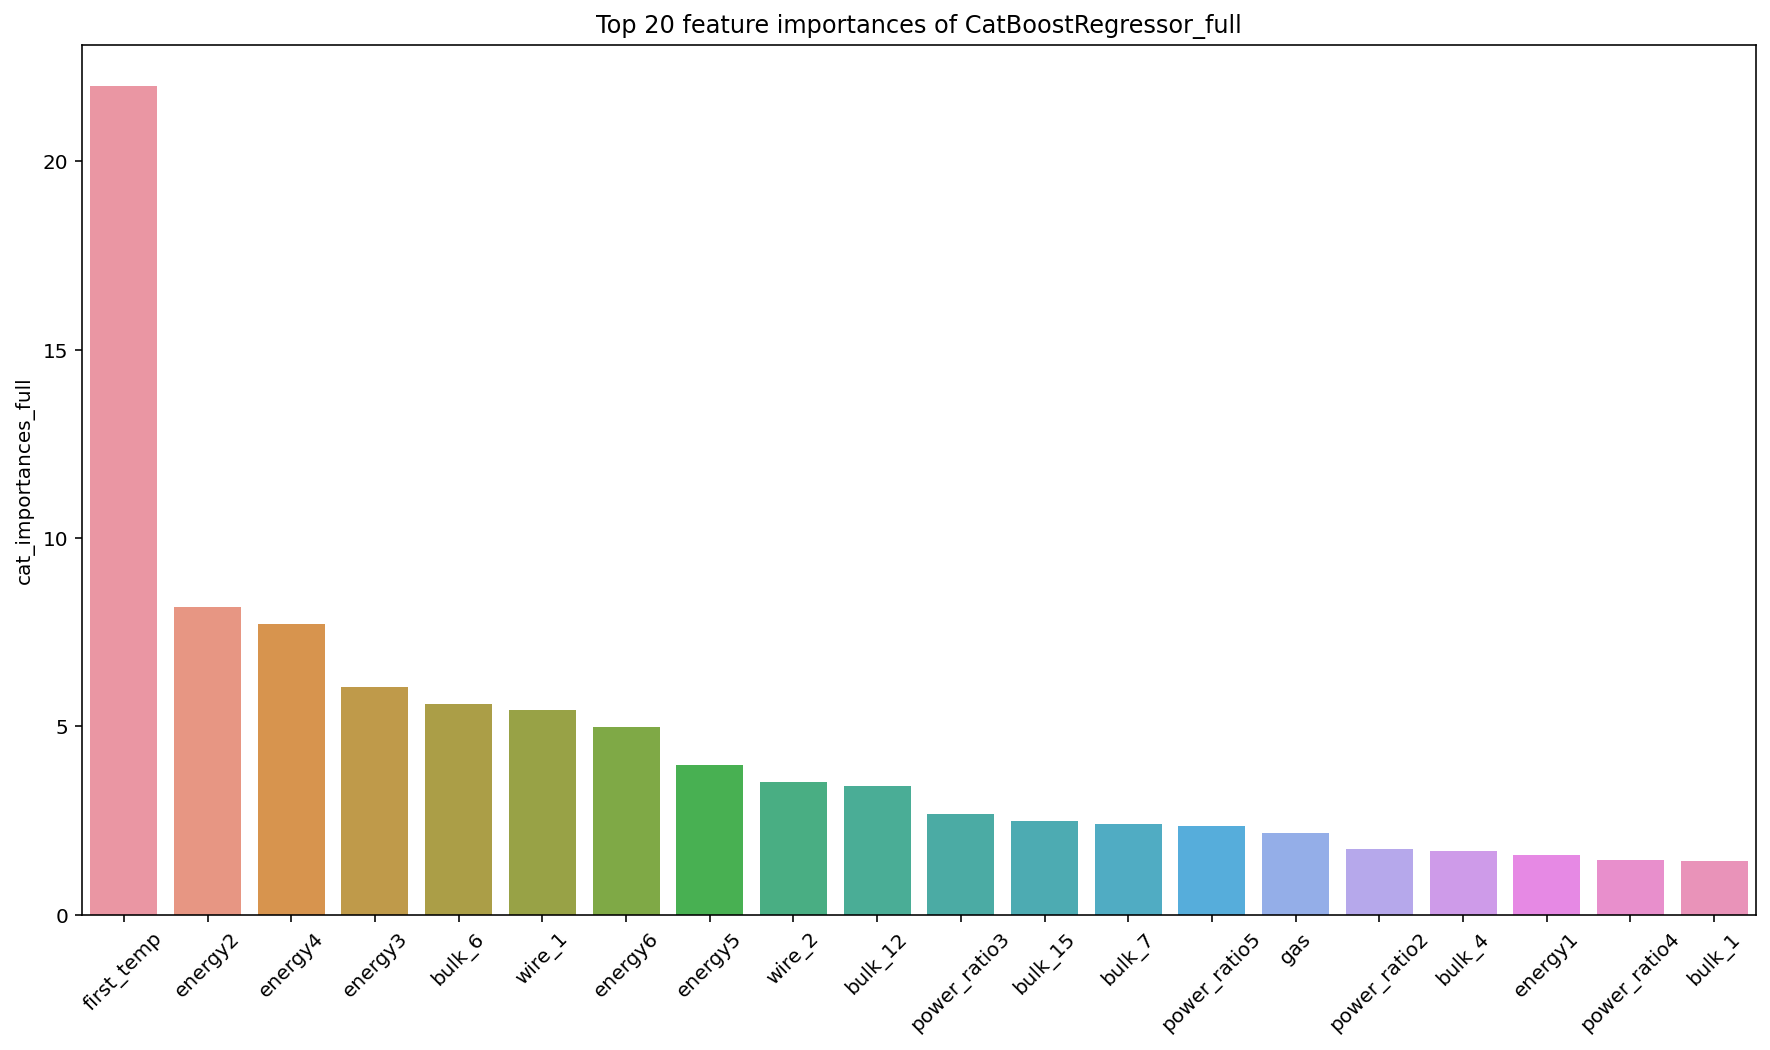

In [109]:
cat_importances_full = pd.DataFrame(
    cat_cv_full.best_estimator_.get_feature_importance(),
    index=train_full[0].columns,
    columns=["cat_importances_full"],
)
plot_importance(cat_importances_full, "CatBoostRegressor_full")

__Summary:__
- with ungrouped data CatBoostRegressor, as in previous models, the most important feature is the initial temperature of the alloy
- next is the group 'energy_4', 'energy_2', 'bulk_6', 'energy_3' and 'wire_2',
- the group 'energy_6', 'wire_1', 'bulk_12', 'energy_5'.

That is, in addition to the first temperature, the energy features at the first iterations are important (which are available for most batches), gas and the most frequent wires - 'wire_1' and 'wire_2', gas, and all 6 most frequent bulk impurities are important.  

__Вывод:__
 - с не группированными данными для CatBoostRegressor, как и в предыдущих моделях, самый важный признак - начальная температура сплава,  
 - далее идет группа 'energy_4', 'energy_2', 'bulk_6', 'energy_3' и 'wire_2',
 - далее  группа 'energy_6', 'wire_1', 'bulk_12', 'energy_5'.
 
То есть, кроме первой температуры важны показатели энергии на первых итерациях (которые есть для большинства партий), газ и самые частые проволоки - 'wire_1' и 'wire_2', газ, и все 6 самых частых сыпучих примесей.

<a id='36'></a>

### Feature importance

Let's look at the feature importance for all models at once:  
Посмотрим на важность признаков для всех моделей сразу:

In [110]:
feature_importances = coefs_lr.join(
    [lgbm_importances, forest_importances, cat_importances], how="outer"
)
feature_importances_full = coefs_lr_full.join(
    [lgbm_importances_full, cat_importances_full], how="outer"
)

Since the values have very different scales, we normalize the data for an adequate comparison  
Поскольку значения имеют очень разный масштаб, то нормируем данные для адекватного сравнения.

In [111]:
min_scaler = MinMaxScaler()
feature_importances = pd.DataFrame(
    min_scaler.fit_transform(feature_importances),
    columns=feature_importances.columns,
    index=feature_importances.index,
)
min_scaler_full = MinMaxScaler()
feature_importances_full = pd.DataFrame(
    min_scaler.fit_transform(feature_importances_full),
    columns=feature_importances_full.columns,
    index=feature_importances_full.index,
)

In [112]:
feature_importances["mean"] = feature_importances.mean(axis=1)
feature_importances_full["mean"] = feature_importances_full.mean(axis=1)

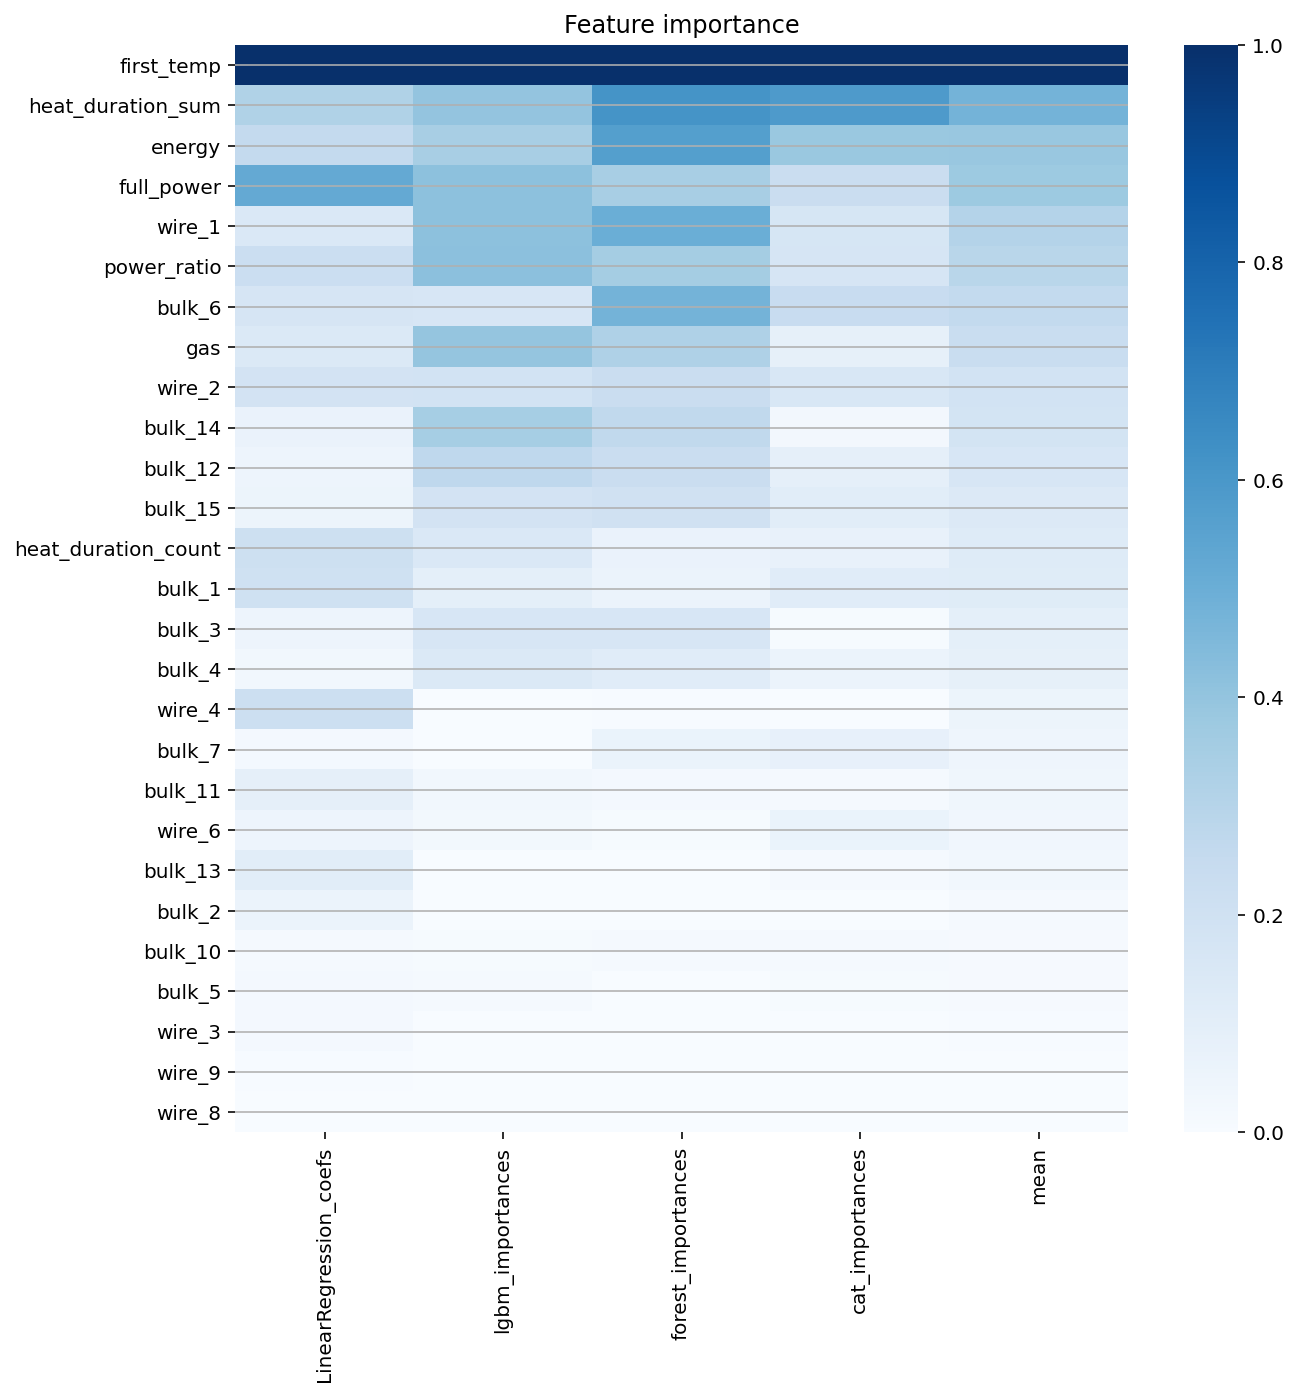

In [113]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance")
sns.heatmap(feature_importances.sort_values("mean", ascending=False), cmap="Blues")
plt.grid(axis="y")
plt.show();

In [114]:
feature_importances.sort_values("mean", ascending=False)["mean"][:20]

first_temp             1.000000
heat_duration_sum      0.479361
energy                 0.389238
full_power             0.378559
wire_1                 0.307207
power_ratio            0.292318
bulk_6                 0.261521
gas                    0.236954
wire_2                 0.190015
bulk_14                0.179730
bulk_12                0.162559
bulk_15                0.138364
heat_duration_count    0.126014
bulk_1                 0.119699
bulk_3                 0.096165
bulk_4                 0.088376
wire_4                 0.056665
bulk_7                 0.043088
bulk_11                0.039911
wire_6                 0.037895
Name: mean, dtype: float64

If we compare the feature importance in the grouped data on all models, then the most important features are:  
 - 'first_temp',
 - 'heat_duration_sum' и 'energy',
 - 'full_power', 'wire_1',
 - 'power_ratio', 'bulk_6', 'gas', 'wire_2', 'bulk_14'.  


Если сравнить важность признаков в сгруппированных данных на всех моделях, то самые важные признаки:
 - 'first_temp' - для всех моделей,
 - 'heat_duration_sum' и 'energy',
 - 'full_power', 'wire_1',
 - 'power_ratio', 'bulk_6', 'gas', 'wire_2', 'bulk_14'.  

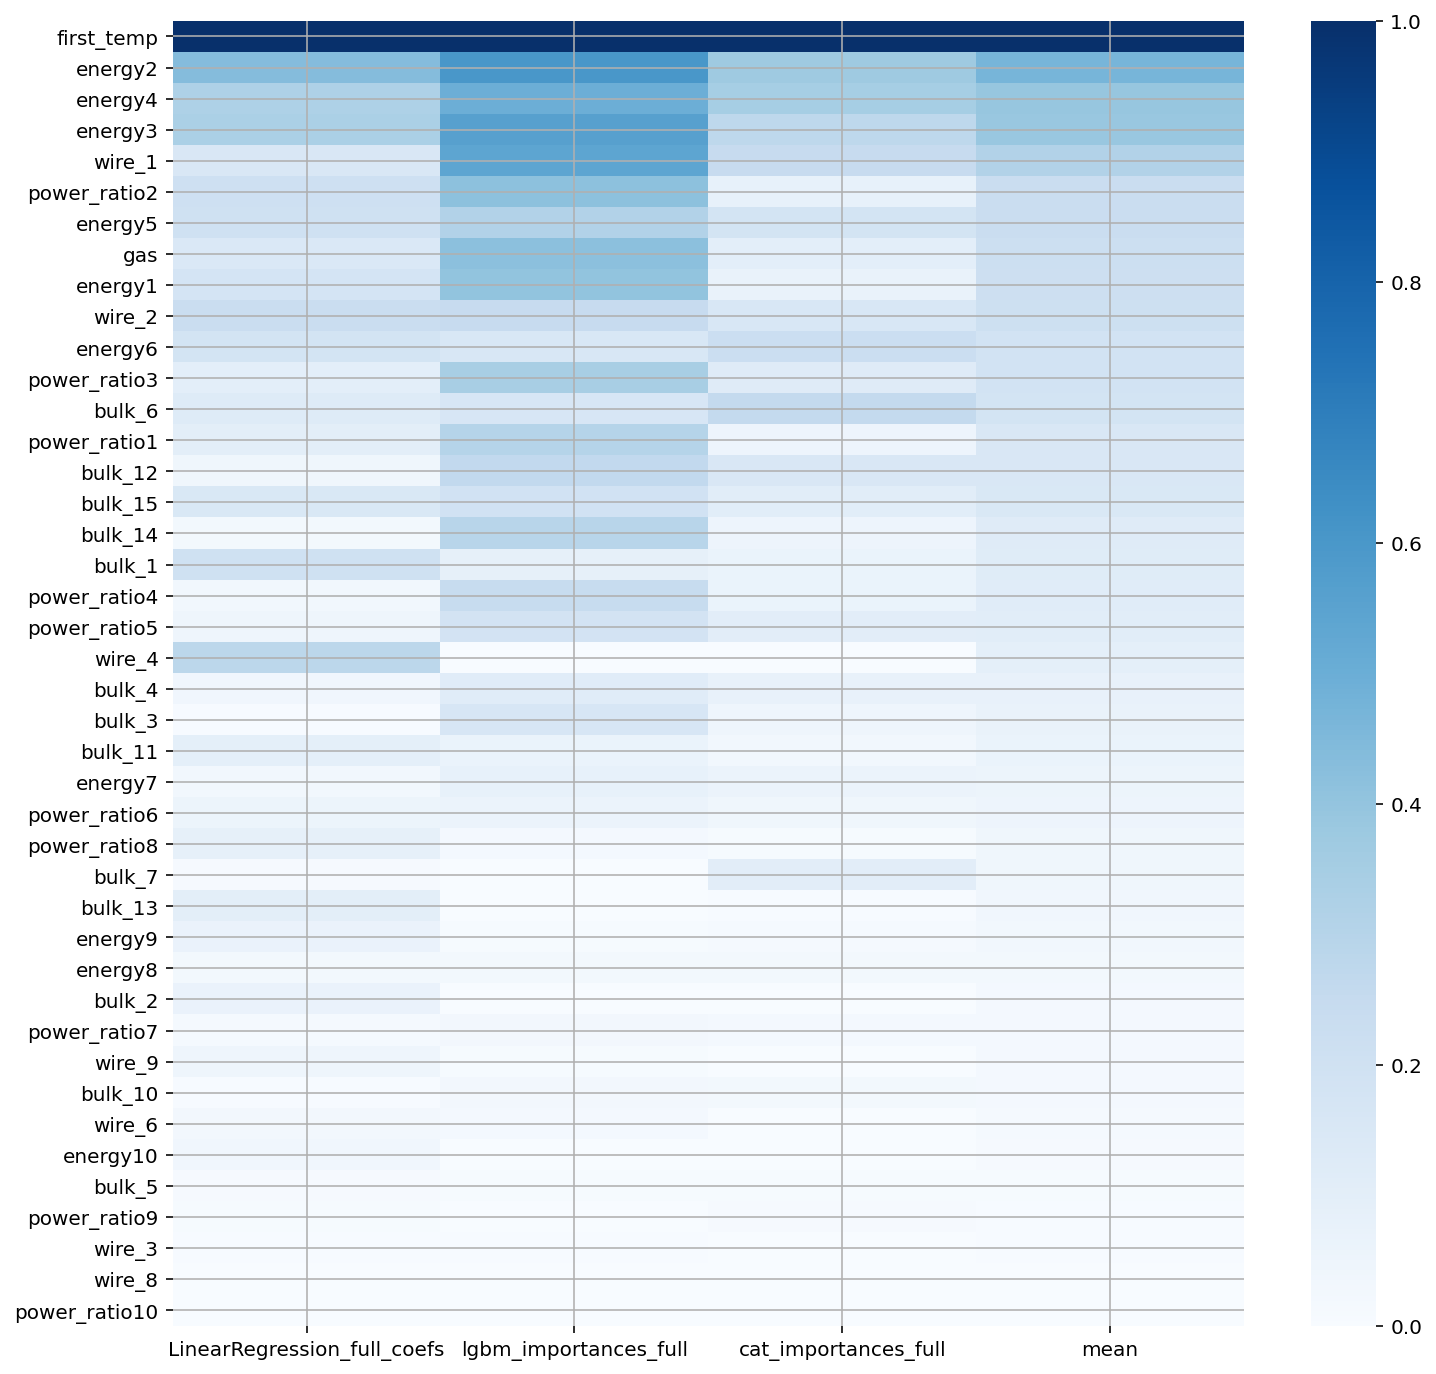

In [115]:
plt.figure(figsize=(12, 12))
sns.heatmap(feature_importances_full.sort_values("mean", ascending=False), cmap="Blues")
plt.grid()
plt.show();

In [116]:
feature_importances_full.sort_values("mean", ascending=False)["mean"][:15]

first_temp      1.000000
energy2         0.470296
energy4         0.391881
energy3         0.390197
wire_1          0.313020
power_ratio2    0.234154
energy5         0.233310
gas             0.222452
energy1         0.217439
wire_2          0.213634
energy6         0.189376
power_ratio3    0.188471
bulk_6          0.181468
power_ratio1    0.154226
bulk_12         0.152899
Name: mean, dtype: float64

If we compare the importance of features in ungrouped data across all models, then the most important features are: 
 - 'first_temp',
 - 'energy2', 'energy3', 'energy4',
 - 'wire_1', 'power_ratio2',
 - 'gas', 'wire_2', 'energy1', 'bulk_6', 'energy5',
 - 'power_ratio1', 'power_ratio3', 'energy6', 'bulk_15', 'bulk_12', 'bulk_14', 'power_ratio4', 'bulk_1', 'wire_4'.


Если сравнить важность признаков в негруппированных данных на всех моделях, то самые важные признаки:
 - 'first_temp' - для всех моделей,
 - 'energy2', 'energy3', 'energy4',
 - 'wire_1', 'power_ratio2',
 - 'gas', 'wire_2', 'energy1', 'bulk_6', 'energy5',
 - 'power_ratio1', 'power_ratio3', 'energy6', 'bulk_15', 'bulk_12', 'bulk_14', 'power_ratio4', 'bulk_1', 'wire_4'.

<a id='4'></a>

## Check models on test / Проверка моделей на тестовых данных

Best models on validation / Лучшие модели на валидации:

In [117]:
summary.loc["MAE_valid"].sort_values()

Sequential                5.084
LinearRegression          5.325
Sequential_full           5.453
LinearRegression_full     5.550
CatBoostRegressor         6.044
CatBoostRegressor_full    6.079
LGBMRegressor             6.101
LGBMRegressor_full        6.120
RandomForest              6.221
Name: MAE_valid, dtype: float64

The best models / На валидации лучшими моделями оказались: 'LinearRegression', 'LinearRegression_full', 'Sequential', 'Sequential_full'.  

In [118]:
fill_summary(lr, "LinearRegression", cv=False, data="not_full", fill_test=True)
fill_summary(lr_full, "LinearRegression_full", cv=False, data="full", fill_test=True)
fill_summary(model, "Sequential", cv=False, data="not_full", fill_test=True)
fill_summary(model_full, "Sequential_full", cv=False, data="full", fill_test=True)
summary[["LinearRegression", "LinearRegression_full", "Sequential", "Sequential_full"]]

LinearRegression  LinearRegression_full  Sequential  \
MAE_valid             5.325                  5.550       5.084   
MAE_test              5.688                  5.746       5.651   

           Sequential_full  
MAE_valid            5.453  
MAE_test             5.581

Эти же модели показали хороший результат на тестовых данных. Лучшая модель - Sequential_full, на втором месте - Sequential, на третьем - LinearRegression и LinearRegression_full.

<a id='5'></a>

## Conclusion / Выводы

___As a result of the data study, the following results were obtained:___
- the most frequent bulk additives:
        bulk_14-added in 89.6% of batches,
        bulk_12-in 78.3%,
        bulk_15 - in 71.8%,
        bulk_3 - in 41.5%,
        bulk_4 - in 32.4%,
        bulk_6 - in 18.4%,
- we have data from the beginning of May to the beginning of September 2019 -  4 months,
- in the table with the data on the electrodes, a large negative value was found in the "Reactive power" column,
- most of the batches were heated 1-9 times, most often 4-6 times, 11-16 times very rarely,
- most of the heats are 1-6 minutes, more than 8 minutes of heating was carried out very rarely,
- in total, each batch was heated for an average of 13 minutes, mostly from 4 to 25 minutes, values greater than 40 minutes are very rare and may be errors,
- the average value of the active power is 0.67, most of the values are in the range of 0.2 -1.2, values greater than 1.5 are similar to the measurement error,
- the average value of the reactive power is 0.5, most of the values lie in the range of 0.15 -1.09,
- based on the active and reactive power measurements, it is recommended to calculate the total power and energy consumption for each heating, as well as the ratio of active and reactive power,
- the values of active and reactive power are  strongly correlated,
- in the table on the gas purge of the alloy, the main part of the values lies in the range of 7-23, the average is 11, values greater than 40 are very rare and may be errors,
- in the table with data on the volume of wire materials in the column "Wire 5" there is only 1 value, it may be an error when filling in the tables,
- the most frequent wire materials:
        wire_1-added in 99.16% of batches,
        wire_2-in 35.02%,
        wire_6-in 2.37%,
        wire_3 - in 2.04%,
- in the table with the temperature measurement there are 2901 rows without temperature data,
- there are several temperature values less than 1500,
- for the 741 batch, there is only one temperature measurement, although at least there should be a start and end, all this suggests that there may be an error when measuring the temperature or filling in the table, it is recommended to check at what stage the erroneous data is lost or obtained,
- the average value of the initial temperature is 1589 degrees, the minimum is 1519, the maximum is 1679, most of the values lie in the range of 1550-1633 degrees,
- the average value of the final temperature is 1595 degrees, the minimum is 1541, the maximum is 1700, most of the values lie in the range of 1576 - 1621 degrees,
- it is recommended to check whether these values are similar to the real ones.


___Final temperature prediction results:___
- the models were trained using data in two versions:
    - with the grouping of data on the electrodes and the calculation of the total energy, heating time and the average values of the total power and the ratio of active and reactive energy for each batch,
    - with all energy values and the ratio of active and reactive energy for each batch, without summation and averaging,
- as a result of data preprocessing, only data for 2300 batches remained,
- columns with less than 10 values were deleted, as well as one of the columns with a correlation coefficient greater than 0.95
- the minimum prediction error on the test data was 5.576 degrees, obtained using a neural network model on the data without grouping,
- in second place - a neural network model based on grouped data (error 5.624 degrees),
- on the third-a linear regression model on grouped data (error 5.688 degrees) and on data without grouping (error 5.746 degrees),
- the most important features for predicting the final temperature were the following:
- initial temperature of the alloy,
- data on the electrodes (energy and the ratio of active and reactive power), for non-grouped data, the values for the first 5 heats are important,
- data on the most frequent wires 'wire_1' and 'wire_2' , as well as 'wire_4',
- data on the most frequent bulk materials bulk_6, bulk_14, bulk_12, bulk_15, bulk_3, bulk_4 and bulk_1

 - ___В результате исследования данных получены следующие результаты:___
      - самые частые сыпучие добавки:   
            bulk_14 - добавляется в 89.6% партий,  
            bulk_12 - в 78.3%,  
            bulk_15 - в 71.8%,  
            bulk_3 - в 41.5%,  
            bulk_4 - в 32.4%,  
            bulk_6 - в 18.4%,  
      - у нас есть данные с начала мая по начало сентября 2019 года, то есть за 4 месяца,
      - в таблице с данными об электродах в столбце "Реактивная мощность" обнаружено большое отрицательное значение,
      - большую часть партий нагревали 1-9 раз, чаще всего 4-6 раз, 11 - 16 раз очень редко,
      - большая часть нагревов 1-6 минут, дольше 8 минут нагрев проводился очень редко,
      - суммарно каждую партию нагревали в среднем 13 минут, в основном от 4 до 25 минут, значения болше 40 минут встречаются очень редко и могуть быть ошибками,
      - среднее значение активной мощности - 0,67, большая часть значений лежит в пределах 0,2 -1,2, значения больше 1,5 похоже на ошибку измерения,
      - среднее значение реактивной мощности - 0,5, большая часть значений лежит в пределах 0,15 -1,09,
      - рекомендутся на основании измерений активной и реактивной мощности вычислять полную мощность и потребление энергии для каждого нагрева, а также соотношение активной и реактивной мощности,
      - значения активной и реактивной мощности очень сильно взаимосвязаны,
      - в таблице о продувке сплава газом, основная часть значений лежит в пределах 7-23, среднее 11, значения больше 40 встречаются очень редко и могуть быть ошибками,
      - в таблице с данными об объеме проволочных материалах в столбце "Wire 5" всего 1 значение, может быть ошибкой при заполнении таблиц,
      - самые частые проволочные материалы:  
             wire_1 - добавляется в 99.16% партий,  
             wire_2 - в 35.02%,  
             wire_6 - в 2.37%,  
             wire_3 - в 2.04%,  
      - в таблице с результатами измерения температуры есть 2901 строк без данных о температуре, 
      - есть несколько значений температуры меньше 1500,
      - для 741 партии есть только одно измерение температуры, хотя как минимум должны быть начальная и конечная, все это говорит о том, что может быть ошибка при считывании температуры или заполнении таблицы, рекомендуется проверить на каком этапе теряются или получаются ошибочные данные,
      - среднее значение начальной температуры - 1589 градусов, минимальное 1519, максимальное - 1679, большая часть значений лежит в промежутке 1550 - 1633 градуса,
      - среднее значение конечной температуры - 1595 градусов, минимальное 1541, максимальное - 1700, большая часть значений лежит в промежутке 1576 - 1621 градус,
      - рекомендуется проверить, похожи ли эти значения на реальные.  
      
      
 - ___Результаты предсказания конечной температуры:___
     - для обучения моделей использовались данные в двух вариантах:
         - с группировкой данных об электродах и вычислением суммарной энергии, времени нагрева и средними значениями полной мощности и отношения активной и реактивной энергии для каждой партии,
         - со всеми значениями энергии и отношения активной и реактивной энергии для каждой партии, без суммирования и усреднения,
     - в результате предобработки данных остались данные только для 2300 партий,
     - проводилось удаление столбцов, в которых было меньше 10 значений, а также одного из столбцов с коэффициентом корреляции больше 0.95
     - минимальная ошибка предсказания на тестовых данных 5.576 градуса, получена с помощью модели нейронной сети на данных без группировки,
     - на втором месте -  модель нейронной сети на сгруппированных данных(ошибка 5.624 градуса),
     - на третьем - модель линейной регрессии на сгруппированных данных (ошибка 5.688 градуса) и на данных без группировки (ошибка 5.746 градуса),
     - самыми важными для предсказания конечной температуры оказались следующие признаки:
         - начальная температура сплава,
         - данные по электродам (энергия и отношение активной и реактивной мощности), для не группированных данных важны показатели на первых 5 нагревах,
         - данные по самым частым проволакам 'wire_1' и 'wire_2', а также 'wire_4',
         - данные по самым частым сыпучим материалам bulk_6 , bulk_14, bulk_12, bulk_15, bulk_3, bulk_4 и по bulk_1
